In [1]:
import numpy as np

In [4]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import os

# List of parquet files with output folder prefix
output_folder = "output/"
parquet_files = [
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet"
]

# Add the folder path prefix to each file
parquet_files = [os.path.join(output_folder, f) for f in parquet_files]

# Function to load a parquet file with correct structure
def load_parquet(file_path):
    # Load parquet file
    print(f"Loading {file_path}...")
    try:
        # Read into pandas DataFrame (if file has simple structure)
        df = pd.read_parquet(file_path)
        print(f"  Successfully loaded with pandas, shape: {df.shape}")
        return df
    except Exception as e:
        # If pandas fails (likely due to complex nested structure), try pyarrow
        print(f"  Pandas read failed: {e}")
        print(f"  Trying pyarrow...")
        try:
            # Read with pyarrow
            table = pq.read_table(file_path)
            # Convert to pandas
            df = table.to_pandas()
            print(f"  Successfully loaded with pyarrow, shape: {df.shape}")
            return df
        except Exception as e2:
            print(f"  PyArrow read also failed: {e2}")
            # If simple conversion fails, we'll have to handle the structure differently
            parquet_file = pq.ParquetFile(file_path)
            print(f"  File schema: {parquet_file.schema}")
            return None

# Check if files exist
missing_files = [f for f in parquet_files if not os.path.exists(f)]
if missing_files:
    print(f"Warning: The following files are missing: {missing_files}")
    # Filter to only existing files
    parquet_files = [f for f in parquet_files if os.path.exists(f)]

# Initialize a list to hold all DataFrames
dfs = []

# Load each file
for file_path in parquet_files:
    df = load_parquet(file_path)
    if df is not None:
        # Add a source column to track which file it came from
        file_id = os.path.basename(file_path).split('_')[3]  # Extract simset ID
        df['source_file'] = file_id
        dfs.append(df)

# Check if we have any data
if not dfs:
    print("No data could be loaded from the provided files.")
else:
    # Combine all DataFrames
    try:
        combined_df = pd.concat(dfs, ignore_index=True)
        print("\nSuccessfully combined all DataFrames!")
        print(f"Combined shape: {combined_df.shape}")
        
        # Basic info about the combined data
        print("\nFirst few rows of the combined DataFrame:")
        print(combined_df.head())
        
        # Count events by source
        print("\nEvents per source file:")
        print(combined_df['source_file'].value_counts())
        
        # Check if 'mc_truth' and 'photons' fields exist and preview structure
        print("\nColumn names:", combined_df.columns.tolist())
        
        # Try to explore nested structure
        if 'mc_truth' in combined_df.columns:
            print("\nmc_truth structure (first event):", type(combined_df['mc_truth'].iloc[0]))
            # Try to show keys if it's a dictionary-like structure
            try:
                print("mc_truth keys:", list(combined_df['mc_truth'].iloc[0].keys()))
            except:
                print("Could not extract mc_truth keys")
        
        if 'photons' in combined_df.columns:
            print("\nphotons structure (first event):", type(combined_df['photons'].iloc[0]))
            # Try to show keys if it's a dictionary-like structure
            try:
                print("photons keys:", list(combined_df['photons'].iloc[0].keys()))
            except:
                print("Could not extract photons keys")
    except Exception as e:
        print(f"Error combining DataFrames: {e}")
        
        # Try alternative approach if standard concat fails
        print("Trying alternative approach for combining data...")
        
        # Initialize empty dictionaries to store combined data
        combined_data = {
            'mc_truth': [],
            'photons': []
        }
        
        # Process each file separately
        for file_path in parquet_files:
            try:
                parquet_file = pq.ParquetFile(file_path)
                # Read whole file
                table = parquet_file.read()
                # Convert to dictionary
                data_dict = table.to_pydict()
                
                # Add to our combined data
                if 'mc_truth' in data_dict:
                    combined_data['mc_truth'].extend(data_dict['mc_truth'])
                if 'photons' in data_dict:
                    combined_data['photons'].extend(data_dict['photons'])
                
                print(f"Added data from {file_path}")
            except Exception as e:
                print(f"Could not process {file_path}: {e}")
        
        # Create a DataFrame from combined data
        combined_df = pd.DataFrame(combined_data)
        print(f"Created combined DataFrame with shape: {combined_df.shape}")

# Save the combined DataFrame to a new parquet file
try:
    save_path = os.path.join(output_folder, 'combined_60k_events.parquet')
    print(f"\nSaving combined data to '{save_path}'...")
    combined_df.to_parquet(save_path)
    print("Save successful!")
except Exception as e:
    print(f"Error saving combined file: {e}")
    
    # Try alternative save approach
    print("Trying alternative save approach...")
    try:
        # Convert to arrow table and save
        import pyarrow as pa
        table = pa.Table.from_pandas(combined_df)
        pq.write_table(table, save_path)
        print("Save successful using pyarrow!")
    except Exception as e2:
        print(f"Alternative save also failed: {e2}")

Loading output/10000_events_simset_1605_seed_1005_20250516_112950.parquet...
  Successfully loaded with pandas, shape: (10000, 2)
Loading output/10000_events_simset_1601_seed_1001_20250516_112659.parquet...
  Successfully loaded with pandas, shape: (10000, 2)
Loading output/10000_events_simset_1603_seed_1003_20250516_112857.parquet...
  Successfully loaded with pandas, shape: (10000, 2)
Loading output/10000_events_simset_1604_seed_1004_20250516_112923.parquet...
  Successfully loaded with pandas, shape: (10000, 2)
Loading output/10000_events_simset_1602_seed_1002_20250516_112840.parquet...
  Successfully loaded with pandas, shape: (10000, 2)
Loading output/10000_events_simset_1600_seed_1000_20250516_112519.parquet...
  Successfully loaded with pandas, shape: (10000, 2)

Successfully combined all DataFrames!
Combined shape: (60000, 3)

First few rows of the combined DataFrame:
                                            mc_truth  \
0  {'interaction': 1, 'initial_state_energy': 16....   

In [5]:
combined_df

mc_truth  \
0      {'interaction': 1, 'initial_state_energy': 16....   
1      {'interaction': 2, 'initial_state_energy': 32....   
2      {'interaction': 1, 'initial_state_energy': 14....   
3      {'interaction': 1, 'initial_state_energy': 26....   
4      {'interaction': 1, 'initial_state_energy': 25....   
...                                                  ...   
59995  {'interaction': 2, 'initial_state_energy': 26....   
59996  {'interaction': 2, 'initial_state_energy': 11....   
59997  {'interaction': 1, 'initial_state_energy': 14....   
59998  {'interaction': 1, 'initial_state_energy': 20....   
59999  {'interaction': 1, 'initial_state_energy': 41....   

                                                 photons source_file  
0      {'sensor_pos_x': [-32.96, -9.68, 41.6, -10.97,...        1605  
1      {'sensor_pos_x': [], 'sensor_pos_y': [], 'sens...        1605  
2      {'sensor_pos_x': [46.29, 46.29, 46.29, 46.29, ...        1605  
3      {'sensor_pos_x': [31.25, -10.97, -9.68, -10.97...        1605  
4      {'sensor_pos_x': [-9.68, 31.25, 57.2, 72.37, 4...        1605  
...                                                  ...         ...  
59995  {'sensor_pos_x': [57.2, 72.37, 57.2, 113.19, 7...        1600  
59996  {'sensor_pos_x': [-10.97], 'sensor_pos_y': [6....        1600  
59997  {'sensor_pos_x': [113.19, 72.37, -10.97, -9.68...        1600  
59998  {'sensor_pos_x': [106.94, 113.19, 106.94, 41.6...        1600  
59999  {'sensor_pos_x': [-9.68, 31.25, 31.25, 46.29, ...        1600  

[60000 rows x 3 columns]

In [6]:
pa = pd.read_parquet('output/genie_events_primary_new_test_simset_1605_nevents_10000_seed_1005.parquet')

In [9]:
pa['custom_info'][0]

'nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[CC],DIS;'

In [13]:
pa['interaction'][0:3]

0    CC
1    NC
2    CC
Name: interaction, dtype: object

pa.columns

In [14]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Directory containing the files
data_dir = "output/"

# Get list of primary set files
primary_files = [f for f in os.listdir(data_dir) if "primary_new_test_simset" in f]
primary_files.sort()  # Sort for consistent ordering

print(f"Found {len(primary_files)} primary set files")
print("Files:", primary_files)

# Initialize lists to store data
all_event_ids = []
all_interaction_types = []
all_pdg_codes = []
all_energies = []
all_simset_ids = []
all_bjorken_y = []  # This is useful for physics analysis

# Process each primary file
for primary_file in primary_files:
    file_path = os.path.join(data_dir, primary_file)
    
    # Extract simset ID from filename
    simset_match = re.search(r'simset_(\d+)', primary_file)
    simset_id = simset_match.group(1) if simset_match else "unknown"
    
    print(f"Processing {primary_file} (simset {simset_id})...")
    
    # Load primary dataframe
    try:
        primary_df = pd.read_parquet(file_path)
        print(f"  Loaded primary dataframe with {len(primary_df)} rows")
        
        # Add dataset ID for tracking
        primary_df['simset_id'] = simset_id
        
        # Collect data
        for idx, row in primary_df.iterrows():
            all_event_ids.append(idx)
            all_interaction_types.append(row['interaction'])  # Direct from dataframe
            all_pdg_codes.append(row['pdg_code'])  # Neutrino type
            all_energies.append(row['e'])  # Energy
            all_simset_ids.append(simset_id)
            all_bjorken_y.append(row.get('bjorken_y', np.nan))  # Inelasticity
        
        # Count CC vs NC in this file
        cc_count = sum(1 for x in primary_df['interaction'] if x == 'CC')
        nc_count = sum(1 for x in primary_df['interaction'] if x == 'NC')
        other_count = len(primary_df) - cc_count - nc_count
        
        print(f"  Found {cc_count} CC events, {nc_count} NC events, and {other_count} other events")
    
    except Exception as e:
        print(f"  Error processing {primary_file}: {e}")

# Create a dataframe of event classifications
event_info_df = pd.DataFrame({
    'event_id': all_event_ids,
    'interaction_type': all_interaction_types,
    'pdg_code': all_pdg_codes,
    'energy': all_energies,
    'simset_id': all_simset_ids,
    'bjorken_y': all_bjorken_y
})

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total events processed: {len(event_info_df)}")
print(f"CC events: {len(event_info_df[event_info_df['interaction_type'] == 'CC'])}")
print(f"NC events: {len(event_info_df[event_info_df['interaction_type'] == 'NC'])}")

# Create a mapping dictionary for later matching
event_mapping = {}
for _, row in event_info_df.iterrows():
    event_mapping[(row['simset_id'], row['event_id'])] = {
        'interaction_type': row['interaction_type'],
        'pdg_code': row['pdg_code'],
        'energy': row['energy'],
        'bjorken_y': row['bjorken_y']
    }

# Save event_info_df for later use
event_info_df.to_csv(os.path.join(data_dir, 'event_classifications.csv'), index=False)
print(f"Saved event classifications to {os.path.join(data_dir, 'event_classifications.csv')}")

# Create exploratory plots
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of interaction types
plt.subplot(2, 3, 1)
interaction_counts = event_info_df['interaction_type'].value_counts()
plt.bar(interaction_counts.index, interaction_counts.values)
plt.title('Distribution of Interaction Types')
plt.ylabel('Number of Events')
plt.grid(alpha=0.3)

# Plot 2: Distribution of neutrino types (PDG codes)
plt.subplot(2, 3, 2)
pdg_counts = event_info_df['pdg_code'].value_counts()
plt.bar(pdg_counts.index, pdg_counts.values)
plt.title('Distribution of Neutrino Types')
plt.xlabel('PDG Code')
plt.ylabel('Number of Events')
plt.grid(alpha=0.3)

# Plot 3: Energy distribution by interaction type
plt.subplot(2, 3, 3)
energy_min = event_info_df['energy'].min()
energy_max = event_info_df['energy'].max()
bins = np.logspace(np.log10(energy_min), np.log10(energy_max), 50)
for interaction in ['CC', 'NC']:
    subset = event_info_df[event_info_df['interaction_type'] == interaction]
    if len(subset) > 0:
        plt.hist(subset['energy'], bins=bins, alpha=0.5, label=interaction)
plt.xscale('log')
plt.xlabel('Energy (GeV)')
plt.ylabel('Number of Events')
plt.title('Energy Distribution by Interaction Type')
plt.legend()
plt.grid(alpha=0.3)

# Plot 4: Bjorken-y distribution by interaction type
plt.subplot(2, 3, 4)
for interaction in ['CC', 'NC']:
    subset = event_info_df[event_info_df['interaction_type'] == interaction]
    if len(subset) > 0:
        plt.hist(subset['bjorken_y'], bins=25, alpha=0.5, label=interaction, range=(0, 1))
plt.xlabel('Bjorken y (Inelasticity)')
plt.ylabel('Number of Events')
plt.title('Inelasticity Distribution by Interaction Type')
plt.legend()
plt.grid(alpha=0.3)

# Plot 5: Event counts by simset
plt.subplot(2, 3, 5)
simset_counts = event_info_df.groupby(['simset_id', 'interaction_type']).size().unstack(fill_value=0)
simset_counts.plot(kind='bar', ax=plt.gca())
plt.title('Event Counts by Simulation Set')
plt.xlabel('Simulation Set ID')
plt.ylabel('Number of Events')
plt.grid(alpha=0.3)
plt.legend(title='Interaction Type')

# Plot 6: Energy vs Bjorken-y scatter plot
plt.subplot(2, 3, 6)
cc_mask = event_info_df['interaction_type'] == 'CC'
nc_mask = event_info_df['interaction_type'] == 'NC'
plt.scatter(event_info_df[cc_mask]['energy'], event_info_df[cc_mask]['bjorken_y'], 
           alpha=0.3, label='CC', s=5)
plt.scatter(event_info_df[nc_mask]['energy'], event_info_df[nc_mask]['bjorken_y'], 
           alpha=0.3, label='NC', s=5)
plt.xscale('log')
plt.xlabel('Energy (GeV)')
plt.ylabel('Bjorken y (Inelasticity)')
plt.title('Energy vs Inelasticity')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'event_distributions.png'))
plt.show()

print("Generated plots saved to event_distributions.png")

Found 48 primary set files
Files: ['genie_events_primary_new_test_simset_1600_nevents_10000_seed_1000.parquet', 'genie_events_primary_new_test_simset_1601_nevents_10000_seed_1001.parquet', 'genie_events_primary_new_test_simset_1602_nevents_10000_seed_1002.parquet', 'genie_events_primary_new_test_simset_1603_nevents_10000_seed_1003.parquet', 'genie_events_primary_new_test_simset_1604_nevents_10000_seed_1004.parquet', 'genie_events_primary_new_test_simset_1605_nevents_10000_seed_1005.parquet', 'genie_events_primary_new_test_simset_1606_nevents_10000_seed_1006.parquet', 'genie_events_primary_new_test_simset_1607_nevents_10000_seed_1007.parquet', 'genie_events_primary_new_test_simset_1608_nevents_10000_seed_1008.parquet', 'genie_events_primary_new_test_simset_1609_nevents_10000_seed_1009.parquet', 'genie_events_primary_new_test_simset_1610_nevents_10000_seed_1010.parquet', 'genie_events_primary_new_test_simset_1611_nevents_10000_seed_1011.parquet', 'genie_events_primary_new_test_simset_171

KeyboardInterrupt: 

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Directory containing your files
data_dir = "output/"

# Your specific primary files
primary_files = [
    "genie_events_primary_new_test_simset_1600_nevents_10000_seed_1000.parquet",
    "genie_events_primary_new_test_simset_1601_nevents_10000_seed_1001.parquet",
    "genie_events_primary_new_test_simset_1602_nevents_10000_seed_1002.parquet",
    "genie_events_primary_new_test_simset_1603_nevents_10000_seed_1003.parquet",
    "genie_events_primary_new_test_simset_1604_nevents_10000_seed_1004.parquet",
    "genie_events_primary_new_test_simset_1605_nevents_10000_seed_1005.parquet"
]

# Initialize a list to store all the primary dataframes
primary_dfs = []

# Load each primary file
for file_name in primary_files:
    file_path = os.path.join(data_dir, file_name)
    
    # Extract simset ID
    simset_id = file_name.split("_")[4]
    
    print(f"Loading {file_name} (simset {simset_id})...")
    
    try:
        # Load the dataframe
        df = pd.read_parquet(file_path)
        
        # Add simset_id column for tracking
        df['simset_id'] = simset_id
        
        # Count CC vs NC
        cc_count = sum(1 for x in df['interaction'] if x == 'CC')
        nc_count = sum(1 for x in df['interaction'] if x == 'NC')
        
        print(f"  Loaded {len(df)} events: {cc_count} CC and {nc_count} NC")
        
        # Add to our list of dataframes
        primary_dfs.append(df)
        
    except Exception as e:
        print(f"  Error loading {file_name}: {e}")


Loading genie_events_primary_new_test_simset_1600_nevents_10000_seed_1000.parquet (simset test)...
  Loaded 10000 events: 7601 CC and 2399 NC
Loading genie_events_primary_new_test_simset_1601_nevents_10000_seed_1001.parquet (simset test)...
  Loaded 10000 events: 7517 CC and 2483 NC
Loading genie_events_primary_new_test_simset_1602_nevents_10000_seed_1002.parquet (simset test)...
  Loaded 10000 events: 7522 CC and 2478 NC
Loading genie_events_primary_new_test_simset_1603_nevents_10000_seed_1003.parquet (simset test)...
  Loaded 10000 events: 7497 CC and 2503 NC
Loading genie_events_primary_new_test_simset_1604_nevents_10000_seed_1004.parquet (simset test)...
  Loaded 10000 events: 7535 CC and 2465 NC
Loading genie_events_primary_new_test_simset_1605_nevents_10000_seed_1005.parquet (simset test)...
  Loaded 10000 events: 7417 CC and 2583 NC



Combined dataframe has 60000 events
Total: 45089 CC events and 14911 NC events


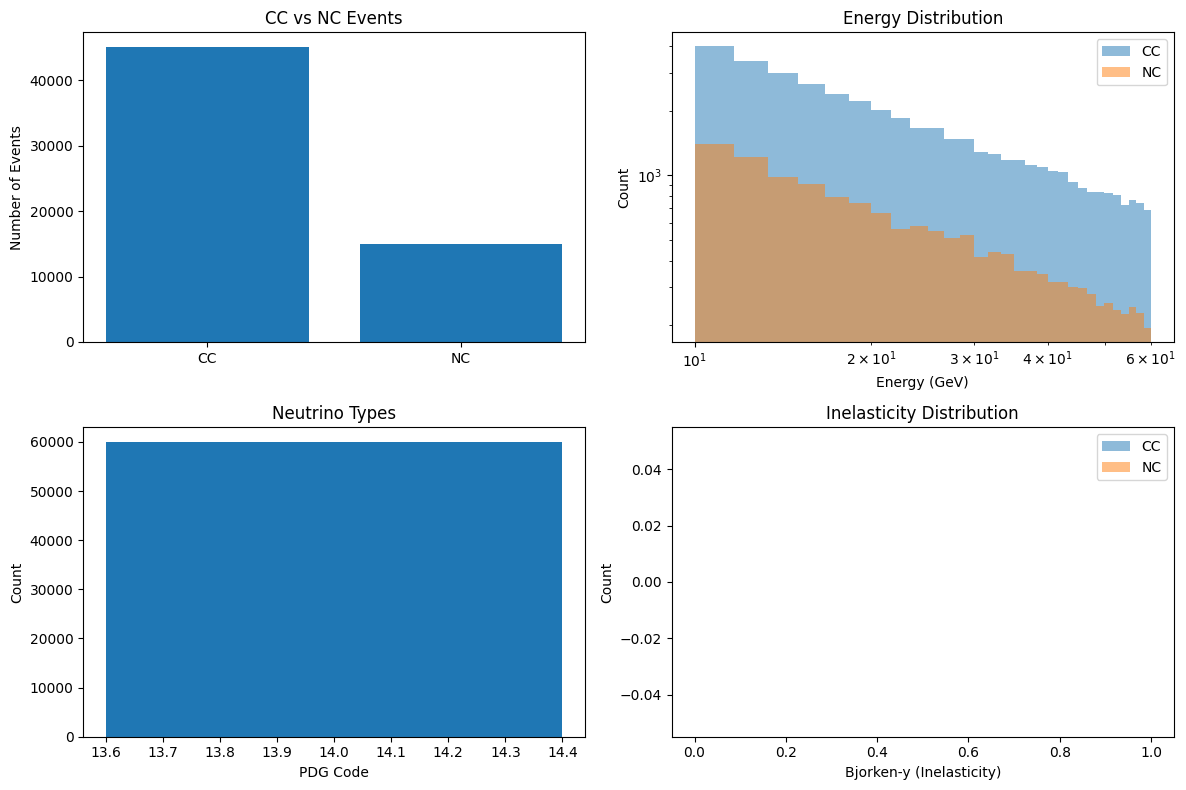


Saved summary plot to primary_data_summary.png
Saved combined primary data to combined_primary_data.csv

Event info dictionary contains information for all events
Example accessing information for simset 1600, event 0:


In [19]:

# Combine all primary dataframes
if primary_dfs:
    all_primary_df = pd.concat(primary_dfs, ignore_index=True)
    print(f"\nCombined dataframe has {len(all_primary_df)} events")
    
    # Count total CC vs NC
    cc_total = sum(1 for x in all_primary_df['interaction'] if x == 'CC')
    nc_total = sum(1 for x in all_primary_df['interaction'] if x == 'NC')
    print(f"Total: {cc_total} CC events and {nc_total} NC events")
    
    # Create event mapping dictionary - key is (simset_id, event_index)
    event_info = {}
    for idx, row in all_primary_df.iterrows():
        event_info[(row['simset_id'], idx)] = {
            'interaction': row['interaction'],
            'energy': row['e'],
            'pdg_code': row['pdg_code'],
            'bjorken_y': row.get('bjorken_y', None)
        }
    
    # Create basic visualization
    plt.figure(figsize=(12, 8))
    
    # Plot CC vs NC distribution
    plt.subplot(2, 2, 1)
    counts = all_primary_df['interaction'].value_counts()
    plt.bar(counts.index, counts.values)
    plt.title('CC vs NC Events')
    plt.ylabel('Number of Events')
    
    # Plot energy distribution by interaction type
    plt.subplot(2, 2, 2)
    for interaction in ['CC', 'NC']:
        subset = all_primary_df[all_primary_df['interaction'] == interaction]
        plt.hist(subset['e'], bins=30, alpha=0.5, label=interaction, log=True)
    plt.xscale('log')
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Count')
    plt.title('Energy Distribution')
    plt.legend()
    
    # Plot neutrino type distribution
    plt.subplot(2, 2, 3)
    pdg_counts = all_primary_df['pdg_code'].value_counts()
    plt.bar(pdg_counts.index, pdg_counts.values)
    plt.xlabel('PDG Code')
    plt.ylabel('Count')
    plt.title('Neutrino Types')
    
    # Plot inelasticity (bjorken_y) if available
    if 'bjorken_y' in all_primary_df.columns:
        plt.subplot(2, 2, 4)
        for interaction in ['CC', 'NC']:
            subset = all_primary_df[all_primary_df['interaction'] == interaction]
            plt.hist(subset['bjorken_y'], bins=30, alpha=0.5, label=interaction, range=(0, 1))
        plt.xlabel('Bjorken-y (Inelasticity)')
        plt.ylabel('Count')
        plt.title('Inelasticity Distribution')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'primary_data_summary.png'))
    plt.show()
    
    print("\nSaved summary plot to primary_data_summary.png")
    
    # Save the combined primary data with simset_id for reference
    all_primary_df.to_csv(os.path.join(data_dir, 'combined_primary_data.csv'), index=True)
    print("Saved combined primary data to combined_primary_data.csv")
    
    # Now we can use event_info dictionary to match with photon data
    print("\nEvent info dictionary contains information for all events")
    print("Example accessing information for simset 1600, event 0:")
    if ('1600', 0) in event_info:
        print(event_info[('1600', 0)])
    
else:
    print("No data was loaded!")

In [31]:
combined_df['mc_truth'][11]['interaction']

2

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Directory containing your files
data_dir = "output/"

# Your specific primary files
primary_files = [
    "genie_events_primary_new_test_simset_1600_nevents_10000_seed_1000.parquet",
    "genie_events_primary_new_test_simset_1601_nevents_10000_seed_1001.parquet",
    "genie_events_primary_new_test_simset_1602_nevents_10000_seed_1002.parquet",
    "genie_events_primary_new_test_simset_1603_nevents_10000_seed_1003.parquet",
    "genie_events_primary_new_test_simset_1604_nevents_10000_seed_1004.parquet",
    "genie_events_primary_new_test_simset_1605_nevents_10000_seed_1005.parquet"
]

# Corresponding simulation output files
output_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Initialize lists to store results
primary_data = []
simset_ids = []

# Process primary files to get interaction types
print("Processing primary files...")
for primary_file in primary_files:
    file_path = os.path.join(data_dir, primary_file)
    
    # Extract simset ID
    simset_id = primary_file.split("_")[4]
    simset_ids.append(simset_id)
    
    print(f"Loading {primary_file} (simset {simset_id})...")
    
    try:
        # Load the dataframe
        primary_df = pd.read_parquet(file_path)
        
        # Store relevant info (event index -> interaction type mapping)
        for idx, row in primary_df.iterrows():
            # Convert 'CC'/'NC' to 1/2 as needed
            interaction_code = 1 if row['interaction'] == 'CC' else 2
            
            primary_data.append({
                'simset_id': simset_id,
                'event_id': idx,
                'interaction_type': row['interaction'],
                'interaction_code': interaction_code,
                'energy': row['e'],
                'pdg_code': row['pdg_code']
            })
        
        cc_count = sum(1 for x in primary_df['interaction'] if x == 'CC')
        nc_count = sum(1 for x in primary_df['interaction'] if x == 'NC')
        print(f"  Loaded {len(primary_df)} events: {cc_count} CC and {nc_count} NC")
        
    except Exception as e:
        print(f"  Error loading {primary_file}: {e}")

# Create DataFrame from primary data
primary_info_df = pd.DataFrame(primary_data)
print(f"\nProcessed {len(primary_info_df)} events from primary files")

# Create a dictionary for quick lookup: (simset_id, event_id) -> interaction_code
interaction_map = {}
for _, row in primary_info_df.iterrows():
    interaction_map[(row['simset_id'], row['event_id'])] = row['interaction_code']

# Now process the simulation output files
print("\nProcessing simulation output files...")

# Function to update mc_truth with correct interaction code
def update_mc_truth_interaction(mc_truth, simset_id, event_id):
    """Update the mc_truth dictionary with the correct interaction code"""
    key = (simset_id, event_id)
    if key in interaction_map:
        # If mc_truth is a dictionary, add or update the interaction field
        if isinstance(mc_truth, dict):
            mc_truth['interaction'] = interaction_map[key]
        return mc_truth
    else:
        print(f"  Warning: No interaction info for simset {simset_id}, event {event_id}")
        return mc_truth

# Function to process a simulation output file
def process_sim_file(file_path, simset_id):
    """Process a simulation output file and update mc_truth"""
    try:
        # Load the simulation dataframe
        sim_df = pd.read_parquet(file_path)
        print(f"  Loaded simulation file with {len(sim_df)} events")
        
        # Check if mc_truth exists
        if 'mc_truth' not in sim_df.columns:
            print("  Warning: No mc_truth column found in simulation file")
            return None
        
        # Update each mc_truth entry with the correct interaction code
        for idx, row in sim_df.iterrows():
            mc_truth = row['mc_truth']
            sim_df.at[idx, 'mc_truth'] = update_mc_truth_interaction(mc_truth, simset_id, idx)
        
        # Sample check to verify updates
        sample_idx = min(5, len(sim_df) - 1)
        if sample_idx >= 0:
            print(f"  Sample check - Event {sample_idx} interaction: {sim_df.iloc[sample_idx]['mc_truth'].get('interaction')}")
        
        return sim_df
    
    except Exception as e:
        print(f"  Error processing simulation file: {e}")
        return None


Processing primary files...
Loading genie_events_primary_new_test_simset_1600_nevents_10000_seed_1000.parquet (simset test)...
  Loaded 10000 events: 7601 CC and 2399 NC
Loading genie_events_primary_new_test_simset_1601_nevents_10000_seed_1001.parquet (simset test)...
  Loaded 10000 events: 7517 CC and 2483 NC
Loading genie_events_primary_new_test_simset_1602_nevents_10000_seed_1002.parquet (simset test)...
  Loaded 10000 events: 7522 CC and 2478 NC
Loading genie_events_primary_new_test_simset_1603_nevents_10000_seed_1003.parquet (simset test)...
  Loaded 10000 events: 7497 CC and 2503 NC
Loading genie_events_primary_new_test_simset_1604_nevents_10000_seed_1004.parquet (simset test)...
  Loaded 10000 events: 7535 CC and 2465 NC
Loading genie_events_primary_new_test_simset_1605_nevents_10000_seed_1005.parquet (simset test)...
  Loaded 10000 events: 7417 CC and 2583 NC

Processed 60000 events from primary files

Processing simulation output files...


In [33]:

# Process each simulation file
updated_sim_dfs = []
for i, output_file in enumerate(output_files):
    if i < len(simset_ids):
        simset_id = simset_ids[i]
        file_path = os.path.join(data_dir, output_file)
        
        print(f"Processing {output_file} (simset {simset_id})...")
        sim_df = process_sim_file(file_path, simset_id)
        
        if sim_df is not None:
            # Add simset_id column
            sim_df['simset_id'] = simset_id
            updated_sim_dfs.append(sim_df)


Processing 10000_events_simset_1600_seed_1000_20250516_112519.parquet (simset test)...
  Loaded simulation file with 10000 events
  Sample check - Event 5 interaction: 2
Processing 10000_events_simset_1601_seed_1001_20250516_112659.parquet (simset test)...
  Loaded simulation file with 10000 events
  Sample check - Event 5 interaction: 2
Processing 10000_events_simset_1602_seed_1002_20250516_112840.parquet (simset test)...
  Loaded simulation file with 10000 events
  Sample check - Event 5 interaction: 2
Processing 10000_events_simset_1603_seed_1003_20250516_112857.parquet (simset test)...
  Loaded simulation file with 10000 events
  Sample check - Event 5 interaction: 2
Processing 10000_events_simset_1604_seed_1004_20250516_112923.parquet (simset test)...
  Loaded simulation file with 10000 events
  Sample check - Event 5 interaction: 2
Processing 10000_events_simset_1605_seed_1005_20250516_112950.parquet (simset test)...
  Loaded simulation file with 10000 events
  Sample check - Eve

In [34]:

# Combine all updated simulation dataframes
if updated_sim_dfs:
    combined_sim_df = pd.concat(updated_sim_dfs, ignore_index=True)
    print(f"\nCombined {len(combined_sim_df)} events from all simulation files")
    
    # Save the updated combined simulation data
    output_path = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')
    combined_sim_df.to_parquet(output_path)
    print(f"Saved combined simulation data with updated interaction codes to {output_path}")
    
    # Verify the updates
    correct_count = 0
    for idx, row in combined_sim_df.iterrows():
        simset_id = row['simset_id']
        key = (simset_id, idx % 10000)  # Assuming 10000 events per simset
        
        if key in interaction_map:
            expected_code = interaction_map[key]
            actual_code = row['mc_truth'].get('interaction')
            
            if expected_code == actual_code:
                correct_count += 1
    
    print(f"\nVerification: {correct_count} out of {len(combined_sim_df)} events have correct interaction codes")
    print(f"Accuracy: {correct_count / len(combined_sim_df) * 100:.2f}%")
else:
    print("No simulation data was processed!")


Combined 60000 events from all simulation files
Saved combined simulation data with updated interaction codes to output/combined_sim_with_interaction.parquet

Verification: 60000 out of 60000 events have correct interaction codes
Accuracy: 100.00%


Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Processing events to count hits...
Processed 44502 CC events and 15498 NC events


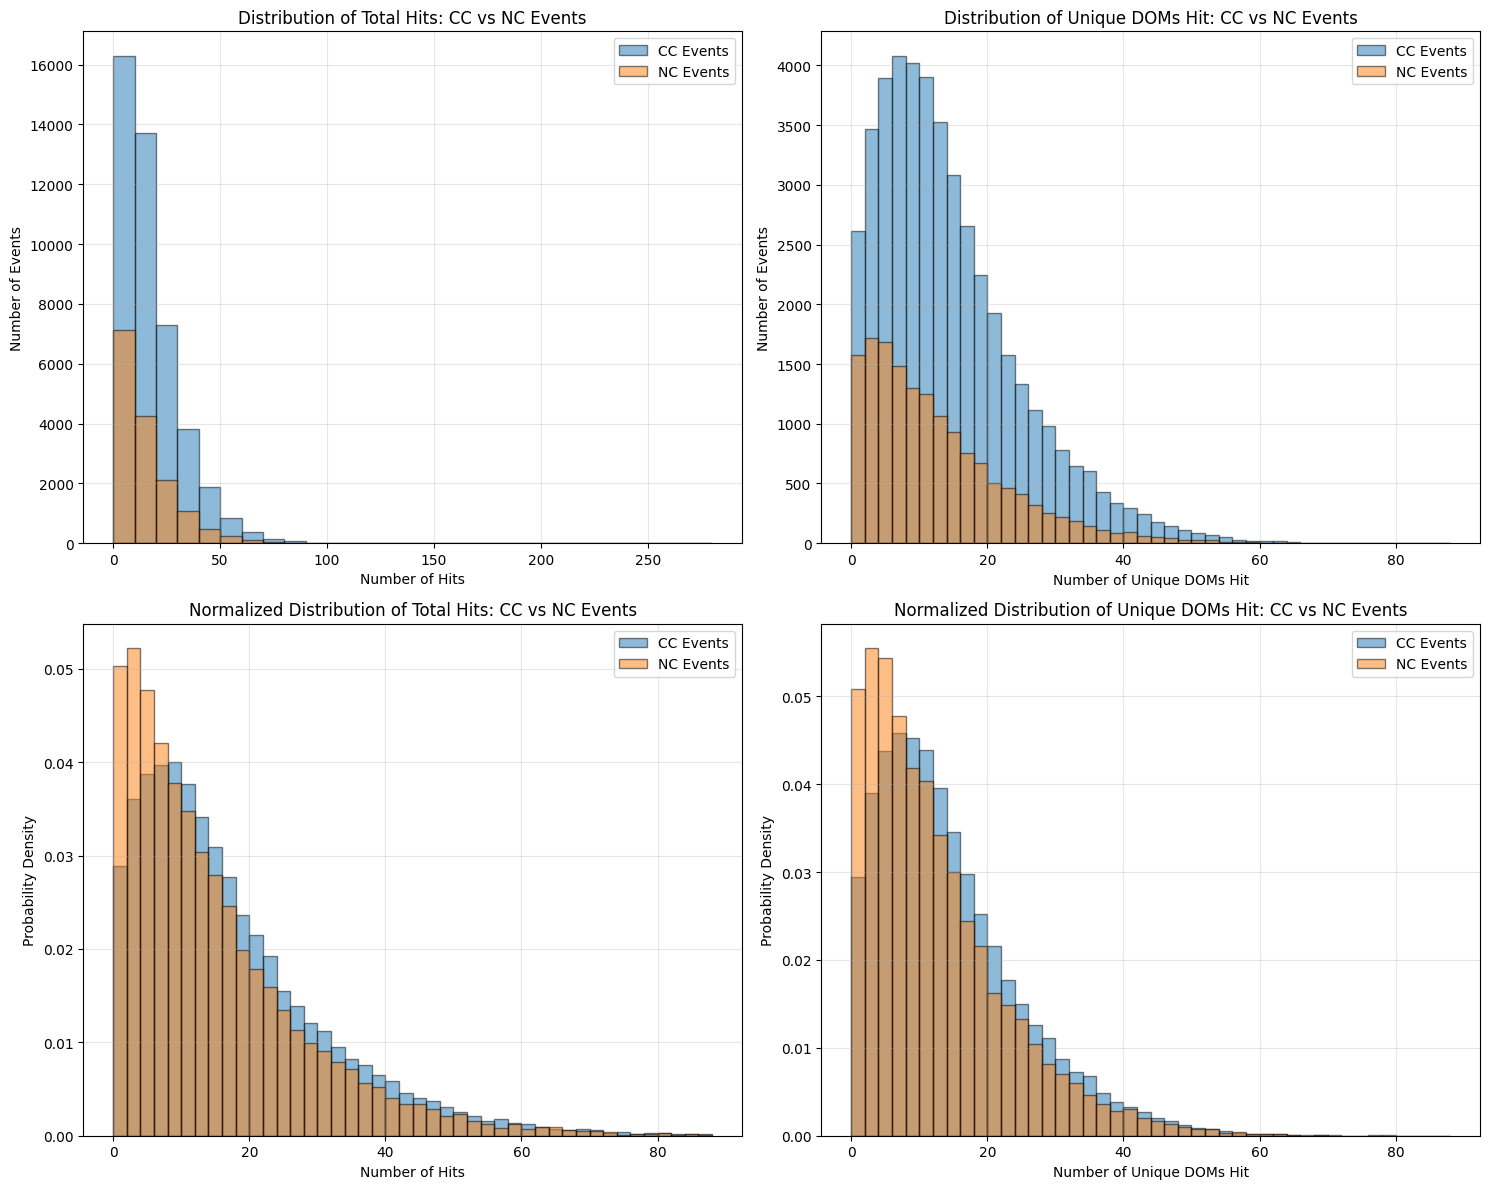


Statistics Summary:
CC Events:
  Mean total hits: 16.88 ± 14.34
  Mean unique DOMs hit: 13.98 ± 10.58
  Min/Max total hits: 0/279
  Min/Max unique DOMs: 0/85

NC Events:
  Mean total hits: 14.65 ± 14.53
  Mean unique DOMs hit: 12.07 ± 10.41
  Min/Max total hits: 0/275
  Min/Max unique DOMs: 0/79


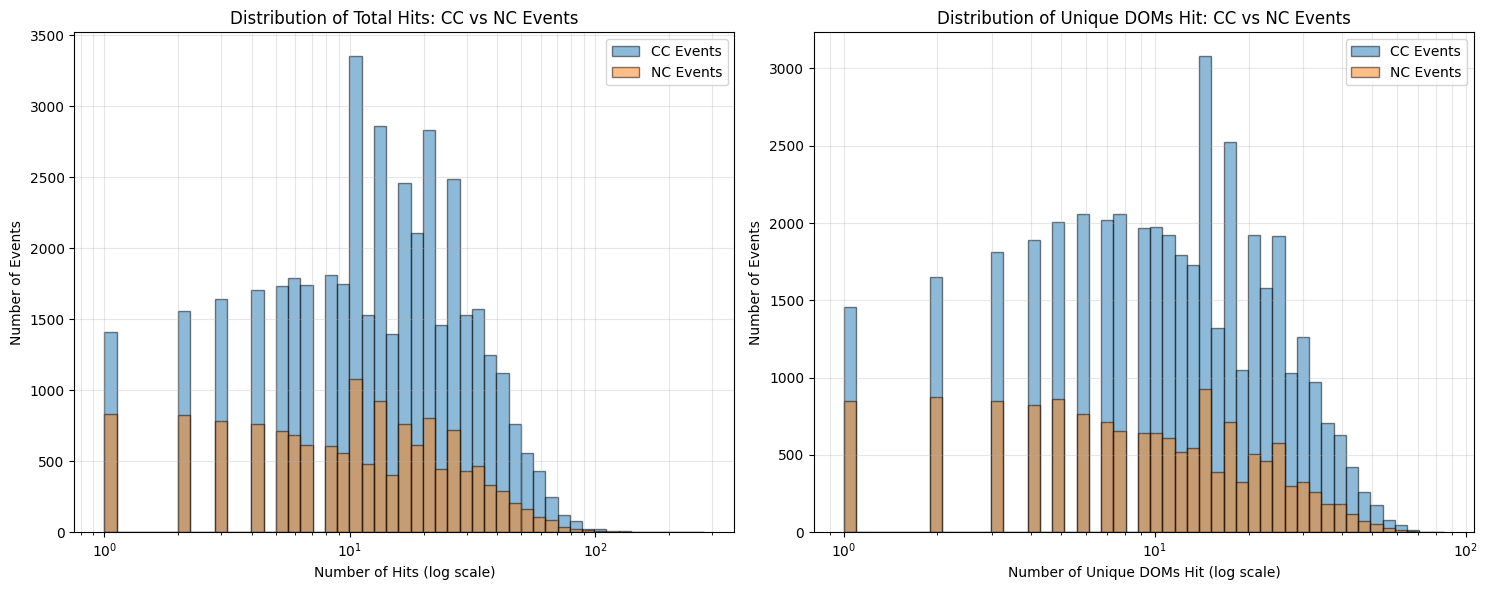

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Initialize arrays to store hit counts
cc_hits = []  # Total hits for CC events
nc_hits = []  # Total hits for NC events
cc_unique_doms = []  # Unique DOMs hit in CC events
nc_unique_doms = []  # Unique DOMs hit in NC events

# Process each event
print("Processing events to count hits...")
for idx, row in combined_df.iterrows():
    # Get interaction type from mc_truth
    interaction_type = row['mc_truth']['interaction']
    
    # Get photon hit data
    photons = row['photons']
    
    # Count total hits
    total_hits = len(photons['t'])
    
    # Count unique DOMs hit (based on string_id and sensor_id)
    unique_doms = len(set(zip(photons['string_id'], photons['sensor_id'])))
    
    # Store based on interaction type
    if interaction_type == 1:  # CC event
        cc_hits.append(total_hits)
        cc_unique_doms.append(unique_doms)
    elif interaction_type == 2:  # NC event
        nc_hits.append(total_hits)
        nc_unique_doms.append(unique_doms)

print(f"Processed {len(cc_hits)} CC events and {len(nc_hits)} NC events")

# Create histograms
plt.figure(figsize=(15, 12))

# 1. Histogram of total hits
plt.subplot(2, 2, 1)
max_hits = max(max(cc_hits, default=0), max(nc_hits, default=0))
bins = np.arange(0, min(1000, max_hits + 10), 10)  # Cap at 1000 for better visibility
plt.hist(cc_hits, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_hits, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Number of Hits')
plt.ylabel('Number of Events')
plt.title('Distribution of Total Hits: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# 2. Histogram of unique DOMs hit
plt.subplot(2, 2, 2)
max_doms = max(max(cc_unique_doms, default=0), max(nc_unique_doms, default=0))
bins = np.arange(0, min(100, max_doms + 5), 2)  # Cap at 100 for better visibility
plt.hist(cc_unique_doms, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_unique_doms, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Number of Unique DOMs Hit')
plt.ylabel('Number of Events')
plt.title('Distribution of Unique DOMs Hit: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# 3. Normalized histogram of total hits (for better comparison)
plt.subplot(2, 2, 3)
plt.hist(cc_hits, bins=bins, alpha=0.5, label='CC Events', edgecolor='black', density=True)
plt.hist(nc_hits, bins=bins, alpha=0.5, label='NC Events', edgecolor='black', density=True)
plt.xlabel('Number of Hits')
plt.ylabel('Probability Density')
plt.title('Normalized Distribution of Total Hits: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# 4. Normalized histogram of unique DOMs hit
plt.subplot(2, 2, 4)
plt.hist(cc_unique_doms, bins=bins, alpha=0.5, label='CC Events', edgecolor='black', density=True)
plt.hist(nc_unique_doms, bins=bins, alpha=0.5, label='NC Events', edgecolor='black', density=True)
plt.xlabel('Number of Unique DOMs Hit')
plt.ylabel('Probability Density')
plt.title('Normalized Distribution of Unique DOMs Hit: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_hit_distributions.png'), dpi=300)
plt.show()

# Print some statistics
print("\nStatistics Summary:")
print("CC Events:")
print(f"  Mean total hits: {np.mean(cc_hits):.2f} ± {np.std(cc_hits):.2f}")
print(f"  Mean unique DOMs hit: {np.mean(cc_unique_doms):.2f} ± {np.std(cc_unique_doms):.2f}")
print(f"  Min/Max total hits: {min(cc_hits)}/{max(cc_hits)}")
print(f"  Min/Max unique DOMs: {min(cc_unique_doms)}/{max(cc_unique_doms)}")

print("\nNC Events:")
print(f"  Mean total hits: {np.mean(nc_hits):.2f} ± {np.std(nc_hits):.2f}")
print(f"  Mean unique DOMs hit: {np.mean(nc_unique_doms):.2f} ± {np.std(nc_unique_doms):.2f}")
print(f"  Min/Max total hits: {min(nc_hits)}/{max(nc_hits)}")
print(f"  Min/Max unique DOMs: {min(nc_unique_doms)}/{max(nc_unique_doms)}")

# Create an additional plot with log scale for x-axis
plt.figure(figsize=(15, 6))

# Total hits with log scale
plt.subplot(1, 2, 1)
bins = np.logspace(np.log10(max(1, min(min(cc_hits), min(nc_hits)))), 
                  np.log10(max(max(cc_hits), max(nc_hits))), 
                  50)
plt.hist(cc_hits, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_hits, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xscale('log')
plt.xlabel('Number of Hits (log scale)')
plt.ylabel('Number of Events')
plt.title('Distribution of Total Hits: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3, which='both')

# Unique DOMs with log scale
plt.subplot(1, 2, 2)
bins = np.logspace(np.log10(max(1, min(min(cc_unique_doms), min(nc_unique_doms)))), 
                  np.log10(max(max(cc_unique_doms), max(nc_unique_doms))), 
                  50)
plt.hist(cc_unique_doms, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_unique_doms, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xscale('log')
plt.xlabel('Number of Unique DOMs Hit (log scale)')
plt.ylabel('Number of Events')
plt.title('Distribution of Unique DOMs Hit: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_hit_distributions_log.png'), dpi=300)
plt.show()

Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Processing events to collect timing data...
Collected 751027 hit times from CC events and 227118 hit times from NC events


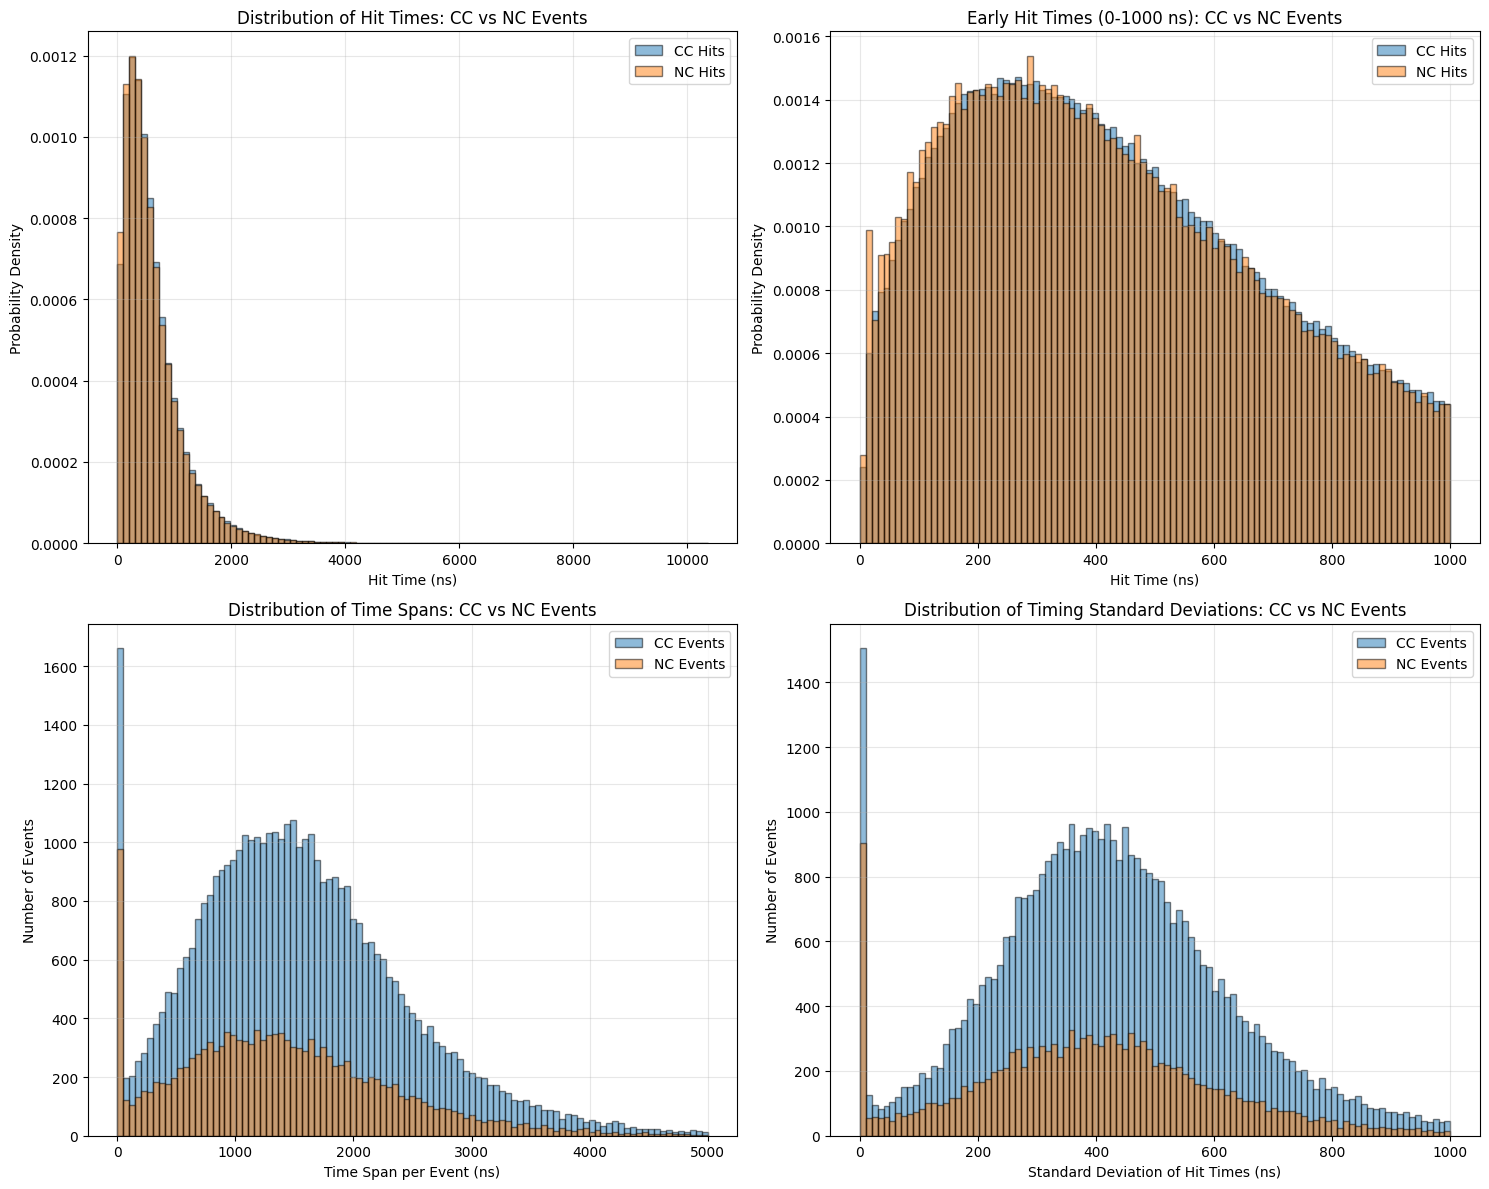

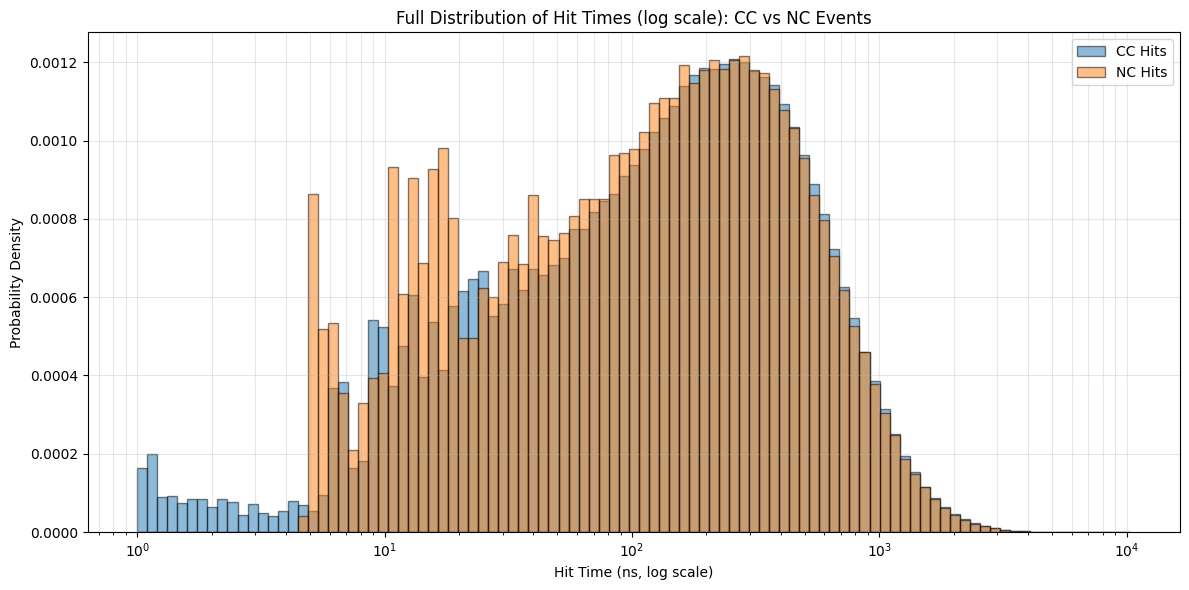


Timing Statistics Summary:
CC Events:
  Mean hit time: 627.12 ns
  Median hit time: 484.08 ns
  Hit time range: 0.17 to 10358.96 ns
  Mean time span per event: 1559.19 ± 925.87 ns
  Mean timing std per event: 431.63 ± 225.77 ns

NC Events:
  Mean hit time: 617.09 ns
  Median hit time: 473.40 ns
  Hit time range: 4.62 to 8764.24 ns
  Mean time span per event: 1431.91 ± 953.42 ns
  Mean timing std per event: 406.76 ± 239.84 ns

Extracting event energies...


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Initialize lists to collect hit times
cc_times = []  # All hit times for CC events
nc_times = []  # All hit times for NC events

# For event-level timing features
cc_time_spans = []  # Time span (max-min) for CC events
nc_time_spans = []  # Time span (max-min) for NC events
cc_time_means = []  # Mean hit time for CC events
nc_time_means = []  # Mean hit time for NC events
cc_time_stds = []   # Standard deviation of hit times for CC events
nc_time_stds = []   # Standard deviation of hit times for NC events

# Process each event
print("Processing events to collect timing data...")
for idx, row in combined_df.iterrows():
    # Get interaction type from mc_truth
    interaction_type = row['mc_truth']['interaction']
    
    # Get photon hit data - specifically the time information
    photon_times = row['photons']['t']
    
    # Skip events with no hits
    if len(photon_times) == 0:
        continue
    
    # Calculate timing features for this event
    time_span = np.max(photon_times) - np.min(photon_times)
    time_mean = np.mean(photon_times)
    time_std = np.std(photon_times)
    
    # Store based on interaction type
    if interaction_type == 1:  # CC event
        cc_times.extend(photon_times)  # Add all hit times to the CC collection
        cc_time_spans.append(time_span)
        cc_time_means.append(time_mean)
        cc_time_stds.append(time_std)
    elif interaction_type == 2:  # NC event
        nc_times.extend(photon_times)  # Add all hit times to the NC collection
        nc_time_spans.append(time_span)
        nc_time_means.append(time_mean)
        nc_time_stds.append(time_std)

print(f"Collected {len(cc_times)} hit times from CC events and {len(nc_times)} hit times from NC events")

# Convert to numpy arrays for better processing
cc_times = np.array(cc_times)
nc_times = np.array(nc_times)

# Create timing distribution plots
plt.figure(figsize=(15, 12))

# 1. Overall distribution of hit times (all hits combined)
plt.subplot(2, 2, 1)
# Calculate bin range covering both distributions
min_time = min(np.min(cc_times), np.min(nc_times))
max_time = max(np.max(cc_times), np.max(nc_times))

# For very large datasets, we might need to sample to make plotting more efficient
if len(cc_times) > 1000000:
    cc_times_sample = np.random.choice(cc_times, size=1000000, replace=False)
else:
    cc_times_sample = cc_times
    
if len(nc_times) > 1000000:
    nc_times_sample = np.random.choice(nc_times, size=1000000, replace=False)
else:
    nc_times_sample = nc_times

bins = np.linspace(min_time, max_time, 100)
plt.hist(cc_times_sample, bins=bins, alpha=0.5, label='CC Hits', edgecolor='black', density=True)
plt.hist(nc_times_sample, bins=bins, alpha=0.5, label='NC Hits', edgecolor='black', density=True)
plt.xlabel('Hit Time (ns)')
plt.ylabel('Probability Density')
plt.title('Distribution of Hit Times: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# 2. Zoom in on the early time region (first 1000 ns)
plt.subplot(2, 2, 2)
early_bins = np.linspace(min_time, min(1000, max_time), 100)
plt.hist(cc_times_sample, bins=early_bins, alpha=0.5, label='CC Hits', edgecolor='black', density=True)
plt.hist(nc_times_sample, bins=early_bins, alpha=0.5, label='NC Hits', edgecolor='black', density=True)
plt.xlabel('Hit Time (ns)')
plt.ylabel('Probability Density')
plt.title('Early Hit Times (0-1000 ns): CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# 3. Distribution of time spans per event
plt.subplot(2, 2, 3)
max_span = max(max(cc_time_spans), max(nc_time_spans))
span_bins = np.linspace(0, min(5000, max_span), 100)  # Cap at 5000 ns for visibility
plt.hist(cc_time_spans, bins=span_bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_time_spans, bins=span_bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Time Span per Event (ns)')
plt.ylabel('Number of Events')
plt.title('Distribution of Time Spans: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# 4. Distribution of timing standard deviations
plt.subplot(2, 2, 4)
max_std = max(max(cc_time_stds), max(nc_time_stds))
std_bins = np.linspace(0, min(1000, max_std), 100)  # Cap at 1000 ns for visibility
plt.hist(cc_time_stds, bins=std_bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_time_stds, bins=std_bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Standard Deviation of Hit Times (ns)')
plt.ylabel('Number of Events')
plt.title('Distribution of Timing Standard Deviations: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_timing_distributions.png'), dpi=300)
plt.show()

# Create an additional log-scale plot for the full timing distribution
plt.figure(figsize=(12, 6))

# Full range with log scales
log_bins = np.logspace(np.log10(max(1, min(min_time, 1))), 
                       np.log10(max_time), 
                       100)
plt.hist(cc_times_sample, bins=log_bins, alpha=0.5, label='CC Hits', edgecolor='black', density=True)
plt.hist(nc_times_sample, bins=log_bins, alpha=0.5, label='NC Hits', edgecolor='black', density=True)
plt.xscale('log')
plt.xlabel('Hit Time (ns, log scale)')
plt.ylabel('Probability Density')
plt.title('Full Distribution of Hit Times (log scale): CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_timing_log.png'), dpi=300)
plt.show()

# Print timing statistics
print("\nTiming Statistics Summary:")
print("CC Events:")
print(f"  Mean hit time: {np.mean(cc_times):.2f} ns")
print(f"  Median hit time: {np.median(cc_times):.2f} ns")
print(f"  Hit time range: {np.min(cc_times):.2f} to {np.max(cc_times):.2f} ns")
print(f"  Mean time span per event: {np.mean(cc_time_spans):.2f} ± {np.std(cc_time_spans):.2f} ns")
print(f"  Mean timing std per event: {np.mean(cc_time_stds):.2f} ± {np.std(cc_time_stds):.2f} ns")

print("\nNC Events:")
print(f"  Mean hit time: {np.mean(nc_times):.2f} ns")
print(f"  Median hit time: {np.median(nc_times):.2f} ns")
print(f"  Hit time range: {np.min(nc_times):.2f} to {np.max(nc_times):.2f} ns")
print(f"  Mean time span per event: {np.mean(nc_time_spans):.2f} ± {np.std(nc_time_spans):.2f} ns")
print(f"  Mean timing std per event: {np.mean(nc_time_stds):.2f} ± {np.std(nc_time_stds):.2f} ns")

# Create scatter plot of energy vs timing features
# First, we need to extract energies for each event
cc_energies = []
nc_energies = []

print("\nExtracting event energies...")
for idx, row in combined_df.iterrows():
    interaction_type = row['mc_truth']['interaction']
    
    # Get energy from mc_truth
    if 'energy' in row['mc_truth']:
        energy = row['mc_truth']['energy']
    elif 'primary_energy' in row['mc_truth']:
        energy = row['mc_truth']['primary_energy']
    else:
        # Skip if energy not found
        continue
    
    # Make sure we have timing data for this event
    if idx >= len(cc_time_spans) + len(nc_time_spans):
        continue
    
    if interaction_type == 1 and len(cc_time_spans) > 0:  # CC event
        cc_energies.append(energy)
    elif interaction_type == 2 and len(nc_time_spans) > 0:  # NC event
        nc_energies.append(energy)

# Ensure lengths match (they might not due to events with no hits)
cc_energies = cc_energies[:len(cc_time_spans)]
nc_energies = nc_energies[:len(nc_time_spans)]

# Create scatter plots if we have energy data
if cc_energies and nc_energies:
    plt.figure(figsize=(15, 6))
    
    # Time span vs energy
    plt.subplot(1, 2, 1)
    plt.scatter(cc_energies, cc_time_spans, alpha=0.3, label='CC Events', s=5)
    plt.scatter(nc_energies, nc_time_spans, alpha=0.3, label='NC Events', s=5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Time Span (ns)')
    plt.title('Time Span vs Energy: CC vs NC Events')
    plt.legend()
    plt.grid(alpha=0.3, which='both')
    
    # Timing std vs energy
    plt.subplot(1, 2, 2)
    plt.scatter(cc_energies, cc_time_stds, alpha=0.3, label='CC Events', s=5)
    plt.scatter(nc_energies, nc_time_stds, alpha=0.3, label='NC Events', s=5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Timing Standard Deviation (ns)')
    plt.title('Timing Std vs Energy: CC vs NC Events')
    plt.legend()
    plt.grid(alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'energy_vs_timing.png'), dpi=300)
    plt.show()

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Find all CC events
cc_mask = []
for idx, row in combined_df.iterrows():
    cc_mask.append(row['mc_truth']['interaction'] == 1)

cc_indices = np.where(cc_mask)[0]
print(f"Found {len(cc_indices)} CC events")

# We'll create a copy of the DataFrame to work with
processed_df = combined_df.copy()

# Function to process a single event
def process_event(event_data):
    try:
        # Get the id_idx array for photons
        id_idx_array = event_data['photons']['id_idx']
        
        # Get the final_state_type array from mc_truth
        final_state_types = event_data['mc_truth']['final_state_type']
        
        # Map id_idx to final_state_type to determine particle type for each hit
        # Note: id_idx is 1-indexed while final_state_type array is 0-indexed
        particle_types = []
        for idx in id_idx_array:
            if idx > 0 and idx <= len(final_state_types):
                particle_types.append(final_state_types[idx-1])
            else:
                particle_types.append(-1)
        
        # Convert to numpy array
        particle_types = np.array(particle_types)
        
        # Add particle_type to the photons structure
        photons = event_data['photons'].copy()  # Create a copy
        photons['particle_type'] = particle_types
        
        # Update the event data
        new_event_data = event_data.copy()
        new_event_data['photons'] = photons
        
        return new_event_data
    except Exception as e:
        print(f"Error processing event: {e}")
        # If error occurs, return data unchanged
        return event_data

# Arrays to store hit counts for CC events
muon_hits_per_event = np.zeros(len(cc_indices))
hadron_hits_per_event = np.zeros(len(cc_indices))

# Arrays to store unique DOM hit counts
unique_muon_doms_per_event = np.zeros(len(cc_indices))
unique_hadron_doms_per_event = np.zeros(len(cc_indices))

# Process each CC event
print("Analyzing CC events to count muon vs hadronic hits...")
for i, event_idx in enumerate(cc_indices):
    if i % 1000 == 0:  # Progress update
        print(f"Analyzing CC event {i}/{len(cc_indices)}...")
    
    # Get the current event data
    event_data = combined_df.iloc[event_idx]
    
    # Process the event to add particle_type
    processed_event = process_event(event_data)
    
    # Get particle types for all hits in this event
    particle_types = processed_event['photons']['particle_type']
    
    # Identify muon hits (PDG code 13) and hadronic shower hits (all other)
    muon_mask = (particle_types == 13)
    hadron_mask = (particle_types != 13)
    
    # Count total hits
    muon_hits_per_event[i] = np.sum(muon_mask)
    hadron_hits_per_event[i] = np.sum(hadron_mask)
    
    # For unique DOM counts, we need string_id and sensor_id
    string_ids = processed_event['photons']['string_id']
    sensor_ids = processed_event['photons']['sensor_id']
    
    # Get unique DOMs hit by muons
    if np.any(muon_mask):
        muon_strings = string_ids[muon_mask]
        muon_sensors = sensor_ids[muon_mask]
        unique_muon_doms_per_event[i] = len(set(zip(muon_strings, muon_sensors)))
    
    # Get unique DOMs hit by hadronic shower
    if np.any(hadron_mask):
        hadron_strings = string_ids[hadron_mask]
        hadron_sensors = sensor_ids[hadron_mask]
        unique_hadron_doms_per_event[i] = len(set(zip(hadron_strings, hadron_sensors)))

print("Analysis complete")

# Print some statistics
print("\nStatistics Summary for CC Events:")
print(f"Muon hits - Mean: {np.mean(muon_hits_per_event):.2f}, Median: {np.median(muon_hits_per_event):.2f}, Max: {np.max(muon_hits_per_event):.2f}")
print(f"Hadronic hits - Mean: {np.mean(hadron_hits_per_event):.2f}, Median: {np.median(hadron_hits_per_event):.2f}, Max: {np.max(hadron_hits_per_event):.2f}")
print(f"Unique DOMs hit by muons - Mean: {np.mean(unique_muon_doms_per_event):.2f}, Median: {np.median(unique_muon_doms_per_event):.2f}")
print(f"Unique DOMs hit by hadronic shower - Mean: {np.mean(unique_hadron_doms_per_event):.2f}, Median: {np.median(unique_hadron_doms_per_event):.2f}")


Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Found 44502 CC events
Analyzing CC events to count muon vs hadronic hits...
Analyzing CC event 0/44502...
Analyzing CC event 1000/44502...
Analyzing CC event 2000/44502...
Analyzing CC event 3000/44502...
Analyzing CC event 4000/44502...
Analyzing CC event 5000/44502...
Analyzing CC event 6000/44502...
Analyzing CC event 7000/44502...
Analyzing CC event 8000/44502...
Analyzing CC event 9000/44502...
Analyzing CC event 10000/44502...
Analyzing CC event 11000/44502...
Analyzing CC event 12000/44502...
Analyzing CC event 13000/44502...
Analyzing CC event 14000/44502...
Analyzing CC event 15000/44502...
Analyzing CC event 16000/44502...
Analyzing CC event 17000/44502...
Analyzing CC event 18000/44502...
Analyzing CC event 19000/44502...
Analyzing CC event 20000/44502...
Analyzing CC event 21000/44502...
Analyzing CC event 22000/44502...
Analyzing CC event 23000/44502...
Analyzing CC ev

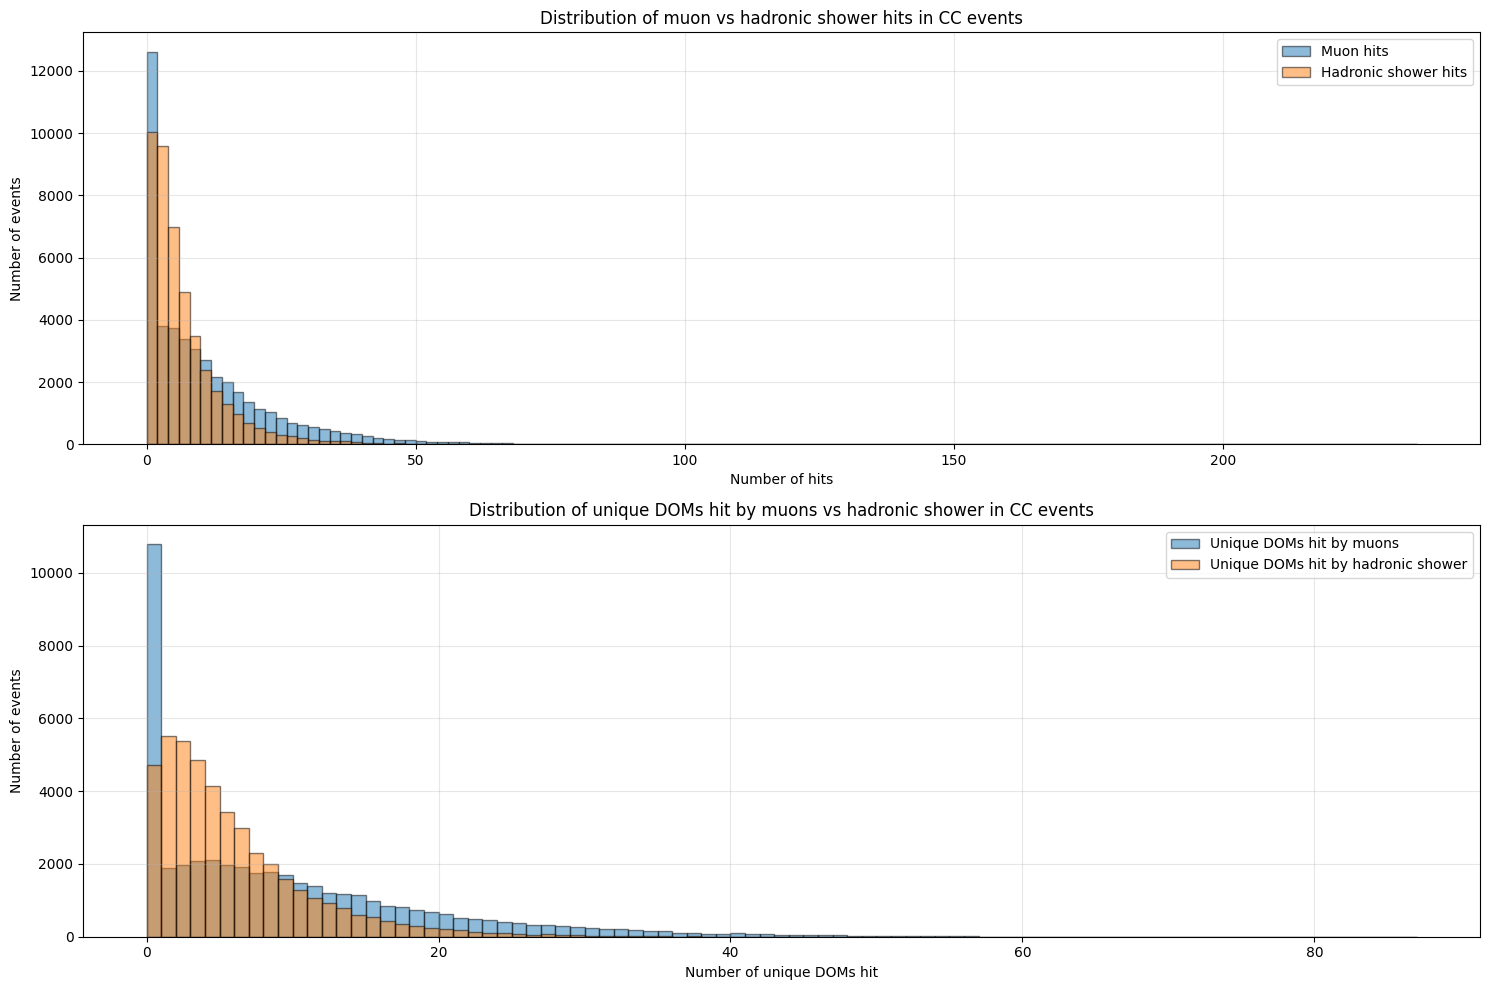

In [41]:

# Create histograms
plt.figure(figsize=(15, 10))

# Plot 1: Total hits distribution
plt.subplot(2, 1, 1)
max_hits = max(np.max(muon_hits_per_event), np.max(hadron_hits_per_event))
bins = np.arange(0, min(1000, max_hits + 10), 2)  # Cap at 1000 for visibility
plt.hist(muon_hits_per_event, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black')
plt.hist(hadron_hits_per_event, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
plt.xlabel('Number of hits')
plt.ylabel('Number of events')
plt.title('Distribution of muon vs hadronic shower hits in CC events')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Unique DOMs hit distribution
plt.subplot(2, 1, 2)
max_doms = max(np.max(unique_muon_doms_per_event), np.max(unique_hadron_doms_per_event))
bins = np.arange(0, min(100, max_doms + 5), 1)  # Cap at 100 for visibility
plt.hist(unique_muon_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
plt.hist(unique_hadron_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Number of events')
plt.title('Distribution of unique DOMs hit by muons vs hadronic shower in CC events')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'muon_vs_hadron_hits_cc_events.png'), dpi=300)
plt.show()


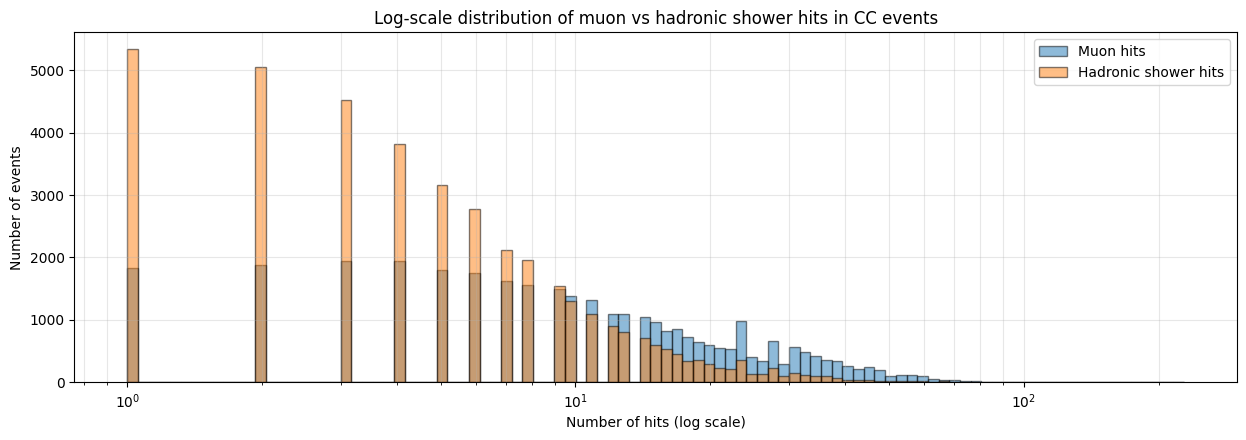

In [43]:

# Create additional logarithmic plots
plt.figure(figsize=(15, 10))

# Plot 1: Log-scale total hits distribution
plt.subplot(2, 1, 1)
log_bins = np.logspace(np.log10(max(1, min(np.min(muon_hits_per_event[muon_hits_per_event > 0]), 
                                         np.min(hadron_hits_per_event[hadron_hits_per_event > 0])))), 
                     np.log10(max(1, max_hits)), 100)
plt.hist(muon_hits_per_event, bins=log_bins, alpha=0.5, label='Muon hits', edgecolor='black')
plt.hist(hadron_hits_per_event, bins=log_bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
plt.xscale('log')
plt.xlabel('Number of hits (log scale)')
plt.ylabel('Number of events')
plt.title('Log-scale distribution of muon vs hadronic shower hits in CC events')
plt.legend()
plt.grid(alpha=0.3, which='both')


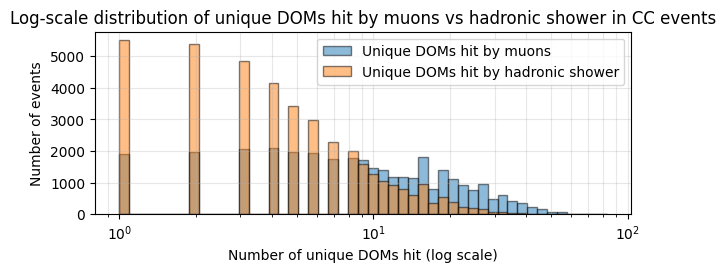

In [44]:

# Plot 2: Log-scale unique DOMs hit distribution
plt.subplot(2, 1, 2)
log_bins = np.logspace(np.log10(max(1, min(np.min(unique_muon_doms_per_event[unique_muon_doms_per_event > 0]), 
                                          np.min(unique_hadron_doms_per_event[unique_hadron_doms_per_event > 0])))), 
                     np.log10(max(1, max_doms)), 50)
plt.hist(unique_muon_doms_per_event, bins=log_bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
plt.hist(unique_hadron_doms_per_event, bins=log_bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
plt.xscale('log')
plt.xlabel('Number of unique DOMs hit (log scale)')
plt.ylabel('Number of events')
plt.title('Log-scale distribution of unique DOMs hit by muons vs hadronic shower in CC events')
plt.legend()
plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'muon_vs_hadron_hits_cc_events_log.png'), dpi=300)
plt.show()


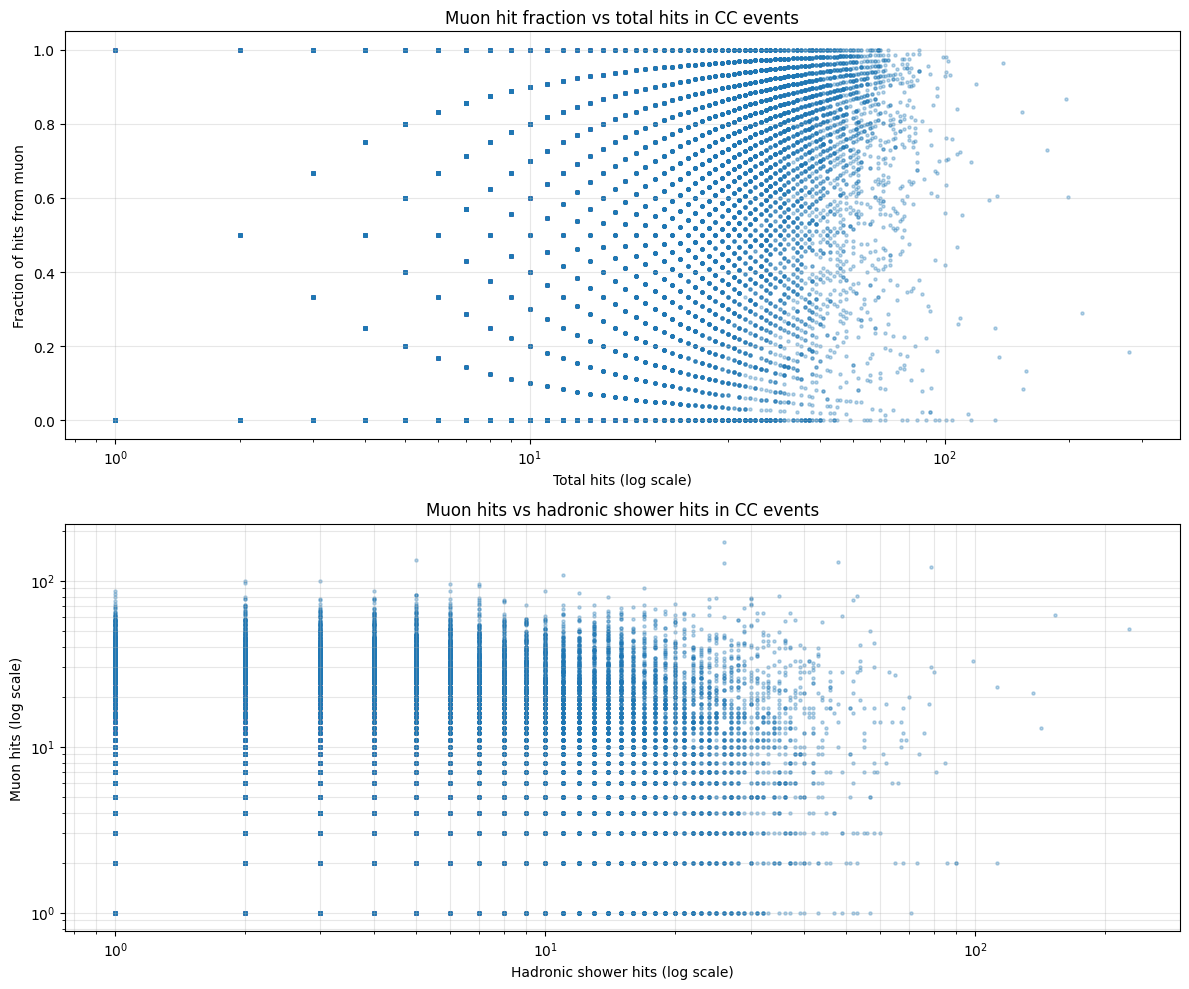

In [46]:

# Create scatter plot comparing muon hits vs hadronic hits per event
plt.figure(figsize=(12, 10))

# Plot ratio of muon hits to total hits vs total hits
plt.subplot(2, 1, 1)
total_hits = muon_hits_per_event + hadron_hits_per_event
muon_fraction = muon_hits_per_event / np.maximum(1, total_hits)  # Avoid division by zero

plt.scatter(total_hits, muon_fraction, alpha=0.3, s=5)
plt.xscale('log')
plt.xlabel('Total hits (log scale)')
plt.ylabel('Fraction of hits from muon')
plt.title('Muon hit fraction vs total hits in CC events')
plt.grid(alpha=0.3)

# Plot muon hits vs hadronic hits
plt.subplot(2, 1, 2)
plt.scatter(hadron_hits_per_event, muon_hits_per_event, alpha=0.3, s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hadronic shower hits (log scale)')
plt.ylabel('Muon hits (log scale)')
plt.title('Muon hits vs hadronic shower hits in CC events')
plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'muon_vs_hadron_comparison.png'), dpi=300)
plt.show()


In [48]:

# Now, let's also analyze timing for muon vs hadronic hits
# Lists to store all hit times for CC events
all_muon_hit_times = []
all_hadron_hit_times = []

# Process each CC event to collect timing information
print("\nAnalyzing timing characteristics of muon vs hadronic hits...")
for i, event_idx in enumerate(cc_indices):
    if i % 1000 == 0:  # Progress update
        print(f"Processing timing for CC event {i}/{len(cc_indices)}...")
    
    # Get the current event data
    event_data = combined_df.iloc[event_idx]
    
    # Process the event to add particle_type
    processed_event = process_event(event_data)
    
    # Get particle types and times for all hits in this event
    particle_types = processed_event['photons']['particle_type']
    hit_times = processed_event['photons']['t']
    
    # Identify muon hits and hadronic shower hits
    muon_mask = (particle_types == 13)
    hadron_mask = (particle_types != 13)
    
    # Collect hit times
    muon_times = hit_times[muon_mask]
    hadron_times = hit_times[hadron_mask]
    
    # Append to our collection arrays
    all_muon_hit_times.extend(muon_times)
    all_hadron_hit_times.extend(hadron_times)

# Convert to numpy arrays for histogram plotting
all_muon_hit_times = np.array(all_muon_hit_times)
all_hadron_hit_times = np.array(all_hadron_hit_times)

print(f"Collected {len(all_muon_hit_times)} muon hit times and {len(all_hadron_hit_times)} hadronic hit times")

# Create the timing histogram
plt.figure(figsize=(15, 10))

# Determine bin range covering both distributions
min_time = min(np.min(all_muon_hit_times) if len(all_muon_hit_times) > 0 else 0, 
               np.min(all_hadron_hit_times) if len(all_hadron_hit_times) > 0 else 0)
max_time = max(np.max(all_muon_hit_times) if len(all_muon_hit_times) > 0 else 3000, 
               np.max(all_hadron_hit_times) if len(all_hadron_hit_times) > 0 else 3000)



Analyzing timing characteristics of muon vs hadronic hits...
Processing timing for CC event 0/44502...
Processing timing for CC event 1000/44502...
Processing timing for CC event 2000/44502...
Processing timing for CC event 3000/44502...
Processing timing for CC event 4000/44502...
Processing timing for CC event 5000/44502...
Processing timing for CC event 6000/44502...
Processing timing for CC event 7000/44502...
Processing timing for CC event 8000/44502...
Processing timing for CC event 9000/44502...
Processing timing for CC event 10000/44502...
Processing timing for CC event 11000/44502...
Processing timing for CC event 12000/44502...
Processing timing for CC event 13000/44502...
Processing timing for CC event 14000/44502...
Processing timing for CC event 15000/44502...
Processing timing for CC event 16000/44502...
Processing timing for CC event 17000/44502...
Processing timing for CC event 18000/44502...
Processing timing for CC event 19000/44502...
Processing timing for CC event 

<Figure size 1500x1000 with 0 Axes>

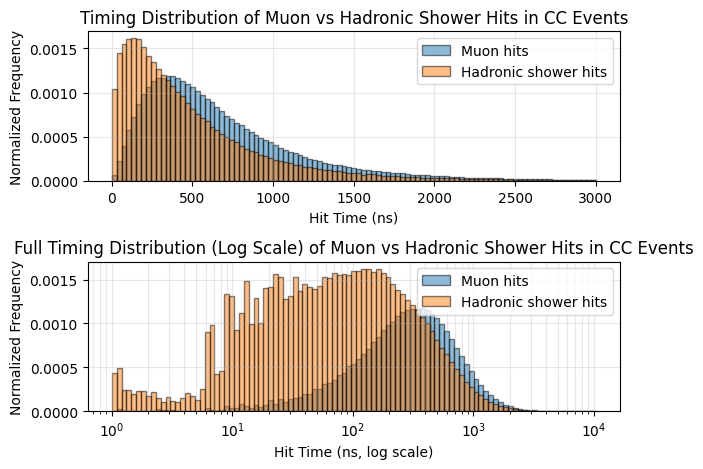


Timing Statistics:
Muon hits - Mean time: 701.32 ns, Median: 557.57 ns
Hadronic hits - Mean time: 505.96 ns, Median: 358.83 ns


In [49]:

# Plot 1: Linear time scale
plt.subplot(2, 1, 1)
# Sample if there are too many hit times to plot
if len(all_muon_hit_times) > 1000000:
    all_muon_hit_times_sample = np.random.choice(all_muon_hit_times, size=1000000, replace=False)
else:
    all_muon_hit_times_sample = all_muon_hit_times
    
if len(all_hadron_hit_times) > 1000000:
    all_hadron_hit_times_sample = np.random.choice(all_hadron_hit_times, size=1000000, replace=False)
else:
    all_hadron_hit_times_sample = all_hadron_hit_times

bins = np.linspace(min_time, min(3000, max_time), 100)  # Focus on first 3000 ns
plt.hist(all_muon_hit_times_sample, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black', density=True)
plt.hist(all_hadron_hit_times_sample, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black', density=True)
plt.xlabel('Hit Time (ns)')
plt.ylabel('Normalized Frequency')
plt.title('Timing Distribution of Muon vs Hadronic Shower Hits in CC Events')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Log time scale for full range
plt.subplot(2, 1, 2)
log_bins = np.logspace(np.log10(max(1, min_time)), np.log10(max_time), 100)
plt.hist(all_muon_hit_times_sample, bins=log_bins, alpha=0.5, label='Muon hits', edgecolor='black', density=True)
plt.hist(all_hadron_hit_times_sample, bins=log_bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black', density=True)
plt.xscale('log')
plt.xlabel('Hit Time (ns, log scale)')
plt.ylabel('Normalized Frequency')
plt.title('Full Timing Distribution (Log Scale) of Muon vs Hadronic Shower Hits in CC Events')
plt.legend()
plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'muon_vs_hadron_timing_cc_events.png'), dpi=300)
plt.show()

# Print timing statistics
print("\nTiming Statistics:")
print(f"Muon hits - Mean time: {np.mean(all_muon_hit_times):.2f} ns, Median: {np.median(all_muon_hit_times):.2f} ns")
print(f"Hadronic hits - Mean time: {np.mean(all_hadron_hit_times):.2f} ns, Median: {np.median(all_hadron_hit_times):.2f} ns")

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve, auc)
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Find all CC events
cc_mask = []
for idx, row in combined_df.iterrows():
    cc_mask.append(row['mc_truth']['interaction'] == 1)

cc_indices = np.where(cc_mask)[0]
print(f"Found {len(cc_indices)} CC events")


Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Found 44502 CC events


In [52]:

# Function to process a single event and get features for each hit
def extract_hit_features(event_data):
    try:
        # Get photon data
        photons = event_data['photons']
        
        # Get hit times
        hit_times = photons['t']
        
        # Get positions
        pos_x = photons['sensor_pos_x']
        pos_y = photons['sensor_pos_y']
        pos_z = photons['sensor_pos_z']
        
        # Get string/sensor IDs
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        
        # Get the id_idx array for mapping to particle types
        id_idx_array = photons['id_idx']
        
        # Get the final_state_type array from mc_truth
        final_state_types = event_data['mc_truth']['final_state_type']
        
        # Map id_idx to final_state_type to determine particle type for each hit
        # (1 for muon hits, 0 for hadronic shower hits)
        labels = []
        for idx in id_idx_array:
            if idx > 0 and idx <= len(final_state_types):
                pdg_code = final_state_types[idx-1]
                labels.append(1 if pdg_code == 13 else 0)  # 1 for muon, 0 for hadronic
            else:
                labels.append(0)  # Default to hadronic if mapping fails
        
        # Calculate additional features
        
        # 1. Time features
        # Calculate mean time of all hits in the event
        mean_time = np.mean(hit_times)
        # Time relative to mean
        rel_times = hit_times - mean_time
        
        # 2. Position features
        # Event center (weighted by hit times to capture propagation direction)
        center_x = np.mean(pos_x)
        center_y = np.mean(pos_y)
        center_z = np.mean(pos_z)
        
        # Distance from center
        r_from_center = np.sqrt((pos_x - center_x)**2 + 
                                (pos_y - center_y)**2 + 
                                (pos_z - center_z)**2)
        
        # Create feature array for each hit
        features = []
        for i in range(len(hit_times)):
            # Basic features
            hit_feature = {
                'time': hit_times[i],
                'rel_time': rel_times[i],
                'pos_x': pos_x[i],
                'pos_y': pos_y[i],
                'pos_z': pos_z[i],
                'r_from_center': r_from_center[i],
                'string_id': string_ids[i],
                'sensor_id': sensor_ids[i],
                'label': labels[i]  # 1 for muon, 0 for hadronic
            }
            features.append(hit_feature)
        
        return features
    except Exception as e:
        print(f"Error processing event: {e}")
        return []

# Collect hit features from CC events
print("Extracting hit features from CC events...")
all_hit_features = []


Extracting hit features from CC events...


In [53]:

# Limit the number of events to process to avoid memory issues
max_events_to_process = 1000
events_to_process = min(max_events_to_process, len(cc_indices))
print(f"Processing {events_to_process} out of {len(cc_indices)} CC events")

for i in range(events_to_process):
    event_idx = cc_indices[i]
    if i % 100 == 0:  # Progress update
        print(f"Processing event {i}/{events_to_process}...")
    
    # Get the current event data
    event_data = combined_df.iloc[event_idx]
    
    # Extract features for each hit
    hit_features = extract_hit_features(event_data)
    all_hit_features.extend(hit_features)

print(f"Collected features for {len(all_hit_features)} hits")

# Convert to DataFrame for easier handling
hit_df = pd.DataFrame(all_hit_features)

# Check class balance
muon_count = np.sum(hit_df['label'] == 1)
hadron_count = np.sum(hit_df['label'] == 0)
print(f"Class balance: {muon_count} muon hits ({muon_count/len(hit_df)*100:.1f}%), {hadron_count} hadronic hits ({hadron_count/len(hit_df)*100:.1f}%)")


Processing 1000 out of 44502 CC events
Processing event 0/1000...
Processing event 100/1000...
Processing event 200/1000...
Processing event 300/1000...
Processing event 400/1000...
Processing event 500/1000...
Processing event 600/1000...
Processing event 700/1000...
Processing event 800/1000...
Processing event 900/1000...
Collected features for 16576 hits
Class balance: 10203 muon hits (61.6%), 6373 hadronic hits (38.4%)


/groups/icecube/jackp/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/groups/icecube/jackp/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training set: 11603 hits, Test set: 4973 hits
Training BDT classifier...

Model Performance:
Accuracy: 0.6964
Precision: 0.7033
Recall: 0.8700
F1 Score: 0.7778
AUC-ROC: 0.7279

Classification Report:
              precision    recall  f1-score   support

Hadronic Hit       0.67      0.42      0.52      1935
    Muon Hit       0.70      0.87      0.78      3038

    accuracy                           0.70      4973
   macro avg       0.69      0.65      0.65      4973
weighted avg       0.69      0.70      0.68      4973



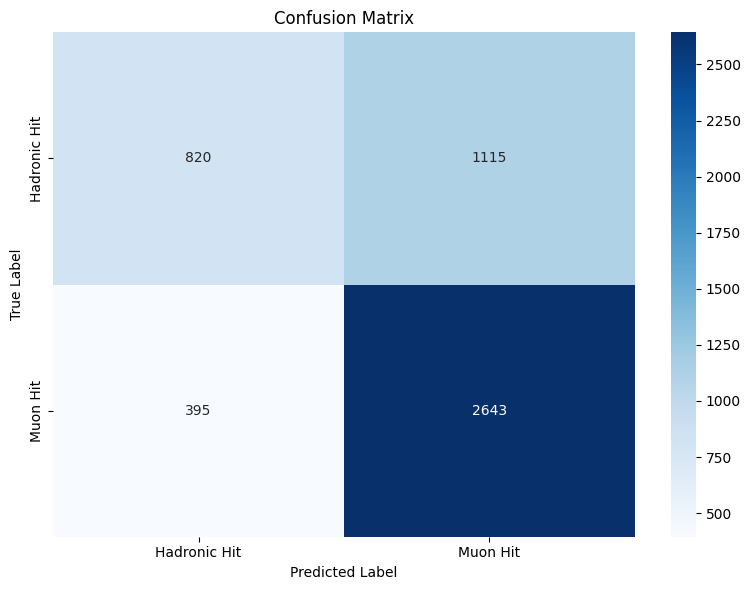

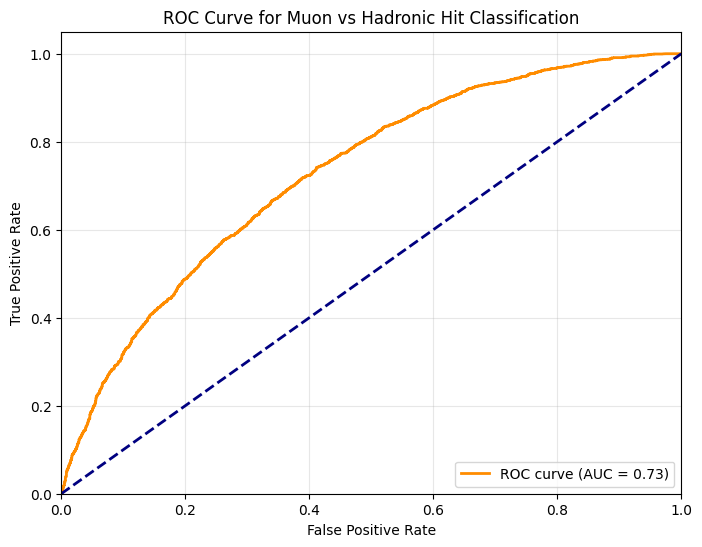

In [54]:

# Prepare features and labels
X = hit_df[['time', 'rel_time', 'pos_x', 'pos_y', 'pos_z', 'r_from_center', 'string_id', 'sensor_id']]
y = hit_df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} hits, Test set: {X_test.shape[0]} hits")

# Train BDT classifier
print("Training BDT classifier...")
bdt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

bdt.fit(X_train, y_train)

# Get predicted probabilities (logit scores)
y_prob = bdt.predict_proba(X_test)[:, 1]  # Probability of being a muon hit
y_pred = bdt.predict(X_test)

# Evaluate model
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")  # How many predicted muon hits are actually muons
print(f"Recall: {recall_score(y_test, y_pred):.4f}")  # How many actual muon hits are correctly identified
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Hadronic Hit', 'Muon Hit']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Hadronic Hit', 'Muon Hit'], 
            yticklabels=['Hadronic Hit', 'Muon Hit'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'hit_classification_cm.png'), dpi=300)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Muon vs Hadronic Hit Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'hit_classification_roc.png'), dpi=300)
plt.show()


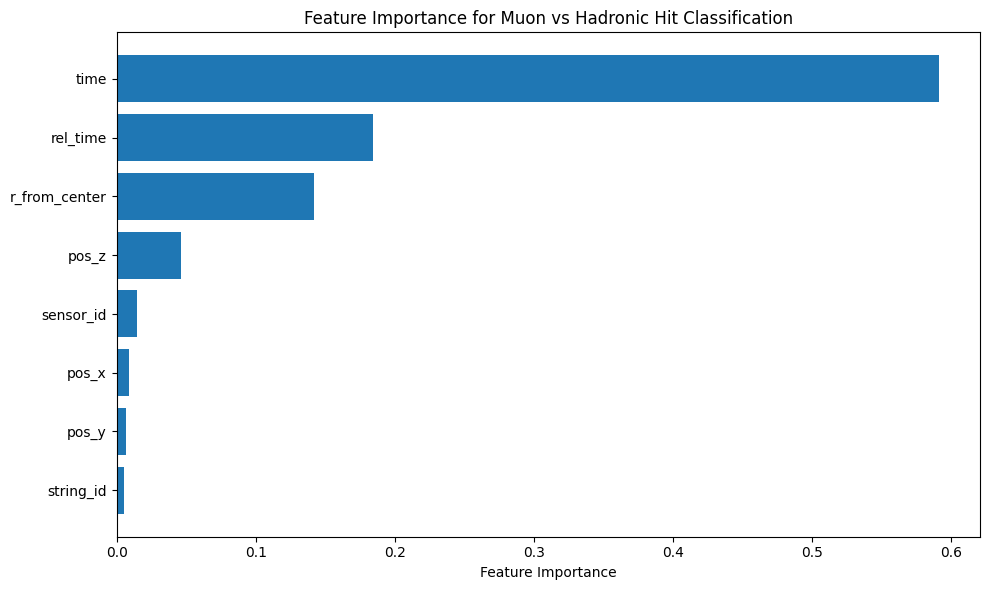

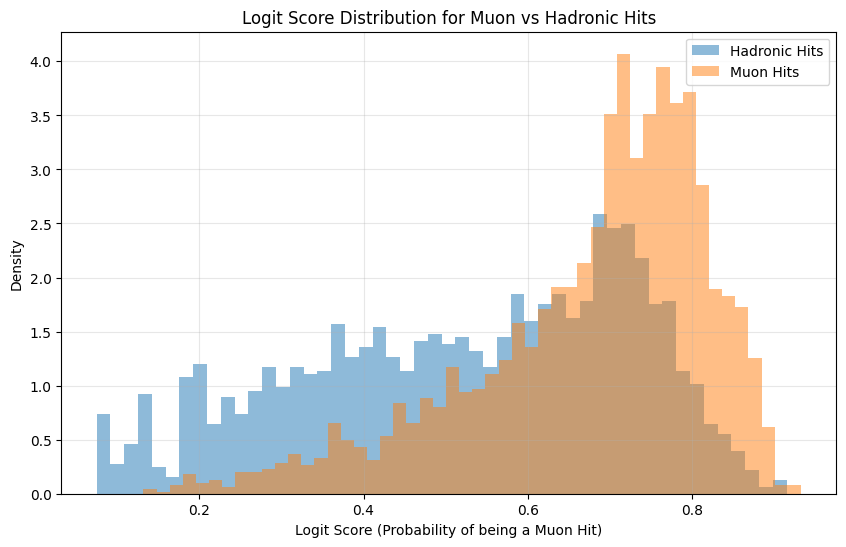


Optimal classification threshold: 0.6095
At this threshold - True Positive Rate: 0.7419, False Positive Rate: 0.4124


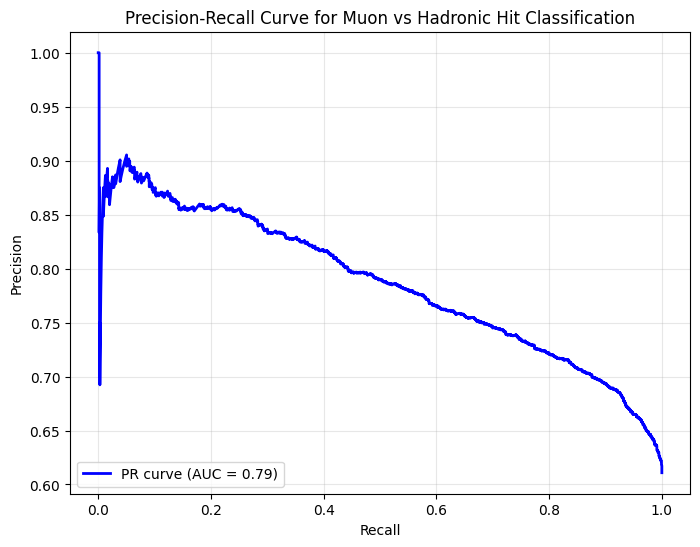


Logit Score Statistics:
Muon hits: Mean = 0.6770, Std = 0.1456
Hadronic hits: Mean = 0.5257, Std = 0.1998


In [55]:

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = bdt.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Muon vs Hadronic Hit Classification')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'hit_classification_features.png'), dpi=300)
plt.show()

# Plot logit score distribution
plt.figure(figsize=(10, 6))
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.5, label='Hadronic Hits', density=True)
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.5, label='Muon Hits', density=True)
plt.xlabel('Logit Score (Probability of being a Muon Hit)')
plt.ylabel('Density')
plt.title('Logit Score Distribution for Muon vs Hadronic Hits')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'hit_classification_logit.png'), dpi=300)
plt.show()

# Find optimal threshold using Youden's J statistic (maximizing TPR - FPR)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal classification threshold: {optimal_threshold:.4f}")
print(f"At this threshold - True Positive Rate: {tpr[optimal_idx]:.4f}, False Positive Rate: {fpr[optimal_idx]:.4f}")

# Precision-Recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Muon vs Hadronic Hit Classification')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'hit_classification_pr.png'), dpi=300)
plt.show()

# Calculate logit score statistics for each class
muon_logit_mean = np.mean(y_prob[y_test == 1])
muon_logit_std = np.std(y_prob[y_test == 1])
hadron_logit_mean = np.mean(y_prob[y_test == 0])
hadron_logit_std = np.std(y_prob[y_test == 0])

print("\nLogit Score Statistics:")
print(f"Muon hits: Mean = {muon_logit_mean:.4f}, Std = {muon_logit_std:.4f}")
print(f"Hadronic hits: Mean = {hadron_logit_mean:.4f}, Std = {hadron_logit_std:.4f}")

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve, auc)
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Find all CC events
cc_mask = []
for idx, row in combined_df.iterrows():
    cc_mask.append(row['mc_truth']['interaction'] == 1)

cc_indices = np.where(cc_mask)[0]
print(f"Found {len(cc_indices)} CC events")

# Function to process a single event and get features for each hit
def extract_hit_features(event_data):
    try:
        # Get photon data
        photons = event_data['photons']
        
        # Skip if there are no hits
        if len(photons['t']) == 0:
            return []
        
        # Get hit times
        hit_times = photons['t']
        
        # Get positions
        pos_x = photons['sensor_pos_x']
        pos_y = photons['sensor_pos_y']
        pos_z = photons['sensor_pos_z']
        
        # Get string/sensor IDs
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        
        # Get the id_idx array for mapping to particle types
        id_idx_array = photons['id_idx']
        
        # Get the final_state_type array from mc_truth
        final_state_types = event_data['mc_truth']['final_state_type']
        
        # Map id_idx to final_state_type to determine particle type for each hit
        # (1 for muon hits, 0 for hadronic shower hits)
        labels = []
        for idx in id_idx_array:
            if idx > 0 and idx <= len(final_state_types):
                pdg_code = final_state_types[idx-1]
                labels.append(1 if pdg_code == 13 else 0)  # 1 for muon, 0 for hadronic
            else:
                labels.append(0)  # Default to hadronic if mapping fails
        
        # Calculate additional features
        
        # 1. Time features
        # Calculate mean time of all hits in the event
        mean_time = np.mean(hit_times)
        # Time relative to mean
        rel_times = hit_times - mean_time
        
        # 2. Position features
        # Event center (weighted by hit times to capture propagation direction)
        center_x = np.mean(pos_x)
        center_y = np.mean(pos_y)
        center_z = np.mean(pos_z)
        
        # Distance from center
        r_from_center = np.sqrt((pos_x - center_x)**2 + 
                                (pos_y - center_y)**2 + 
                                (pos_z - center_z)**2)
        
        # Create feature array for each hit
        features = []
        for i in range(len(hit_times)):
            # Basic features
            hit_feature = {
                'time': hit_times[i],
                'rel_time': rel_times[i],
                'pos_x': pos_x[i],
                'pos_y': pos_y[i],
                'pos_z': pos_z[i],
                'r_from_center': r_from_center[i],
                'string_id': string_ids[i],
                'sensor_id': sensor_ids[i],
                'label': labels[i]  # 1 for muon, 0 for hadronic
            }
            features.append(hit_feature)
        
        return features
    except Exception as e:
        print(f"Error processing event: {e}")
        return []

# Collect hit features from CC events
print("Extracting hit features from CC events...")
all_hit_features = []
hit_count = 0
cc_event_count = 0


Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Found 44502 CC events
Extracting hit features from CC events...


In [57]:

# Process more events, but sample hits within events if needed to avoid memory issues
max_events_to_process = 5000  # Process more events
max_hits_per_event = 200  # Limit hits per event to avoid memory issues
max_total_hits = 1000000  # Cap total hits to avoid memory issues

for i, event_idx in enumerate(cc_indices):
    if i >= max_events_to_process:
        break
        
    if i % 100 == 0:  # Progress update
        print(f"Processing event {i}/{min(max_events_to_process, len(cc_indices))}...")
    
    # Get the current event data
    event_data = combined_df.iloc[event_idx]
    
    # Extract features for each hit
    hit_features = extract_hit_features(event_data)
    
    # If this event has too many hits, sample randomly
    if len(hit_features) > max_hits_per_event:
        selected_indices = np.random.choice(len(hit_features), max_hits_per_event, replace=False)
        hit_features = [hit_features[j] for j in selected_indices]
    
    # Add hit features to collection
    all_hit_features.extend(hit_features)
    hit_count += len(hit_features)
    cc_event_count += 1
    
    # Check if we've reached the maximum total hits
    if hit_count >= max_total_hits:
        print(f"Reached maximum hit count of {max_total_hits}. Stopping collection.")
        break

print(f"Collected features for {len(all_hit_features)} hits from {cc_event_count} CC events")


Processing event 0/5000...
Processing event 100/5000...
Processing event 200/5000...
Processing event 300/5000...
Processing event 400/5000...
Processing event 500/5000...
Processing event 600/5000...
Processing event 700/5000...
Processing event 800/5000...
Processing event 900/5000...
Processing event 1000/5000...
Processing event 1100/5000...
Processing event 1200/5000...
Processing event 1300/5000...
Processing event 1400/5000...
Processing event 1500/5000...
Processing event 1600/5000...
Processing event 1700/5000...
Processing event 1800/5000...
Processing event 1900/5000...
Processing event 2000/5000...
Processing event 2100/5000...
Processing event 2200/5000...
Processing event 2300/5000...
Processing event 2400/5000...
Processing event 2500/5000...
Processing event 2600/5000...
Processing event 2700/5000...
Processing event 2800/5000...
Processing event 2900/5000...
Processing event 3000/5000...
Processing event 3100/5000...
Processing event 3200/5000...
Processing event 3300/

Class balance: 49899 muon hits (60.8%), 32218 hadronic hits (39.2%)
Training set: 57481 hits, Test set: 24636 hits
Training BDT classifier...

Model Performance:
Accuracy: 0.6837
Precision: 0.6909
Recall: 0.8641
F1 Score: 0.7678
AUC-ROC: 0.7127

Classification Report:
              precision    recall  f1-score   support

Hadronic Hit       0.66      0.41      0.50      9726
    Muon Hit       0.69      0.86      0.77     14910

    accuracy                           0.68     24636
   macro avg       0.68      0.64      0.64     24636
weighted avg       0.68      0.68      0.66     24636



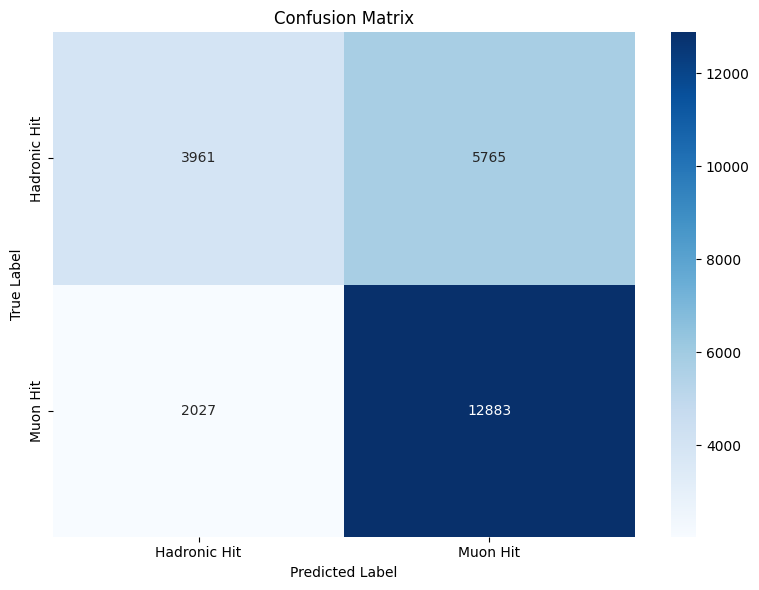

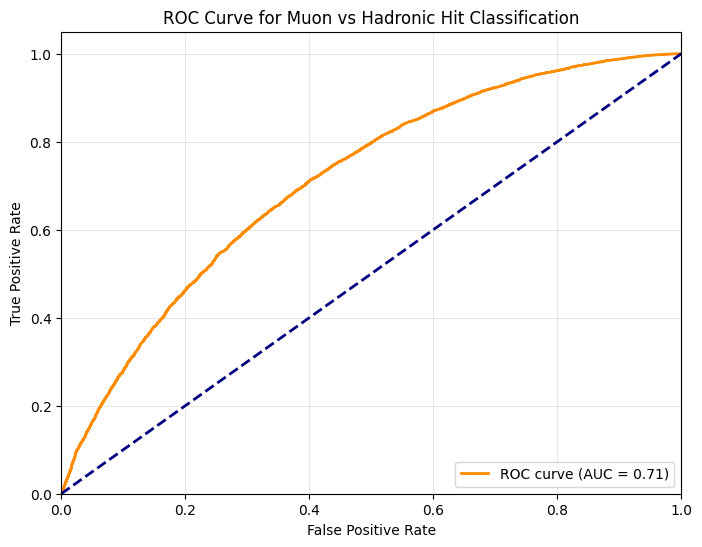

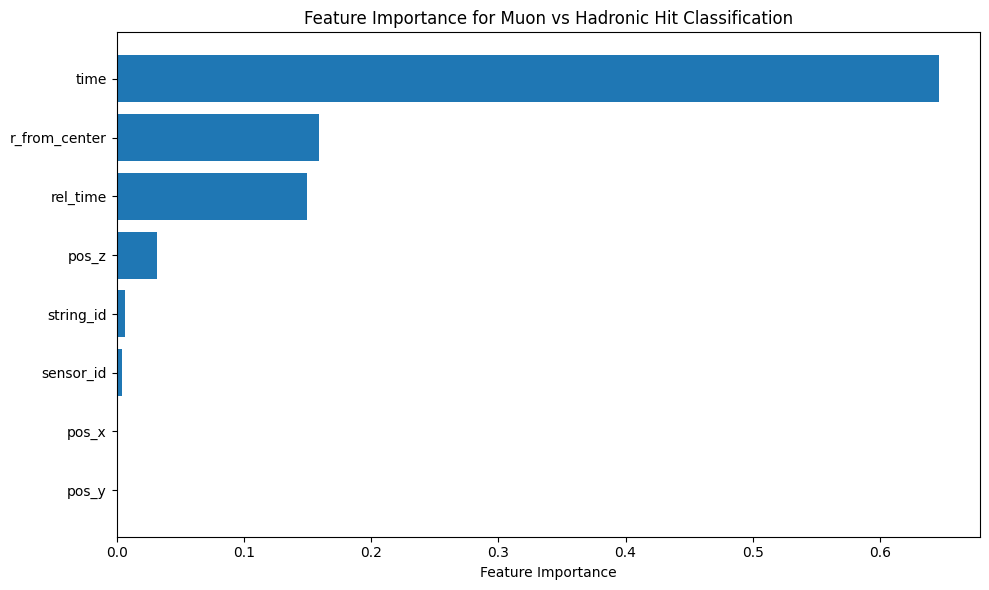

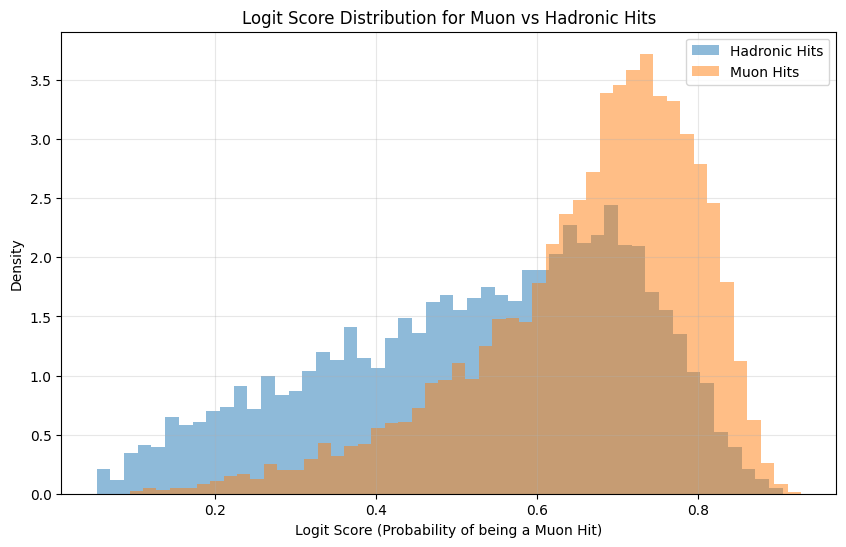


Optimal classification threshold: 0.6103
At this threshold - True Positive Rate: 0.7129, False Positive Rate: 0.4013


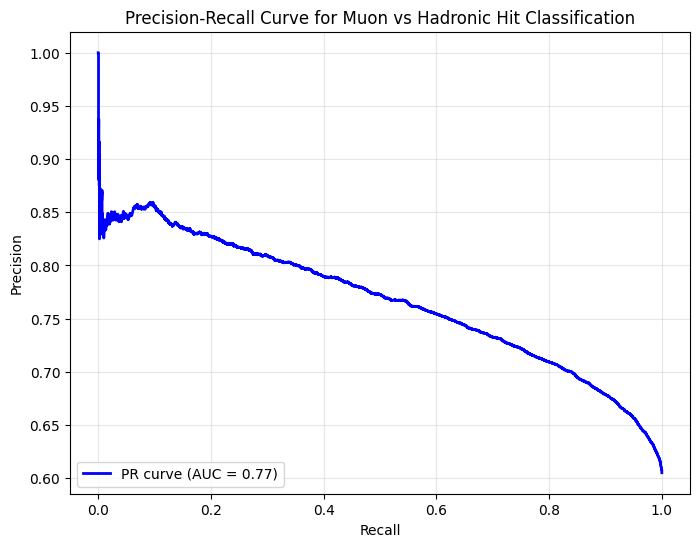


Logit Score Statistics:
Muon hits: Mean = 0.6614, Std = 0.1400
Hadronic hits: Mean = 0.5280, Std = 0.1890


In [58]:

# Convert to DataFrame for easier handling
hit_df = pd.DataFrame(all_hit_features)

# Check class balance
muon_count = np.sum(hit_df['label'] == 1)
hadron_count = np.sum(hit_df['label'] == 0)
print(f"Class balance: {muon_count} muon hits ({muon_count/len(hit_df)*100:.1f}%), {hadron_count} hadronic hits ({hadron_count/len(hit_df)*100:.1f}%)")

# Prepare features and labels
X = hit_df[['time', 'rel_time', 'pos_x', 'pos_y', 'pos_z', 'r_from_center', 'string_id', 'sensor_id']]
y = hit_df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} hits, Test set: {X_test.shape[0]} hits")

# Train BDT classifier
print("Training BDT classifier...")
bdt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

bdt.fit(X_train, y_train)

# Get predicted probabilities (logit scores)
y_prob = bdt.predict_proba(X_test)[:, 1]  # Probability of being a muon hit
y_pred = bdt.predict(X_test)

# Evaluate model
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")  # How many predicted muon hits are actually muons
print(f"Recall: {recall_score(y_test, y_pred):.4f}")  # How many actual muon hits are correctly identified
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Hadronic Hit', 'Muon Hit']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Hadronic Hit', 'Muon Hit'], 
            yticklabels=['Hadronic Hit', 'Muon Hit'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'hit_classification_cm.png'), dpi=300)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Muon vs Hadronic Hit Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'hit_classification_roc.png'), dpi=300)
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = bdt.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Muon vs Hadronic Hit Classification')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'hit_classification_features.png'), dpi=300)
plt.show()

# Plot logit score distribution
plt.figure(figsize=(10, 6))
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.5, label='Hadronic Hits', density=True)
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.5, label='Muon Hits', density=True)
plt.xlabel('Logit Score (Probability of being a Muon Hit)')
plt.ylabel('Density')
plt.title('Logit Score Distribution for Muon vs Hadronic Hits')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'hit_classification_logit.png'), dpi=300)
plt.show()

# Find optimal threshold using Youden's J statistic (maximizing TPR - FPR)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal classification threshold: {optimal_threshold:.4f}")
print(f"At this threshold - True Positive Rate: {tpr[optimal_idx]:.4f}, False Positive Rate: {fpr[optimal_idx]:.4f}")

# Precision-Recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Muon vs Hadronic Hit Classification')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'hit_classification_pr.png'), dpi=300)
plt.show()

# Calculate logit score statistics for each class
muon_logit_mean = np.mean(y_prob[y_test == 1])
muon_logit_std = np.std(y_prob[y_test == 1])
hadron_logit_mean = np.mean(y_prob[y_test == 0])
hadron_logit_std = np.std(y_prob[y_test == 0])

print("\nLogit Score Statistics:")
print(f"Muon hits: Mean = {muon_logit_mean:.4f}, Std = {muon_logit_std:.4f}")
print(f"Hadronic hits: Mean = {hadron_logit_mean:.4f}, Std = {hadron_logit_std:.4f}")

Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Extracting features for CC/NC classification...
Processing event 0/60000...
Processing event 1000/60000...
Processing event 2000/60000...
Processing event 3000/60000...
Processing event 4000/60000...
Processing event 5000/60000...
Processing event 6000/60000...
Processing event 7000/60000...
Processing event 8000/60000...
Processing event 9000/60000...
Processing event 10000/60000...
Processing event 11000/60000...
Processing event 12000/60000...
Processing event 13000/60000...
Processing event 14000/60000...
Processing event 15000/60000...
Processing event 16000/60000...
Processing event 17000/60000...
Processing event 18000/60000...
Processing event 19000/60000...
Processing event 20000/60000...
Processing event 21000/60000...
Processing event 22000/60000...
Processing event 23000/60000...
Processing event 24000/60000...
Processing event 25000/60000...
Processing event 26000/6000

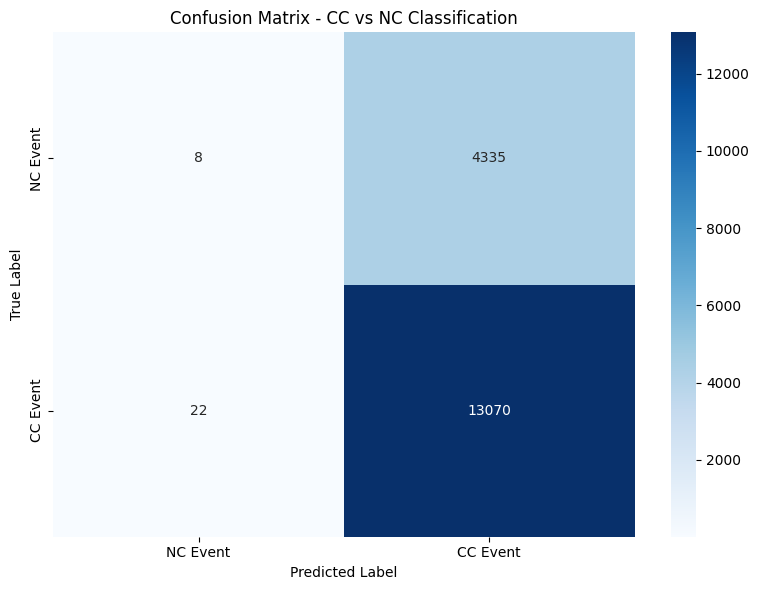

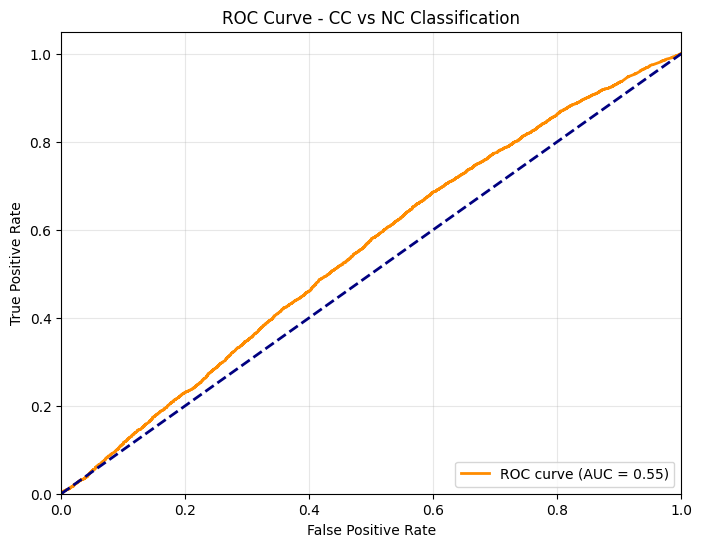

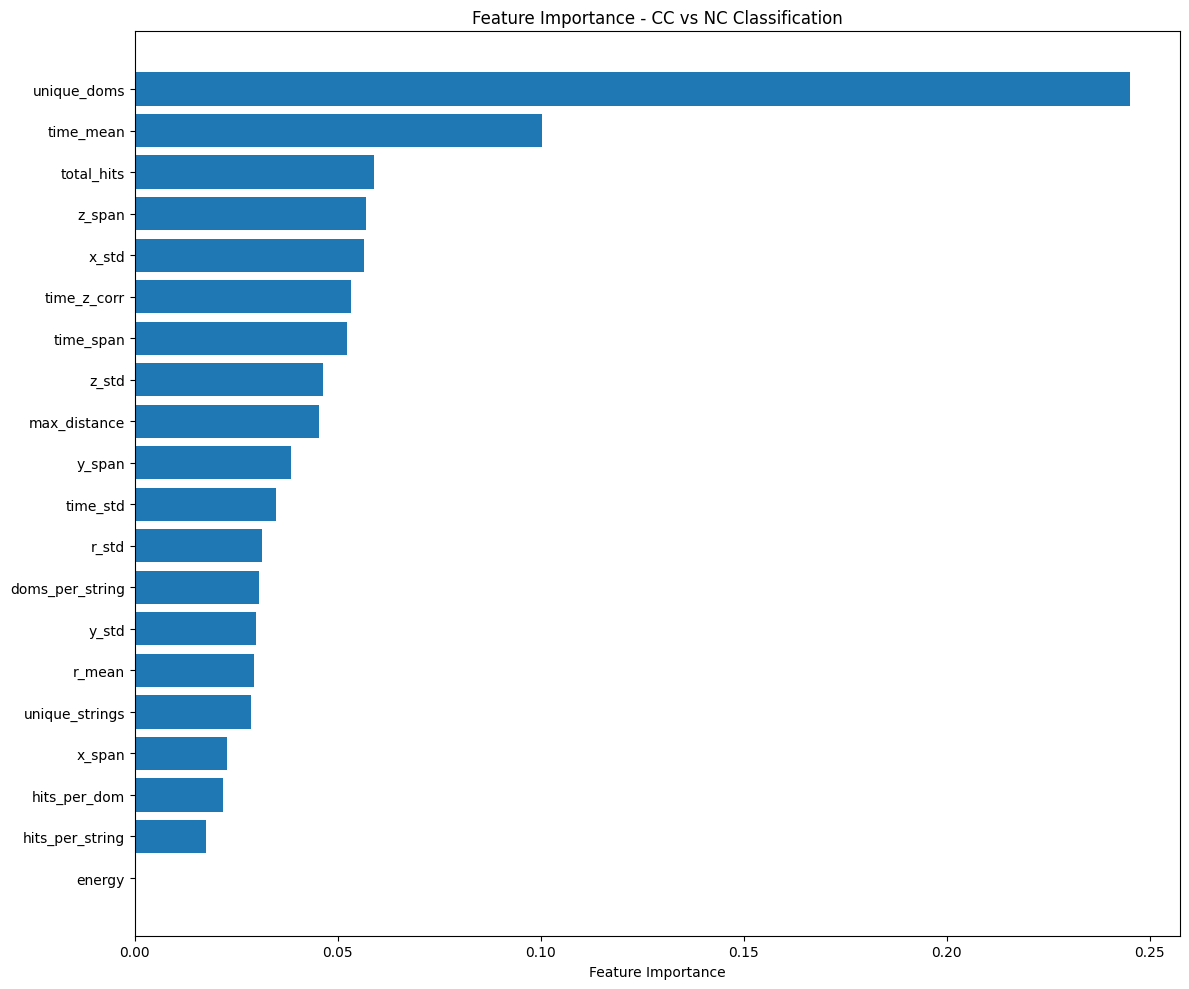

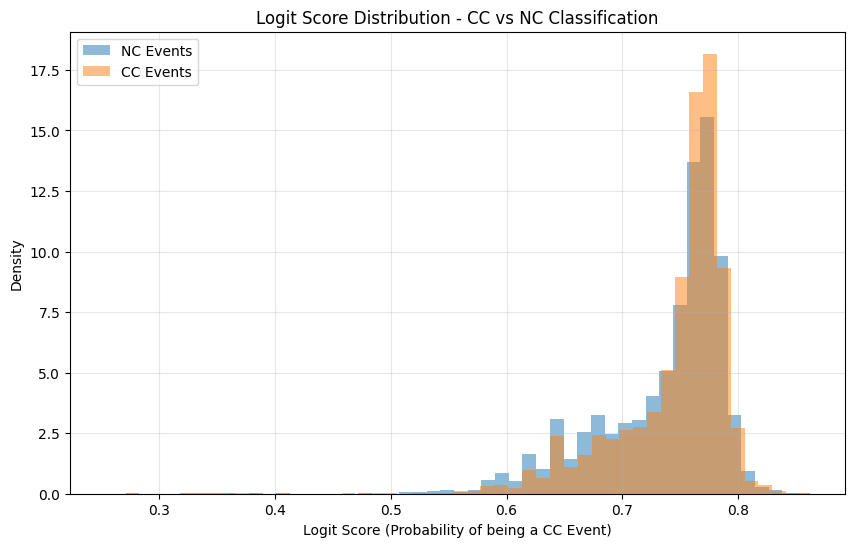


Optimal classification threshold: 0.7449
At this threshold - True Positive Rate: 0.6842, False Positive Rate: 0.5977


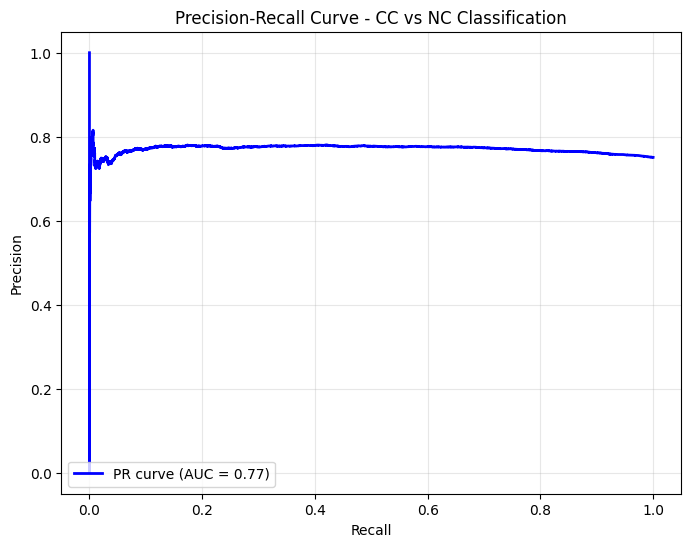

/tmp/ipykernel_1054228/354180705.py:285: RuntimeWarning: divide by zero encountered in log10
  energy_bins = np.logspace(np.log10(min(event_df['energy'])), np.log10(max(event_df['energy'])), 10)
/groups/icecube/jackp/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start


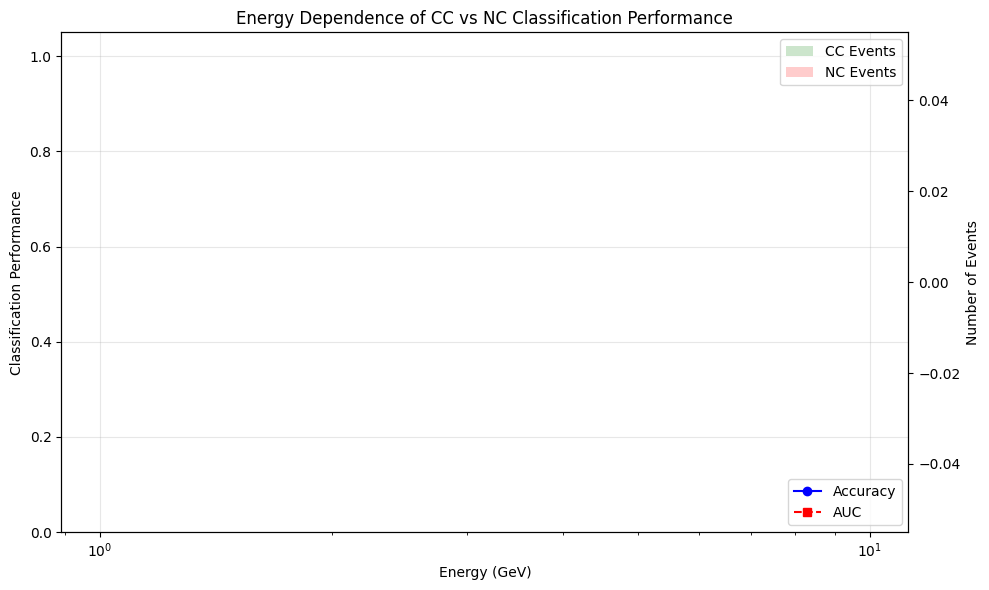


Logit Score Statistics:
CC events: Mean = 0.7458, Std = 0.0481
NC events: Mean = 0.7362, Std = 0.0554


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve, auc)
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Function to extract event-level features for classification
def extract_event_features(event_data):
    try:
        # Get interaction type (1 for CC, 2 for NC)
        interaction_type = event_data['mc_truth']['interaction']
        
        # Label: 1 for CC, 0 for NC
        label = 1 if interaction_type == 1 else 0
        
        # Get photon data
        photons = event_data['photons']
        
        # Skip events with no hits
        if len(photons['t']) == 0:
            return None
        
        # 1. Hit count features
        total_hits = len(photons['t'])
        
        # 2. Unique DOM features
        unique_doms = len(set(zip(photons['string_id'], photons['sensor_id'])))
        
        # 3. Spatial features
        pos_x = photons['sensor_pos_x']
        pos_y = photons['sensor_pos_y']
        pos_z = photons['sensor_pos_z']
        
        # Calculate spatial extent
        x_span = np.max(pos_x) - np.min(pos_x)
        y_span = np.max(pos_y) - np.min(pos_y)
        z_span = np.max(pos_z) - np.min(pos_z)
        
        # Calculate standard deviations
        x_std = np.std(pos_x)
        y_std = np.std(pos_y)
        z_std = np.std(pos_z)
        
        # Calculate maximum distance between any two hit DOMs
        positions = np.vstack((pos_x, pos_y, pos_z)).T
        if len(positions) > 1:
            from scipy.spatial.distance import pdist
            max_distance = np.max(pdist(positions))
        else:
            max_distance = 0
        
        # 4. Timing features
        hit_times = photons['t']
        time_span = np.max(hit_times) - np.min(hit_times)
        time_mean = np.mean(hit_times)
        time_std = np.std(hit_times)
        
        # 5. Topology features
        unique_strings = len(np.unique(photons['string_id']))
        hits_per_string = total_hits / max(1, unique_strings)
        doms_per_string = unique_doms / max(1, unique_strings)
        
        # 6. Event-shape features
        # Calculate center of the event
        center_x = np.mean(pos_x)
        center_y = np.mean(pos_y)
        center_z = np.mean(pos_z)
        
        # Calculate distances from center
        r_squared = (pos_x - center_x)**2 + (pos_y - center_y)**2 + (pos_z - center_z)**2
        r_mean = np.mean(np.sqrt(r_squared))
        r_std = np.std(np.sqrt(r_squared))
        
        # 7. Correlations between space and time
        # Normalize position and time
        z_norm = (pos_z - np.mean(pos_z)) / (np.std(pos_z) + 1e-6)
        t_norm = (hit_times - np.mean(hit_times)) / (np.std(hit_times) + 1e-6)
        
        # Calculate correlation coefficient (should be higher for track-like events)
        time_z_corr = np.mean(z_norm * t_norm) if len(z_norm) > 1 else 0
        
        # 8. Energy features if available
        energy = event_data['mc_truth'].get('primary_energy', 0)
        
        # Create feature dictionary
        features = {
            # Basic count features
            'total_hits': total_hits,
            'unique_doms': unique_doms,
            'hits_per_dom': total_hits / max(1, unique_doms),
            
            # Spatial features
            'x_span': x_span,
            'y_span': y_span,
            'z_span': z_span,
            'x_std': x_std,
            'y_std': y_std,
            'z_std': z_std,
            'max_distance': max_distance,
            
            # Timing features
            'time_span': time_span,
            'time_mean': time_mean,
            'time_std': time_std,
            
            # Topology features
            'unique_strings': unique_strings,
            'hits_per_string': hits_per_string,
            'doms_per_string': doms_per_string,
            
            # Shape features
            'r_mean': r_mean,
            'r_std': r_std,
            
            # Correlation features
            'time_z_corr': time_z_corr,
            
            # Energy features
            'energy': energy,
            
            # Label
            'label': label
        }
        
        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# Extract features for all events
print("Extracting features for CC/NC classification...")
all_event_features = []

# Process all events
for i, (idx, event_data) in enumerate(combined_df.iterrows()):
    if i % 1000 == 0:  # Progress update
        print(f"Processing event {i}/{len(combined_df)}...")
    
    # Extract features
    features = extract_event_features(event_data)
    if features is not None:
        all_event_features.append(features)

print(f"Extracted features for {len(all_event_features)} events")

# Convert to DataFrame
event_df = pd.DataFrame(all_event_features)

# Check class balance
cc_count = np.sum(event_df['label'] == 1)
nc_count = np.sum(event_df['label'] == 0)
print(f"Class balance: {cc_count} CC events ({cc_count/len(event_df)*100:.1f}%), {nc_count} NC events ({nc_count/len(event_df)*100:.1f}%)")

# Prepare features and labels
X = event_df.drop('label', axis=1)
y = event_df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} events, Test set: {X_test.shape[0]} events")

# Train BDT classifier
print("Training BDT classifier for CC vs NC...")
bdt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

bdt.fit(X_train, y_train)

# Get predicted probabilities (logit scores)
y_prob = bdt.predict_proba(X_test)[:, 1]  # Probability of being a CC event
y_pred = bdt.predict(X_test)

# Evaluate model
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")  # How many predicted CC events are actually CC
print(f"Recall: {recall_score(y_test, y_pred):.4f}")  # How many actual CC events are correctly identified
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NC Event', 'CC Event']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NC Event', 'CC Event'], 
            yticklabels=['NC Event', 'CC Event'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CC vs NC Classification')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_nc_classification_cm.png'), dpi=300)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CC vs NC Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'cc_nc_classification_roc.png'), dpi=300)
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 10))
feature_importance = bdt.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - CC vs NC Classification')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_nc_classification_features.png'), dpi=300)
plt.show()

# Plot logit score distribution
plt.figure(figsize=(10, 6))
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.5, label='NC Events', density=True)
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.5, label='CC Events', density=True)
plt.xlabel('Logit Score (Probability of being a CC Event)')
plt.ylabel('Density')
plt.title('Logit Score Distribution - CC vs NC Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'cc_nc_classification_logit.png'), dpi=300)
plt.show()

# Find optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal classification threshold: {optimal_threshold:.4f}")
print(f"At this threshold - True Positive Rate: {tpr[optimal_idx]:.4f}, False Positive Rate: {fpr[optimal_idx]:.4f}")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CC vs NC Classification')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(data_dir, 'cc_nc_classification_pr.png'), dpi=300)
plt.show()

# Calculate and plot energy dependence
# Create energy bins
energy_bins = np.logspace(np.log10(min(event_df['energy'])), np.log10(max(event_df['energy'])), 10)
energy_centers = np.sqrt(energy_bins[:-1] * energy_bins[1:])

# Arrays for storing energy-dependent metrics
bin_accuracies = []
bin_cc_counts = []
bin_nc_counts = []
bin_auc = []

# Calculate performance metrics for each energy bin
for i in range(len(energy_bins)-1):
    # Find test events in this energy bin
    bin_mask = (event_df['energy'] >= energy_bins[i]) & (event_df['energy'] < energy_bins[i+1])
    bin_indices = event_df[bin_mask].index.tolist()
    
    # Find the corresponding indices in the test set
    test_indices = []
    for j, idx in enumerate(X_test):
        if idx in bin_indices:
            test_indices.append(j)
    
    # Skip if too few events in this bin
    if len(test_indices) < 10:
        bin_accuracies.append(np.nan)
        bin_cc_counts.append(0)
        bin_nc_counts.append(0)
        bin_auc.append(np.nan)
        continue
    
    # Calculate metrics for this bin
    bin_y_test = y_test[test_indices]
    bin_y_pred = y_pred[test_indices]
    bin_y_prob = y_prob[test_indices]
    
    bin_accuracy = accuracy_score(bin_y_test, bin_y_pred)
    bin_cc_count = np.sum(bin_y_test == 1)
    bin_nc_count = np.sum(bin_y_test == 0)
    
    # Calculate AUC if both classes are present
    if np.sum(bin_y_test == 1) > 0 and np.sum(bin_y_test == 0) > 0:
        bin_auc_score = roc_auc_score(bin_y_test, bin_y_prob)
    else:
        bin_auc_score = np.nan
    
    bin_accuracies.append(bin_accuracy)
    bin_cc_counts.append(bin_cc_count)
    bin_nc_counts.append(bin_nc_count)
    bin_auc.append(bin_auc_score)

# Plot energy-dependent performance
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy and AUC
ax1.plot(energy_centers, bin_accuracies, 'o-', color='blue', label='Accuracy')
ax1.plot(energy_centers, bin_auc, 's--', color='red', label='AUC')
ax1.set_xscale('log')
ax1.set_xlabel('Energy (GeV)')
ax1.set_ylabel('Classification Performance')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Add secondary y-axis for event counts
ax2 = ax1.twinx()
ax2.bar(energy_centers, bin_cc_counts, alpha=0.2, width=np.diff(energy_bins)*0.4, label='CC Events', color='green')
ax2.bar(energy_centers, bin_nc_counts, alpha=0.2, width=np.diff(energy_bins)*0.4, label='NC Events', color='red', bottom=bin_cc_counts)
ax2.set_ylabel('Number of Events')
ax2.legend(loc='upper right')

plt.title('Energy Dependence of CC vs NC Classification Performance')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_nc_energy_dependence.png'), dpi=300)
plt.show()

# Calculate logit score statistics for each class
cc_logit_mean = np.mean(y_prob[y_test == 1])
cc_logit_std = np.std(y_prob[y_test == 1])
nc_logit_mean = np.mean(y_prob[y_test == 0])
nc_logit_std = np.std(y_prob[y_test == 0])

print("\nLogit Score Statistics:")
print(f"CC events: Mean = {cc_logit_mean:.4f}, Std = {cc_logit_std:.4f}")
print(f"NC events: Mean = {nc_logit_mean:.4f}, Std = {nc_logit_std:.4f}")

Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Found 44502 CC events and 15498 NC events
Processing CC events...
  Processing CC event 0/44502...
  Processing CC event 1000/44502...
  Processing CC event 2000/44502...
  Processing CC event 3000/44502...
  Processing CC event 4000/44502...
  Processing CC event 5000/44502...
  Processing CC event 6000/44502...
  Processing CC event 7000/44502...
  Processing CC event 8000/44502...
  Processing CC event 9000/44502...
  Processing CC event 10000/44502...
  Processing CC event 11000/44502...
  Processing CC event 12000/44502...
  Processing CC event 13000/44502...
  Processing CC event 14000/44502...
  Processing CC event 15000/44502...
  Processing CC event 16000/44502...
  Processing CC event 17000/44502...
  Processing CC event 18000/44502...
  Processing CC event 19000/44502...
  Processing CC event 20000/44502...
  Processing CC event 21000/44502...
  Processing CC event 22000

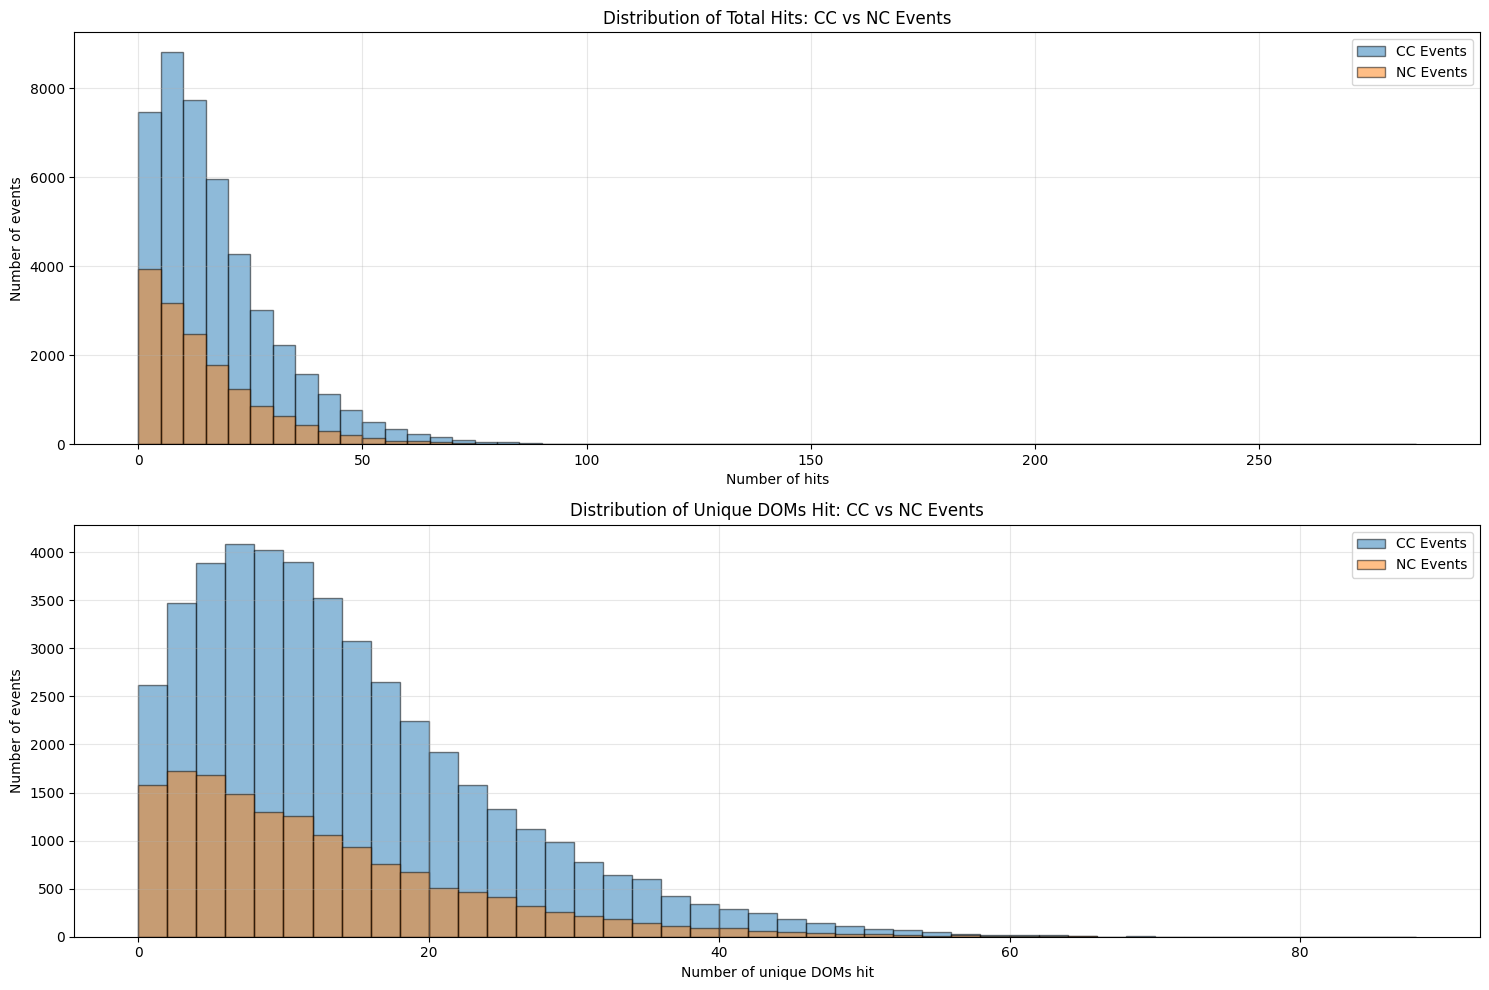

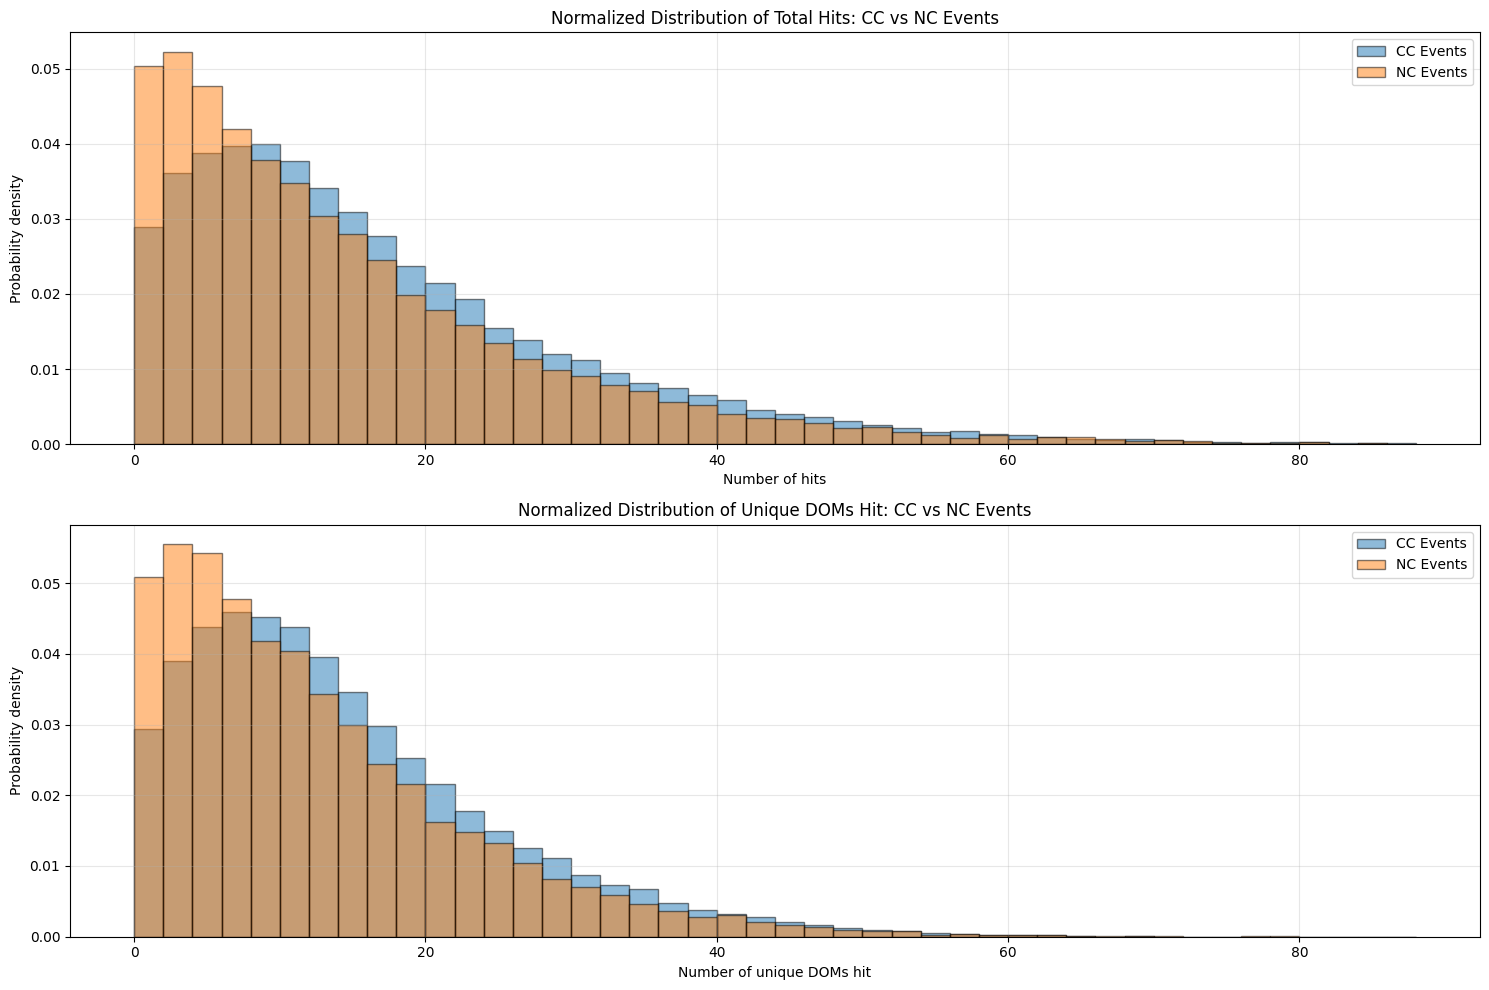

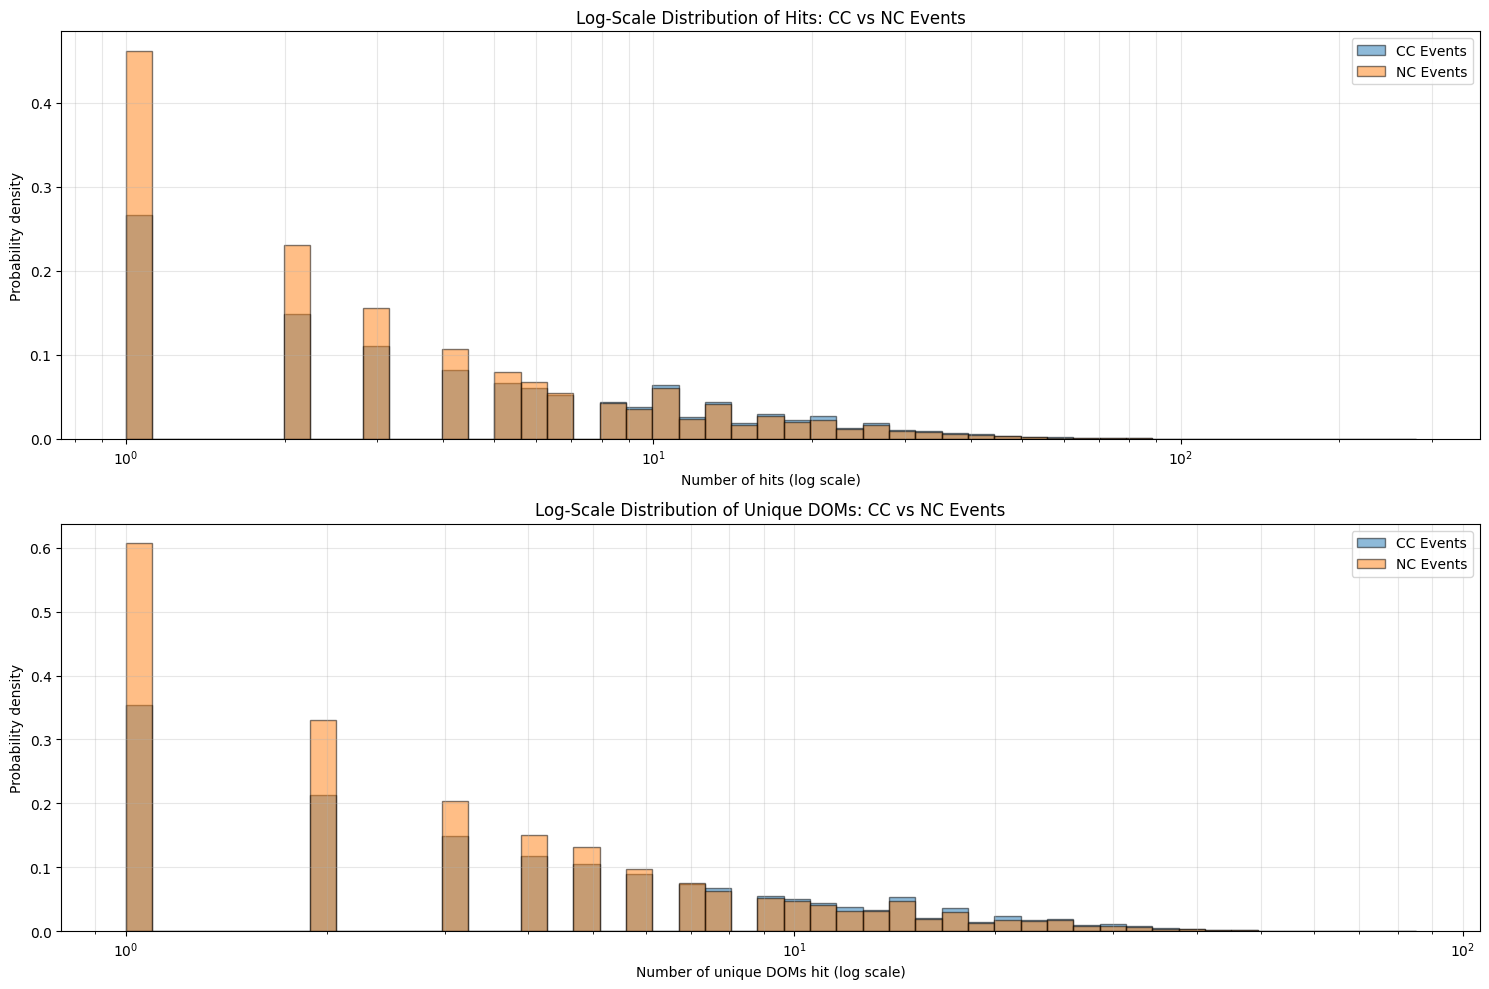

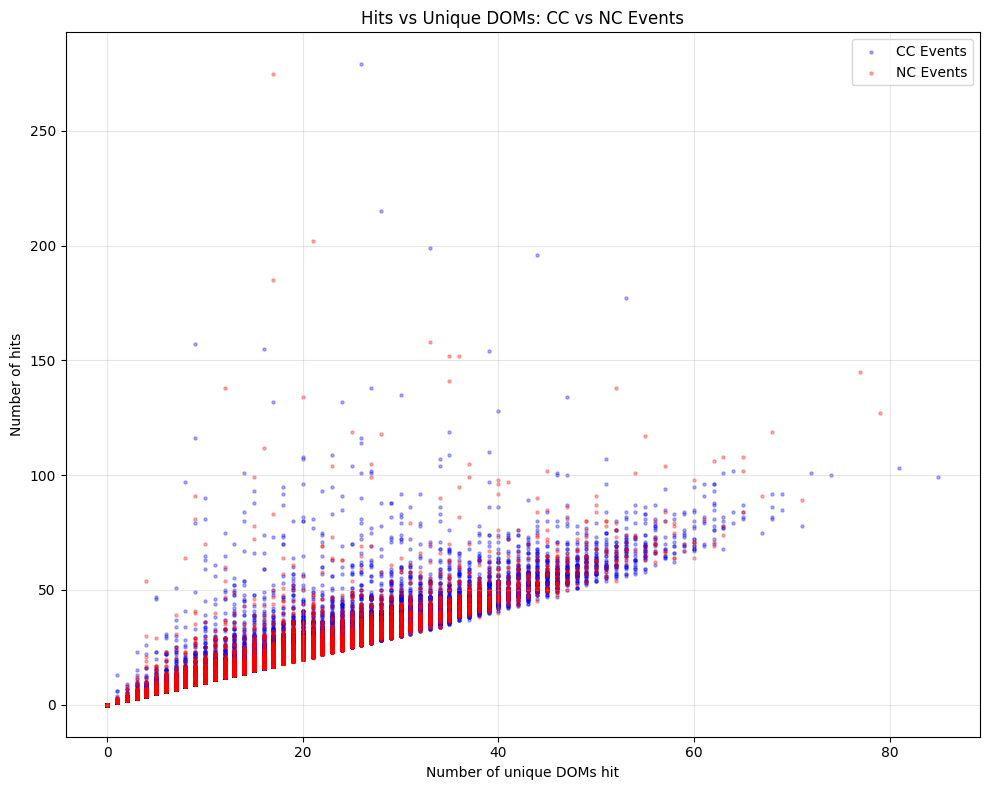

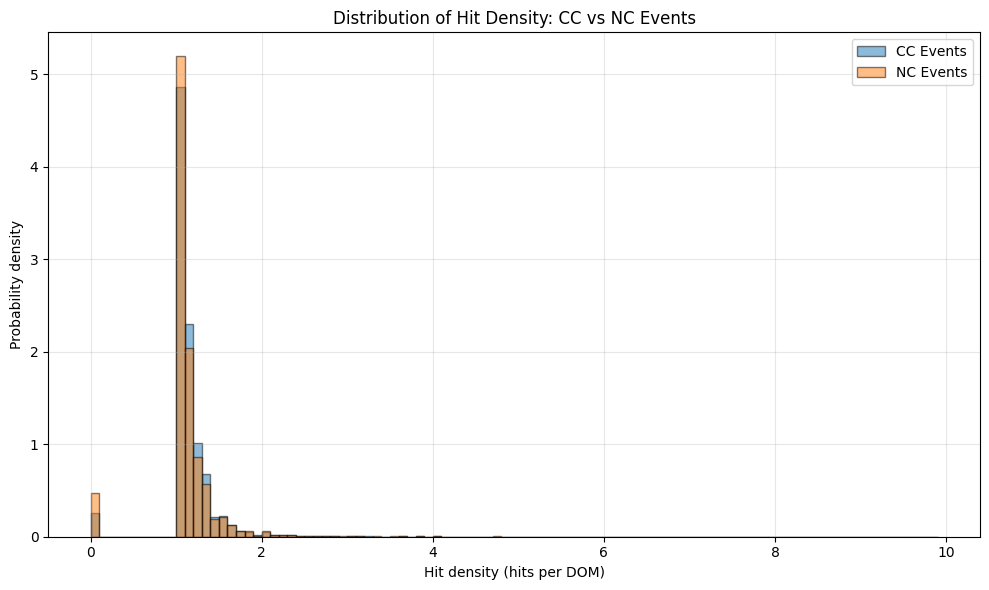

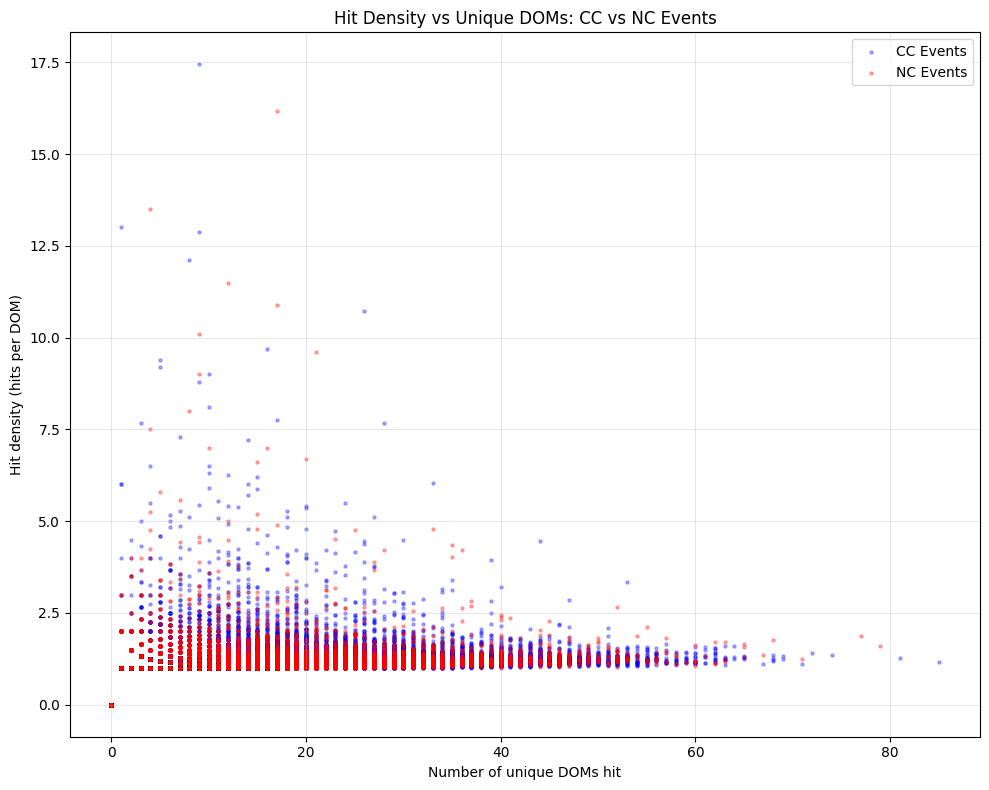

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# Identify CC and NC events
cc_idx = []
nc_idx = []

for idx, row in combined_df.iterrows():
    interaction_type = row['mc_truth']['interaction']
    if interaction_type == 1:  # CC event
        cc_idx.append(idx)
    elif interaction_type == 2:  # NC event
        nc_idx.append(idx)

print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")

# Arrays to store total hit counts for CC and NC events
cc_hits_per_event = np.zeros(len(cc_idx))
nc_hits_per_event = np.zeros(len(nc_idx))

# Arrays to store unique DOM hit counts
cc_unique_doms_per_event = np.zeros(len(cc_idx))
nc_unique_doms_per_event = np.zeros(len(nc_idx))

# Process CC events
print("Processing CC events...")
for i, event_idx in enumerate(cc_idx):
    if i % 1000 == 0:  # Progress update
        print(f"  Processing CC event {i}/{len(cc_idx)}...")
    
    # Get photons data
    photons = combined_df.iloc[event_idx]['photons']
    
    # Count total hits
    cc_hits_per_event[i] = len(photons['t'])
    
    # Count unique DOMs hit
    string_ids = photons['string_id']
    sensor_ids = photons['sensor_id']
    cc_unique_doms_per_event[i] = len(set(zip(string_ids, sensor_ids)))

# Process NC events
print("Processing NC events...")
for i, event_idx in enumerate(nc_idx):
    if i % 1000 == 0:  # Progress update
        print(f"  Processing NC event {i}/{len(nc_idx)}...")
    
    # Get photons data
    photons = combined_df.iloc[event_idx]['photons']
    
    # Count total hits
    nc_hits_per_event[i] = len(photons['t'])
    
    # Count unique DOMs hit
    string_ids = photons['string_id']
    sensor_ids = photons['sensor_id']
    nc_unique_doms_per_event[i] = len(set(zip(string_ids, sensor_ids)))

# Print statistics
print("\nStatistics Summary:")
print(f"CC Events ({len(cc_idx)} events):")
print(f"  Mean hits: {np.mean(cc_hits_per_event):.2f}")
print(f"  Median hits: {np.median(cc_hits_per_event):.2f}")
print(f"  Min/Max hits: {np.min(cc_hits_per_event)}/{np.max(cc_hits_per_event)}")
print(f"  Mean unique DOMs: {np.mean(cc_unique_doms_per_event):.2f}")
print(f"  Median unique DOMs: {np.median(cc_unique_doms_per_event):.2f}")
print(f"  Min/Max unique DOMs: {np.min(cc_unique_doms_per_event)}/{np.max(cc_unique_doms_per_event)}")

print(f"\nNC Events ({len(nc_idx)} events):")
print(f"  Mean hits: {np.mean(nc_hits_per_event):.2f}")
print(f"  Median hits: {np.median(nc_hits_per_event):.2f}")
print(f"  Min/Max hits: {np.min(nc_hits_per_event)}/{np.max(nc_hits_per_event)}")
print(f"  Mean unique DOMs: {np.mean(nc_unique_doms_per_event):.2f}")
print(f"  Median unique DOMs: {np.median(nc_unique_doms_per_event):.2f}")
print(f"  Min/Max unique DOMs: {np.min(nc_unique_doms_per_event)}/{np.max(nc_unique_doms_per_event)}")

# Create histograms (raw counts)
plt.figure(figsize=(15, 10))

# Plot 1: Total hits distribution
plt.subplot(2, 1, 1)
max_hits = max(np.max(cc_hits_per_event), np.max(nc_hits_per_event))
bin_width = 5  # Adjust for better visualization
bins = np.arange(0, min(1000, max_hits + 10), bin_width)  # Cap at 1000 for better visibility

plt.hist(cc_hits_per_event, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_hits_per_event, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Number of hits')
plt.ylabel('Number of events')
plt.title('Distribution of Total Hits: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Unique DOMs hit distribution
plt.subplot(2, 1, 2)
max_doms = max(np.max(cc_unique_doms_per_event), np.max(nc_unique_doms_per_event))
bin_width = 2  # Adjust for better visualization
bins = np.arange(0, min(100, max_doms + 5), bin_width)  # Cap at 100 for better visibility

plt.hist(cc_unique_doms_per_event, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(nc_unique_doms_per_event, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Number of events')
plt.title('Distribution of Unique DOMs Hit: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_hit_distributions_raw.png'), dpi=300)
plt.show()

# Create normalized histograms (for better comparison)
plt.figure(figsize=(15, 10))

# Plot 1: Normalized total hits distribution
plt.subplot(2, 1, 1)
plt.hist(cc_hits_per_event, bins=bins, alpha=0.5, label='CC Events', 
         edgecolor='black', density=True)
plt.hist(nc_hits_per_event, bins=bins, alpha=0.5, label='NC Events', 
         edgecolor='black', density=True)
plt.xlabel('Number of hits')
plt.ylabel('Probability density')
plt.title('Normalized Distribution of Total Hits: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Normalized unique DOMs hit distribution
plt.subplot(2, 1, 2)
plt.hist(cc_unique_doms_per_event, bins=bins, alpha=0.5, label='CC Events', 
         edgecolor='black', density=True)
plt.hist(nc_unique_doms_per_event, bins=bins, alpha=0.5, label='NC Events', 
         edgecolor='black', density=True)
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Probability density')
plt.title('Normalized Distribution of Unique DOMs Hit: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_hit_distributions_normalized.png'), dpi=300)
plt.show()

# Create log-scale versions
plt.figure(figsize=(15, 10))

# Plot 1: Log x-scale total hits
plt.subplot(2, 1, 1)
log_bins = np.logspace(np.log10(max(1, min(np.min(cc_hits_per_event[cc_hits_per_event > 0]), 
                                         np.min(nc_hits_per_event[nc_hits_per_event > 0])))), 
                     np.log10(max(1, max_hits)), 50)
plt.hist(cc_hits_per_event, bins=log_bins, alpha=0.5, label='CC Events', edgecolor='black', density=True)
plt.hist(nc_hits_per_event, bins=log_bins, alpha=0.5, label='NC Events', edgecolor='black', density=True)
plt.xscale('log')
plt.xlabel('Number of hits (log scale)')
plt.ylabel('Probability density')
plt.title('Log-Scale Distribution of Hits: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3, which='both')

# Plot 2: Log x-scale unique DOMs
plt.subplot(2, 1, 2)
log_bins = np.logspace(np.log10(max(1, min(np.min(cc_unique_doms_per_event[cc_unique_doms_per_event > 0]), 
                                          np.min(nc_unique_doms_per_event[nc_unique_doms_per_event > 0])))), 
                     np.log10(max(1, max_doms)), 50)
plt.hist(cc_unique_doms_per_event, bins=log_bins, alpha=0.5, label='CC Events', edgecolor='black', density=True)
plt.hist(nc_unique_doms_per_event, bins=log_bins, alpha=0.5, label='NC Events', edgecolor='black', density=True)
plt.xscale('log')
plt.xlabel('Number of unique DOMs hit (log scale)')
plt.ylabel('Probability density')
plt.title('Log-Scale Distribution of Unique DOMs: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_hit_distributions_log.png'), dpi=300)
plt.show()

# Create scatter plot of hits vs unique DOMs
plt.figure(figsize=(10, 8))
plt.scatter(cc_unique_doms_per_event, cc_hits_per_event, alpha=0.3, s=5, label='CC Events', color='blue')
plt.scatter(nc_unique_doms_per_event, nc_hits_per_event, alpha=0.3, s=5, label='NC Events', color='red')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Number of hits')
plt.title('Hits vs Unique DOMs: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_scatter.png'), dpi=300)
plt.show()

# Try to recreate a plot with better separation using hit density (hits per DOM)
cc_hit_density = cc_hits_per_event / np.maximum(1, cc_unique_doms_per_event)
nc_hit_density = nc_hits_per_event / np.maximum(1, nc_unique_doms_per_event)

plt.figure(figsize=(10, 6))
max_density = max(np.max(cc_hit_density), np.max(nc_hit_density))
bins = np.arange(0, min(10, max_density + 0.5), 0.1)  # Cap at 10 for visibility
plt.hist(cc_hit_density, bins=bins, alpha=0.5, label='CC Events', edgecolor='black', density=True)
plt.hist(nc_hit_density, bins=bins, alpha=0.5, label='NC Events', edgecolor='black', density=True)
plt.xlabel('Hit density (hits per DOM)')
plt.ylabel('Probability density')
plt.title('Distribution of Hit Density: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_hit_density.png'), dpi=300)
plt.show()

# Create another scatter plot of hit density vs unique DOMs
plt.figure(figsize=(10, 8))
plt.scatter(cc_unique_doms_per_event, cc_hit_density, alpha=0.3, s=5, label='CC Events', color='blue')
plt.scatter(nc_unique_doms_per_event, nc_hit_density, alpha=0.3, s=5, label='NC Events', color='red')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Hit density (hits per DOM)')
plt.title('Hit Density vs Unique DOMs: CC vs NC Events')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'cc_vs_nc_density_scatter.png'), dpi=300)
plt.show()

Loading combined simulation data from output/combined_sim_with_interaction.parquet...
Loaded 60000 events
Identifying CC and NC events...
Found 44502 CC events and 15498 NC events
Processing CC events to separate muon and hadronic hits...
  Processing CC event 0/44502...
  Processing CC event 1000/44502...
  Processing CC event 2000/44502...
  Processing CC event 3000/44502...
  Processing CC event 4000/44502...
  Processing CC event 5000/44502...
  Processing CC event 6000/44502...
  Processing CC event 7000/44502...
  Processing CC event 8000/44502...
  Processing CC event 9000/44502...
  Processing CC event 10000/44502...
  Processing CC event 11000/44502...
  Processing CC event 12000/44502...
  Processing CC event 13000/44502...
  Processing CC event 14000/44502...
  Processing CC event 15000/44502...
  Processing CC event 16000/44502...
  Processing CC event 17000/44502...
  Processing CC event 18000/44502...
  Processing CC event 19000/44502...
  Processing CC event 20000/44502.

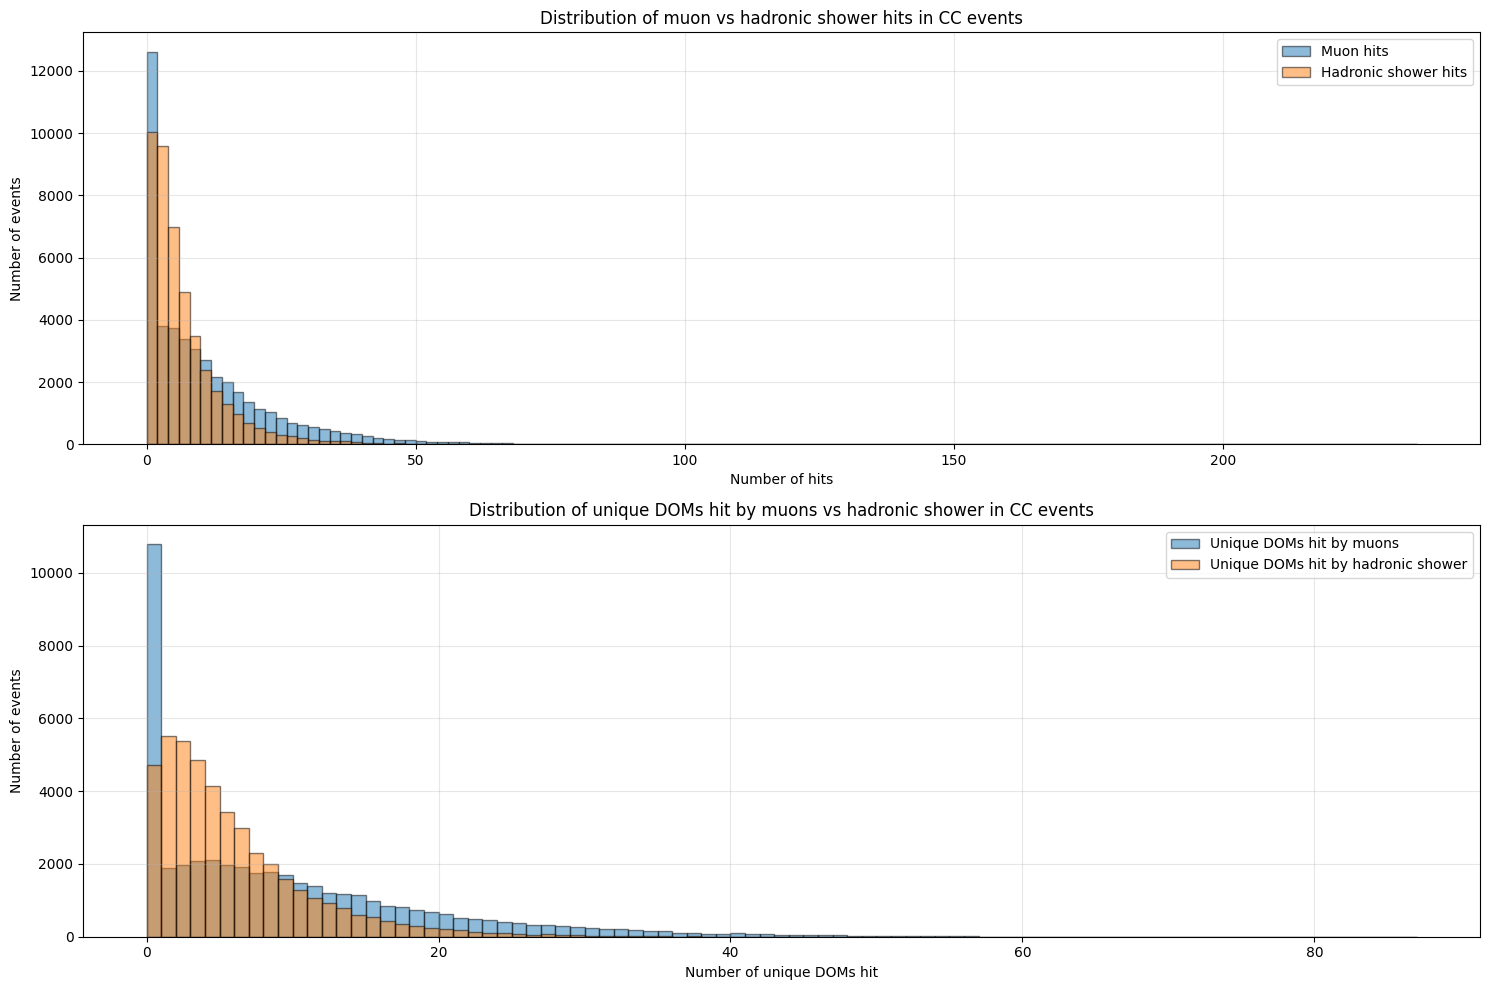

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the combined simulation data
data_dir = "output/"
combined_file = os.path.join(data_dir, 'combined_sim_with_interaction.parquet')

print(f"Loading combined simulation data from {combined_file}...")
combined_df = pd.read_parquet(combined_file)
print(f"Loaded {len(combined_df)} events")

# First, get CC and NC events
nc_idx = []
cc_idx = []

print("Identifying CC and NC events...")
for i, (idx, row) in enumerate(combined_df.iterrows()):
    if row['mc_truth']['interaction'] == 1:
        cc_idx.append(idx)
    else:
        nc_idx.append(idx)

print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")

# Function to process an event and add particle_type field
def add_particle_type(event_data):
    """Add particle_type field to the photons structure"""
    try:
        # Get the id_idx array for photons
        id_idx_array = event_data['photons']['id_idx']
        
        # Get the final_state_type array from mc_truth
        final_state_types = event_data['mc_truth']['final_state_type']
        
        # Map id_idx to final_state_type to determine particle type for each hit
        particle_types = []
        for idx in id_idx_array:
            if idx > 0 and idx <= len(final_state_types):
                particle_types.append(final_state_types[idx-1])
            else:
                particle_types.append(-1)  # Default if mapping fails
        
        # Convert to numpy array
        return np.array(particle_types)
    except Exception as e:
        print(f"Error adding particle type: {e}")
        return np.array([-1] * len(event_data['photons']['t']))  # Default array if error

# Arrays to store hit counts for CC events
muon_hits_per_event = np.zeros(len(cc_idx))
hadron_hits_per_event = np.zeros(len(cc_idx))

# Arrays to store unique DOM hit counts
unique_muon_doms_per_event = np.zeros(len(cc_idx))
unique_hadron_doms_per_event = np.zeros(len(cc_idx))

# Process each CC event
print("Processing CC events to separate muon and hadronic hits...")
for i, event_idx in enumerate(cc_idx):
    if i % 1000 == 0:  # Progress update
        print(f"  Processing CC event {i}/{len(cc_idx)}...")
    
    # Get the event data
    event_data = combined_df.iloc[event_idx]
    
    # Add particle_type field
    particle_types = add_particle_type(event_data)
    
    # Skip if we couldn't determine particle types
    if len(particle_types) == 0:
        continue
    
    # Identify muon hits and hadronic shower hits
    muon_mask = (particle_types == 13)
    hadron_mask = (particle_types != 13)
    
    # Count total hits
    muon_hits_per_event[i] = np.sum(muon_mask)
    hadron_hits_per_event[i] = np.sum(hadron_mask)
    
    # For unique DOM counts, we need string_id and sensor_id
    string_ids = event_data['photons']['string_id']
    sensor_ids = event_data['photons']['sensor_id']
    
    # Get unique DOMs hit by muons
    if np.any(muon_mask):
        muon_strings = string_ids[muon_mask]
        muon_sensors = sensor_ids[muon_mask]
        unique_muon_doms_per_event[i] = len(set(zip(muon_strings, muon_sensors)))
    
    # Get unique DOMs hit by hadronic shower
    if np.any(hadron_mask):
        hadron_strings = string_ids[hadron_mask]
        hadron_sensors = sensor_ids[hadron_mask]
        unique_hadron_doms_per_event[i] = len(set(zip(hadron_strings, hadron_sensors)))

print("Processing complete")

# Create histograms
plt.figure(figsize=(15, 10))

# Plot 1: Total hits distribution
plt.subplot(2, 1, 1)
bins = np.arange(0, max(np.max(muon_hits_per_event), np.max(hadron_hits_per_event)) + 10, 2)
plt.hist(muon_hits_per_event, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black')
plt.hist(hadron_hits_per_event, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
plt.xlabel('Number of hits')
plt.ylabel('Number of events')
plt.title('Distribution of muon vs hadronic shower hits in CC events')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Unique DOMs hit distribution
plt.subplot(2, 1, 2)
bins = np.arange(0, max(np.max(unique_muon_doms_per_event), np.max(unique_hadron_doms_per_event)) + 5, 1)
plt.hist(unique_muon_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
plt.hist(unique_hadron_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Number of events')
plt.title('Distribution of unique DOMs hit by muons vs hadronic shower in CC events')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'muon_vs_hadron_hits_cc_events_exact.png'), dpi=300)
plt.show()

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing your files
data_dir = "output/"

# List of simulation output files
sim_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Function to process a single file
def process_file(file_path):
    print(f"Processing {file_path}...")
    
    # Load the file
    df = pd.read_parquet(file_path)
    print(f"Loaded {len(df)} events")
    
    # Get CC and NC events
    nc_idx = []
    cc_idx = []
    
    for i, (idx, row) in enumerate(df.iterrows()):
        if row['mc_truth']['interaction'] == 1:
            cc_idx.append(idx)
        else:
            nc_idx.append(idx)
    
    print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")
    
    # Function to add particle type
    def add_particle_type(event_data):
        try:
            # Get the id_idx array for photons
            id_idx_array = event_data['photons']['id_idx']
            
            # Get the final_state_type array from mc_truth
            final_state_types = event_data['mc_truth']['final_state_type']
            
            # Map id_idx to final_state_type to determine particle type for each hit
            particle_types = []
            for idx in id_idx_array:
                if idx > 0 and idx <= len(final_state_types):
                    particle_types.append(final_state_types[idx-1])
                else:
                    particle_types.append(-1)  # Default if mapping fails
            
            # Convert to numpy array
            return np.array(particle_types)
        except Exception as e:
            print(f"Error adding particle type: {e}")
            return np.array([-1] * len(event_data['photons']['t']))  # Default array if error
    
    # Arrays to store hit counts for CC events
    muon_hits_per_event = np.zeros(len(cc_idx))
    hadron_hits_per_event = np.zeros(len(cc_idx))
    
    # Arrays to store unique DOM hit counts
    unique_muon_doms_per_event = np.zeros(len(cc_idx))
    unique_hadron_doms_per_event = np.zeros(len(cc_idx))
    
    # Process each CC event
    for i, event_idx in enumerate(cc_idx):
        # Get the event data
        event_data = df.iloc[event_idx]
        
        # Add particle_type field
        particle_types = add_particle_type(event_data)
        
        # Skip if we couldn't determine particle types
        if len(particle_types) == 0:
            continue
        
        # Identify muon hits and hadronic shower hits
        muon_mask = (particle_types == 13)
        hadron_mask = (particle_types != 13)
        
        # Count total hits
        muon_hits_per_event[i] = np.sum(muon_mask)
        hadron_hits_per_event[i] = np.sum(hadron_mask)
        
        # For unique DOM counts, we need string_id and sensor_id
        string_ids = event_data['photons']['string_id']
        sensor_ids = event_data['photons']['sensor_id']
        
        # Get unique DOMs hit by muons
        if np.any(muon_mask):
            muon_strings = string_ids[muon_mask]
            muon_sensors = sensor_ids[muon_mask]
            unique_muon_doms_per_event[i] = len(set(zip(muon_strings, muon_sensors)))
        
        # Get unique DOMs hit by hadronic shower
        if np.any(hadron_mask):
            hadron_strings = string_ids[hadron_mask]
            hadron_sensors = sensor_ids[hadron_mask]
            unique_hadron_doms_per_event[i] = len(set(zip(hadron_strings, hadron_sensors)))
    
    # Create histograms
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Total hits distribution
    plt.subplot(2, 1, 1)
    bins = np.arange(0, max(np.max(muon_hits_per_event), np.max(hadron_hits_per_event)) + 10, 2)
    plt.hist(muon_hits_per_event, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black')
    plt.hist(hadron_hits_per_event, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
    plt.xlabel('Number of hits')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of muon vs hadronic shower hits in CC events - {os.path.basename(file_path)}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Unique DOMs hit distribution
    plt.subplot(2, 1, 2)
    bins = np.arange(0, max(np.max(unique_muon_doms_per_event), np.max(unique_hadron_doms_per_event)) + 5, 1)
    plt.hist(unique_muon_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
    plt.hist(unique_hadron_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
    plt.xlabel('Number of unique DOMs hit')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of unique DOMs hit by muons vs hadronic shower in CC events - {os.path.basename(file_path)}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    output_file = os.path.join(data_dir, f'muon_vs_hadron_{os.path.basename(file_path).replace(".parquet", "")}.png')
    plt.savefig(output_file, dpi=300)
    plt.close()  # Close the figure to free memory
    
    print(f"Saved plot to {output_file}")
    
    # Return statistics
    return {
        'file': os.path.basename(file_path),
        'cc_events': len(cc_idx),
        'nc_events': len(nc_idx),
        'mean_muon_hits': np.mean(muon_hits_per_event),
        'mean_hadron_hits': np.mean(hadron_hits_per_event),
        'mean_unique_muon_doms': np.mean(unique_muon_doms_per_event),
        'mean_unique_hadron_doms': np.mean(unique_hadron_doms_per_event)
    }

# Process each file
stats = []
for sim_file in sim_files:
    file_path = os.path.join(data_dir, sim_file)
    if os.path.exists(file_path):
        file_stats = process_file(file_path)
        stats.append(file_stats)
    else:
        print(f"File not found: {file_path}")

# Print summary statistics
print("\nSummary Statistics:")
for stat in stats:
    print(f"\nFile: {stat['file']}")
    print(f"  CC Events: {stat['cc_events']}, NC Events: {stat['nc_events']}")
    print(f"  Mean muon hits: {stat['mean_muon_hits']:.2f}")
    print(f"  Mean hadron hits: {stat['mean_hadron_hits']:.2f}")
    print(f"  Mean unique muon DOMs: {stat['mean_unique_muon_doms']:.2f}")
    print(f"  Mean unique hadron DOMs: {stat['mean_unique_hadron_doms']:.2f}")

Processing output/10000_events_simset_1600_seed_1000_20250516_112519.parquet...
Loaded 10000 events
Found 7601 CC events and 2399 NC events
Saved plot to output/muon_vs_hadron_10000_events_simset_1600_seed_1000_20250516_112519.png
Processing output/10000_events_simset_1601_seed_1001_20250516_112659.parquet...
Loaded 10000 events
Found 7517 CC events and 2483 NC events
Saved plot to output/muon_vs_hadron_10000_events_simset_1601_seed_1001_20250516_112659.png
Processing output/10000_events_simset_1602_seed_1002_20250516_112840.parquet...
Loaded 10000 events
Found 7522 CC events and 2478 NC events
Saved plot to output/muon_vs_hadron_10000_events_simset_1602_seed_1002_20250516_112840.png
Processing output/10000_events_simset_1603_seed_1003_20250516_112857.parquet...
Loaded 10000 events
Found 7497 CC events and 2503 NC events
Saved plot to output/muon_vs_hadron_10000_events_simset_1603_seed_1003_20250516_112857.png
Processing output/10000_events_simset_1604_seed_1004_20250516_112923.parquet

Processing output/10000_events_simset_1600_seed_1000_20250516_112519.parquet...
Loaded 10000 events
Found 7601 CC events and 2399 NC events


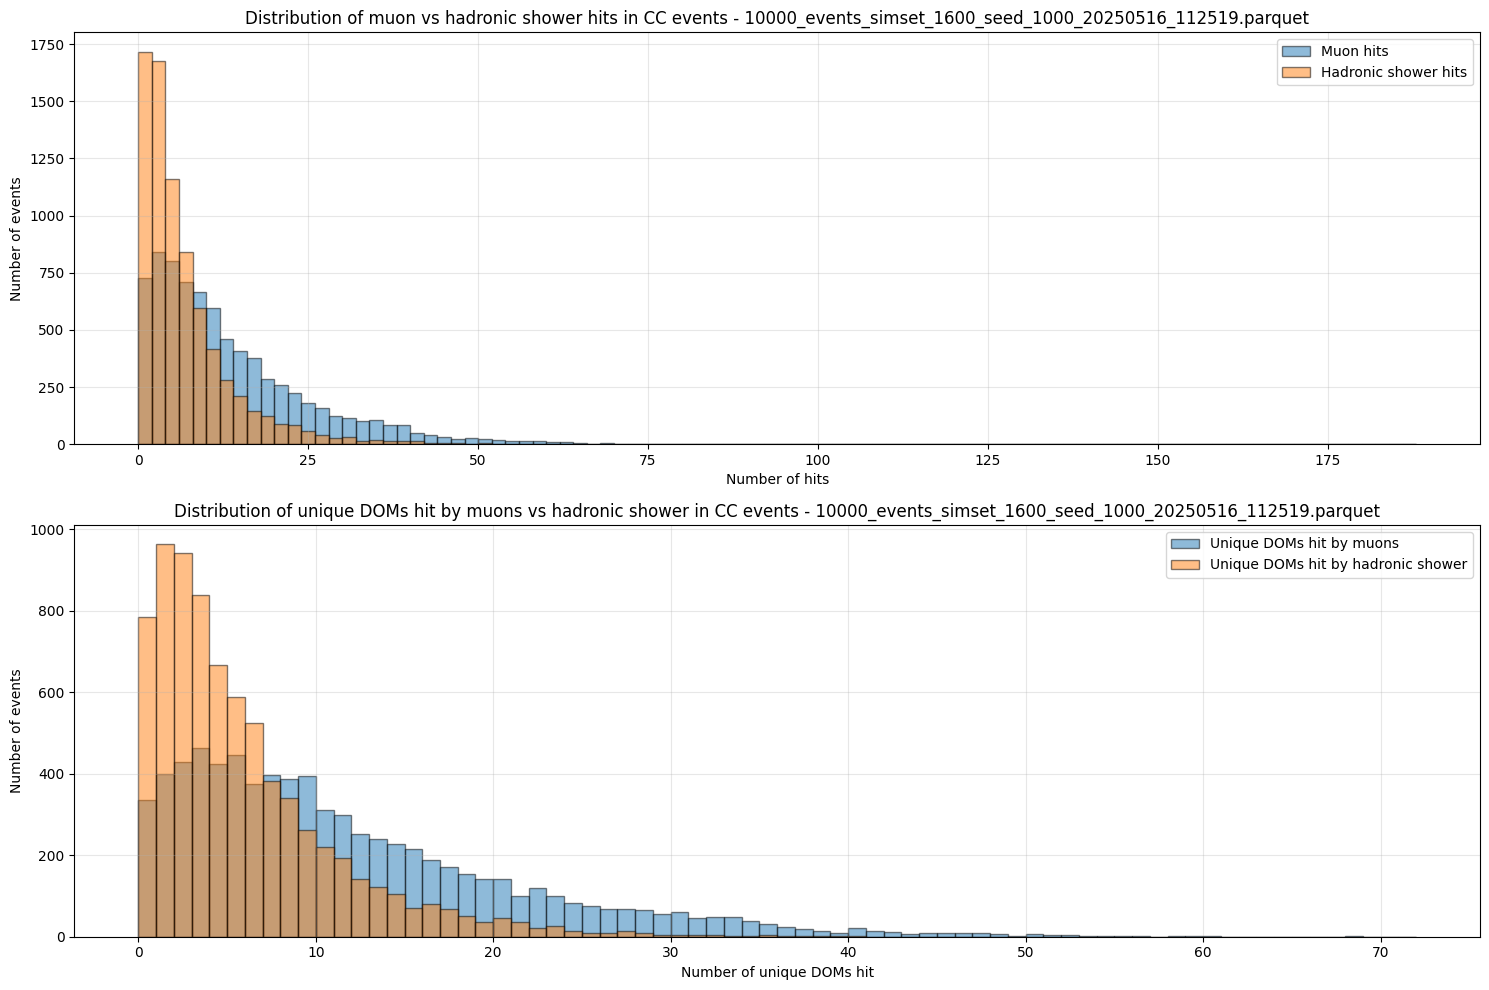

Processing output/10000_events_simset_1601_seed_1001_20250516_112659.parquet...
Loaded 10000 events
Found 7517 CC events and 2483 NC events


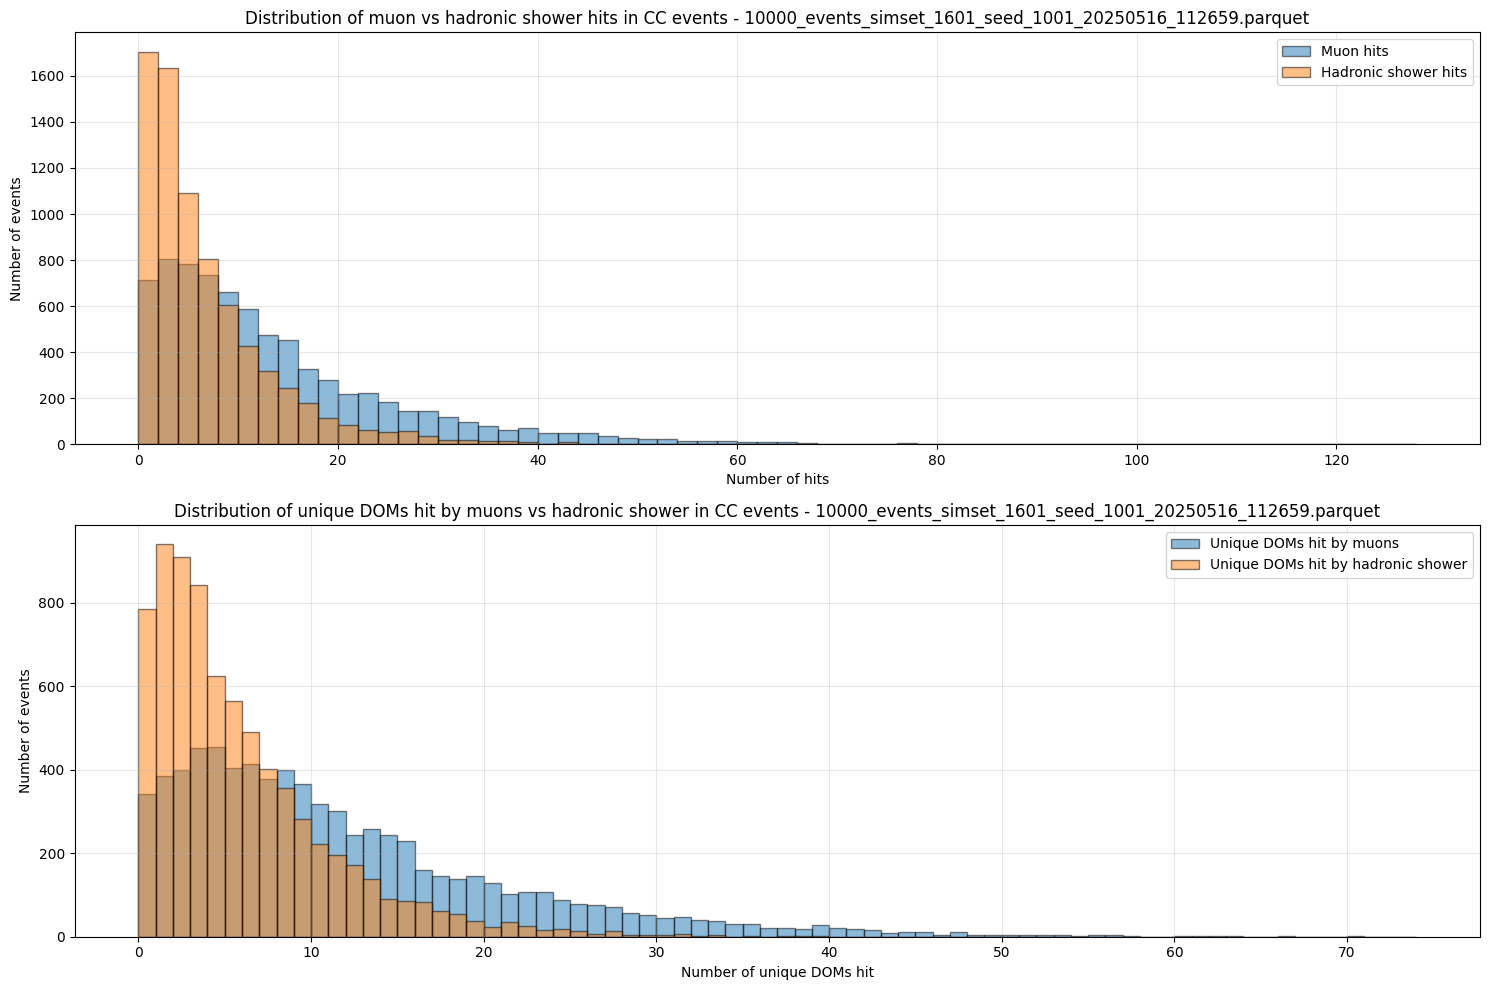

Processing output/10000_events_simset_1602_seed_1002_20250516_112840.parquet...
Loaded 10000 events
Found 7522 CC events and 2478 NC events


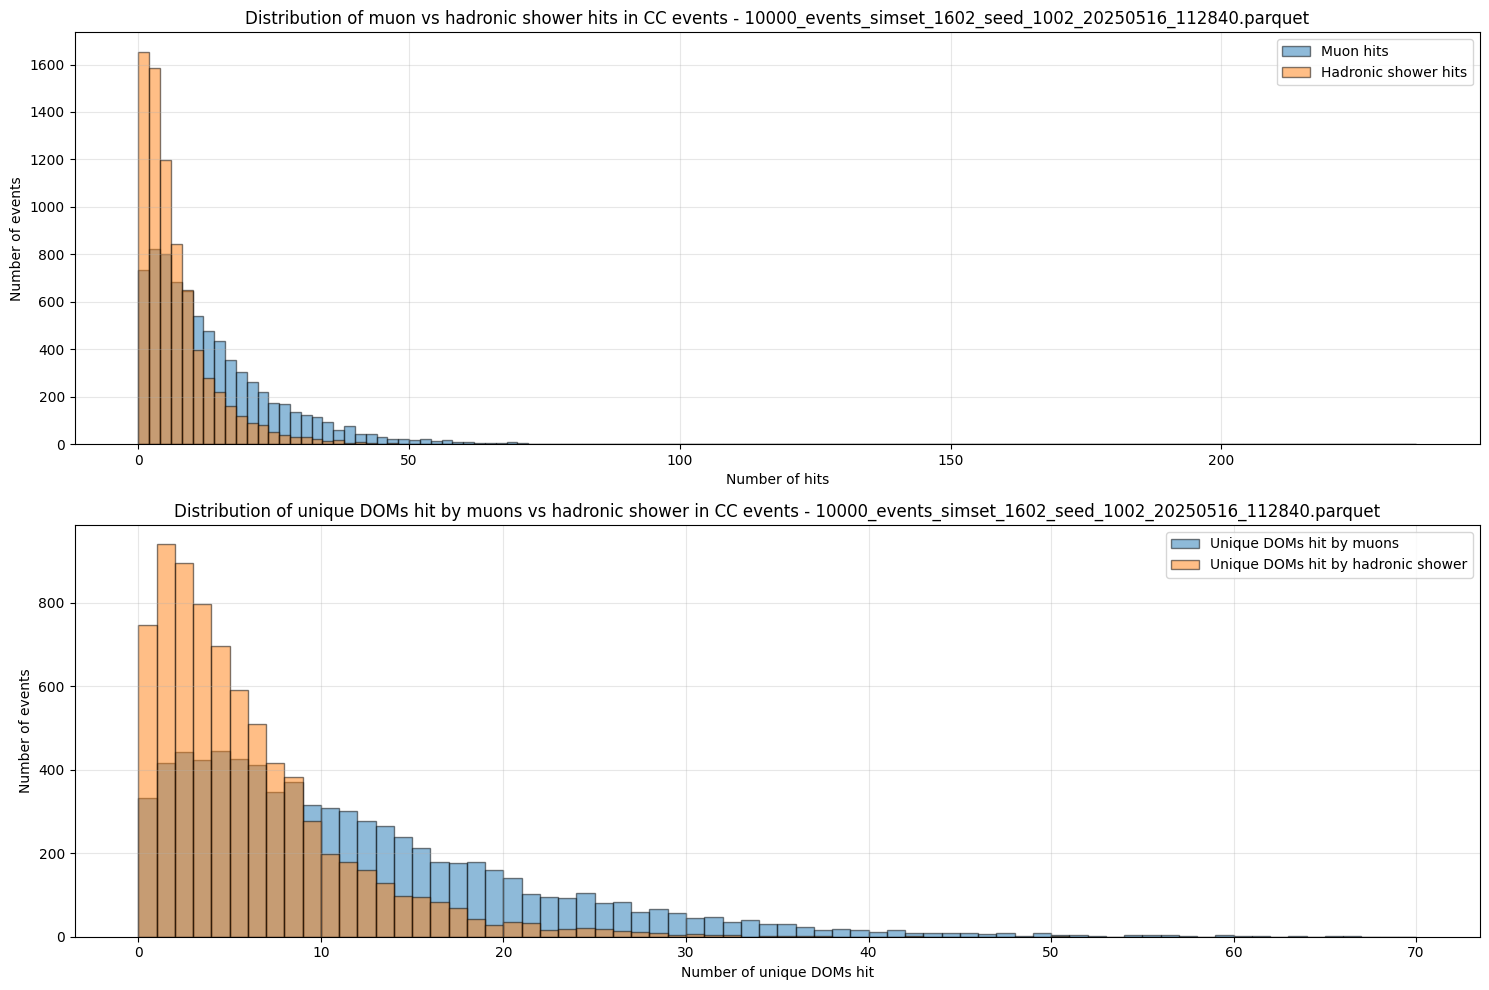

Processing output/10000_events_simset_1603_seed_1003_20250516_112857.parquet...
Loaded 10000 events
Found 7497 CC events and 2503 NC events


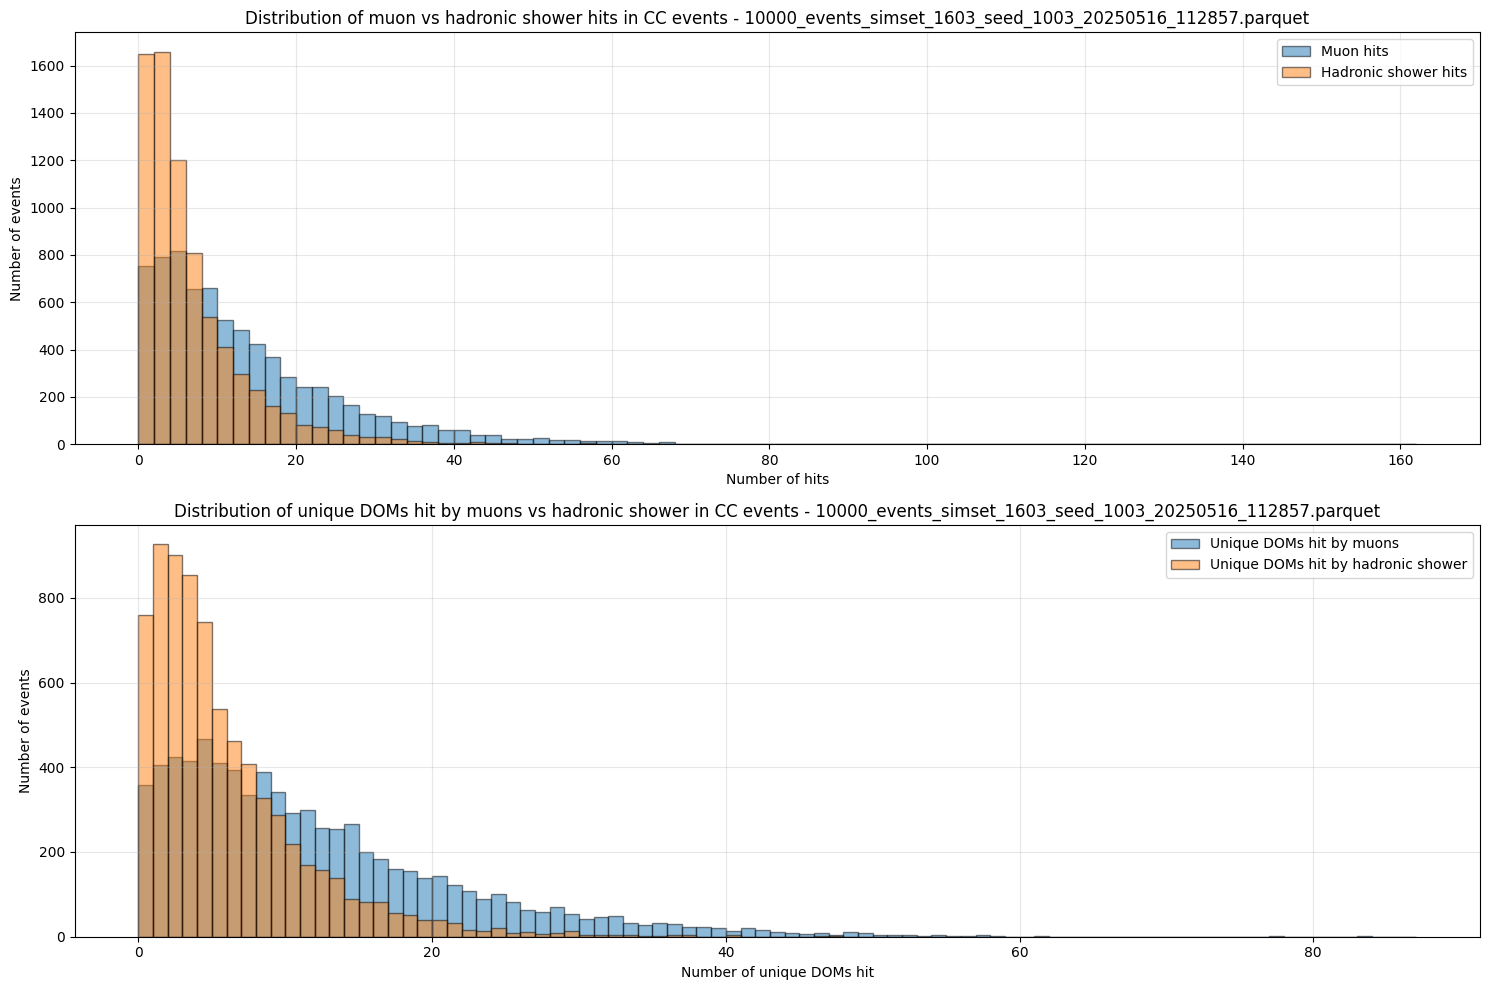

Processing output/10000_events_simset_1604_seed_1004_20250516_112923.parquet...
Loaded 10000 events
Found 7535 CC events and 2465 NC events


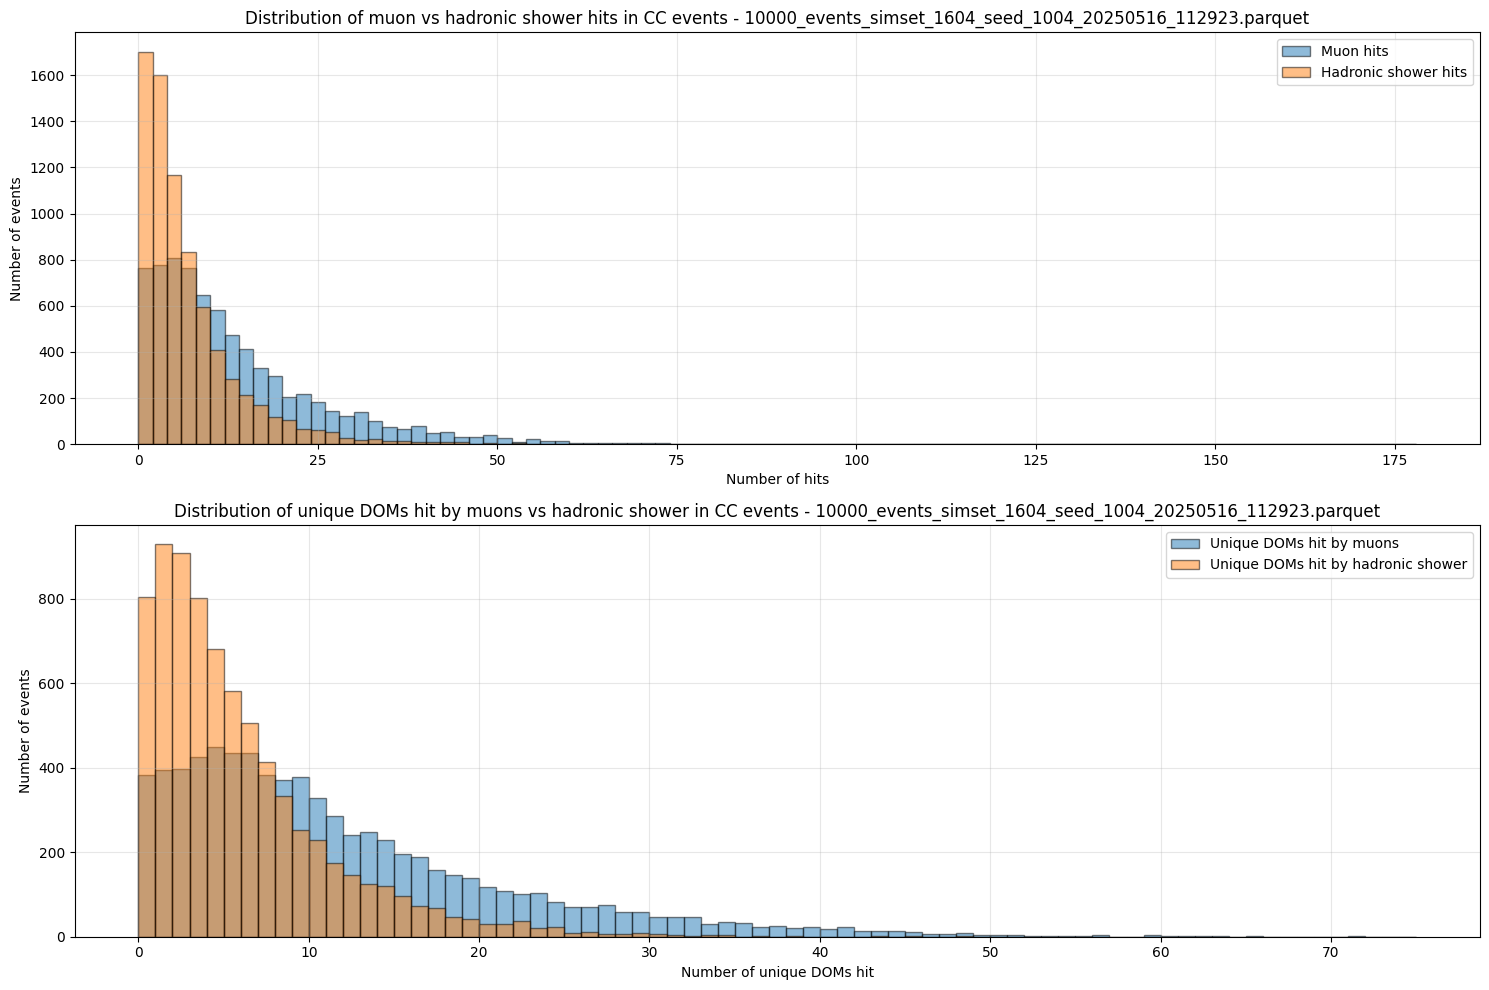

Processing output/10000_events_simset_1605_seed_1005_20250516_112950.parquet...
Loaded 10000 events
Found 7417 CC events and 2583 NC events


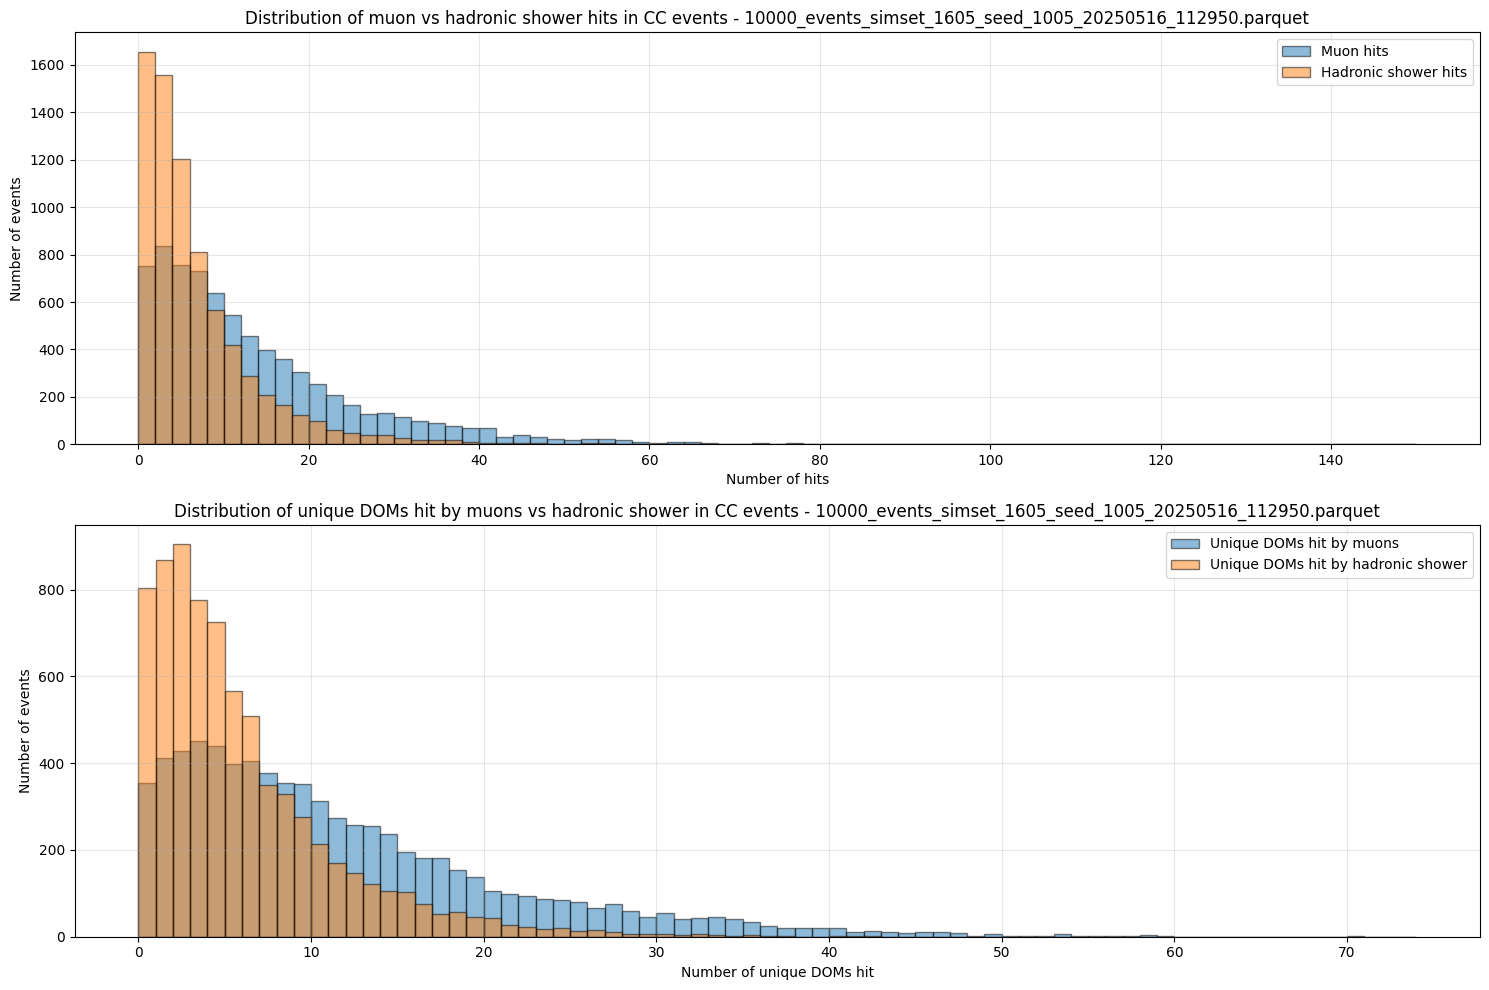


Summary Statistics:

File: 10000_events_simset_1600_seed_1000_20250516_112519.parquet
  CC Events: 7601, NC Events: 2399
  Mean muon hits: 13.22
  Mean hadron hits: 6.43
  Mean unique muon DOMs: 11.39
  Mean unique hadron DOMs: 5.44

File: 10000_events_simset_1601_seed_1001_20250516_112659.parquet
  CC Events: 7517, NC Events: 2483
  Mean muon hits: 13.28
  Mean hadron hits: 6.46
  Mean unique muon DOMs: 11.46
  Mean unique hadron DOMs: 5.45

File: 10000_events_simset_1602_seed_1002_20250516_112840.parquet
  CC Events: 7522, NC Events: 2478
  Mean muon hits: 13.18
  Mean hadron hits: 6.47
  Mean unique muon DOMs: 11.38
  Mean unique hadron DOMs: 5.48

File: 10000_events_simset_1603_seed_1003_20250516_112857.parquet
  CC Events: 7497, NC Events: 2503
  Mean muon hits: 13.23
  Mean hadron hits: 6.41
  Mean unique muon DOMs: 11.49
  Mean unique hadron DOMs: 5.47

File: 10000_events_simset_1604_seed_1004_20250516_112923.parquet
  CC Events: 7535, NC Events: 2465
  Mean muon hits: 13.22
  

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing your files
data_dir = "output/"

# List of simulation output files
sim_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Function to process a single file
def process_file(file_path):
    print(f"Processing {file_path}...")
    
    # Load the file
    df = pd.read_parquet(file_path)
    print(f"Loaded {len(df)} events")
    
    # Get CC and NC events
    nc_idx = []
    cc_idx = []
    
    for i, (idx, row) in enumerate(df.iterrows()):
        if row['mc_truth']['interaction'] == 1:
            cc_idx.append(idx)
        else:
            nc_idx.append(idx)
    
    print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")
    
    # Function to add particle type
    def add_particle_type(event_data):
        try:
            # Get the id_idx array for photons
            id_idx_array = event_data['photons']['id_idx']
            
            # Get the final_state_type array from mc_truth
            final_state_types = event_data['mc_truth']['final_state_type']
            
            # Map id_idx to final_state_type to determine particle type for each hit
            particle_types = []
            for idx in id_idx_array:
                if idx > 0 and idx <= len(final_state_types):
                    particle_types.append(final_state_types[idx-1])
                else:
                    particle_types.append(-1)  # Default if mapping fails
            
            # Convert to numpy array
            return np.array(particle_types)
        except Exception as e:
            print(f"Error adding particle type: {e}")
            return np.array([-1] * len(event_data['photons']['t']))  # Default array if error
    
    # Arrays to store hit counts for CC events
    muon_hits_per_event = np.zeros(len(cc_idx))
    hadron_hits_per_event = np.zeros(len(cc_idx))
    
    # Arrays to store unique DOM hit counts
    unique_muon_doms_per_event = np.zeros(len(cc_idx))
    unique_hadron_doms_per_event = np.zeros(len(cc_idx))
    
    # Process each CC event
    for i, event_idx in enumerate(cc_idx):
        # Get the event data
        event_data = df.iloc[event_idx]
        
        # Add particle_type field
        particle_types = add_particle_type(event_data)
        
        # Skip if we couldn't determine particle types
        if len(particle_types) == 0:
            continue
        
        # Identify muon hits and hadronic shower hits
        muon_mask = (particle_types == 13)
        hadron_mask = (particle_types != 13)
        
        # Count total hits
        muon_hits_per_event[i] = np.sum(muon_mask)
        hadron_hits_per_event[i] = np.sum(hadron_mask)
        
        # For unique DOM counts, we need string_id and sensor_id
        string_ids = event_data['photons']['string_id']
        sensor_ids = event_data['photons']['sensor_id']
        
        # Get unique DOMs hit by muons
        if np.any(muon_mask):
            muon_strings = string_ids[muon_mask]
            muon_sensors = sensor_ids[muon_mask]
            unique_muon_doms_per_event[i] = len(set(zip(muon_strings, muon_sensors)))
        
        # Get unique DOMs hit by hadronic shower
        if np.any(hadron_mask):
            hadron_strings = string_ids[hadron_mask]
            hadron_sensors = sensor_ids[hadron_mask]
            unique_hadron_doms_per_event[i] = len(set(zip(hadron_strings, hadron_sensors)))
    
    # Create histograms
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Total hits distribution
    plt.subplot(2, 1, 1)
    bins = np.arange(0, max(np.max(muon_hits_per_event), np.max(hadron_hits_per_event)) + 10, 2)
    plt.hist(muon_hits_per_event, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black')
    plt.hist(hadron_hits_per_event, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
    plt.xlabel('Number of hits')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of muon vs hadronic shower hits in CC events - {os.path.basename(file_path)}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Unique DOMs hit distribution
    plt.subplot(2, 1, 2)
    bins = np.arange(0, max(np.max(unique_muon_doms_per_event), np.max(unique_hadron_doms_per_event)) + 5, 1)
    plt.hist(unique_muon_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
    plt.hist(unique_hadron_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
    plt.xlabel('Number of unique DOMs hit')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of unique DOMs hit by muons vs hadronic shower in CC events - {os.path.basename(file_path)}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    return {
        'file': os.path.basename(file_path),
        'cc_events': len(cc_idx),
        'nc_events': len(nc_idx),
        'mean_muon_hits': np.mean(muon_hits_per_event),
        'mean_hadron_hits': np.mean(hadron_hits_per_event),
        'mean_unique_muon_doms': np.mean(unique_muon_doms_per_event),
        'mean_unique_hadron_doms': np.mean(unique_hadron_doms_per_event)
    }

# Process each file
stats = []
for sim_file in sim_files:
    file_path = os.path.join(data_dir, sim_file)
    if os.path.exists(file_path):
        file_stats = process_file(file_path)
        stats.append(file_stats)
    else:
        print(f"File not found: {file_path}")

# Print summary statistics
print("\nSummary Statistics:")
for stat in stats:
    print(f"\nFile: {stat['file']}")
    print(f"  CC Events: {stat['cc_events']}, NC Events: {stat['nc_events']}")
    print(f"  Mean muon hits: {stat['mean_muon_hits']:.2f}")
    print(f"  Mean hadron hits: {stat['mean_hadron_hits']:.2f}")
    print(f"  Mean unique muon DOMs: {stat['mean_unique_muon_doms']:.2f}")
    print(f"  Mean unique hadron DOMs: {stat['mean_unique_hadron_doms']:.2f}")


Processing 10000_events_simset_1600_seed_1000_20250516_112519.parquet...
Loaded 10000 events
Found 7601 CC events and 2399 NC events


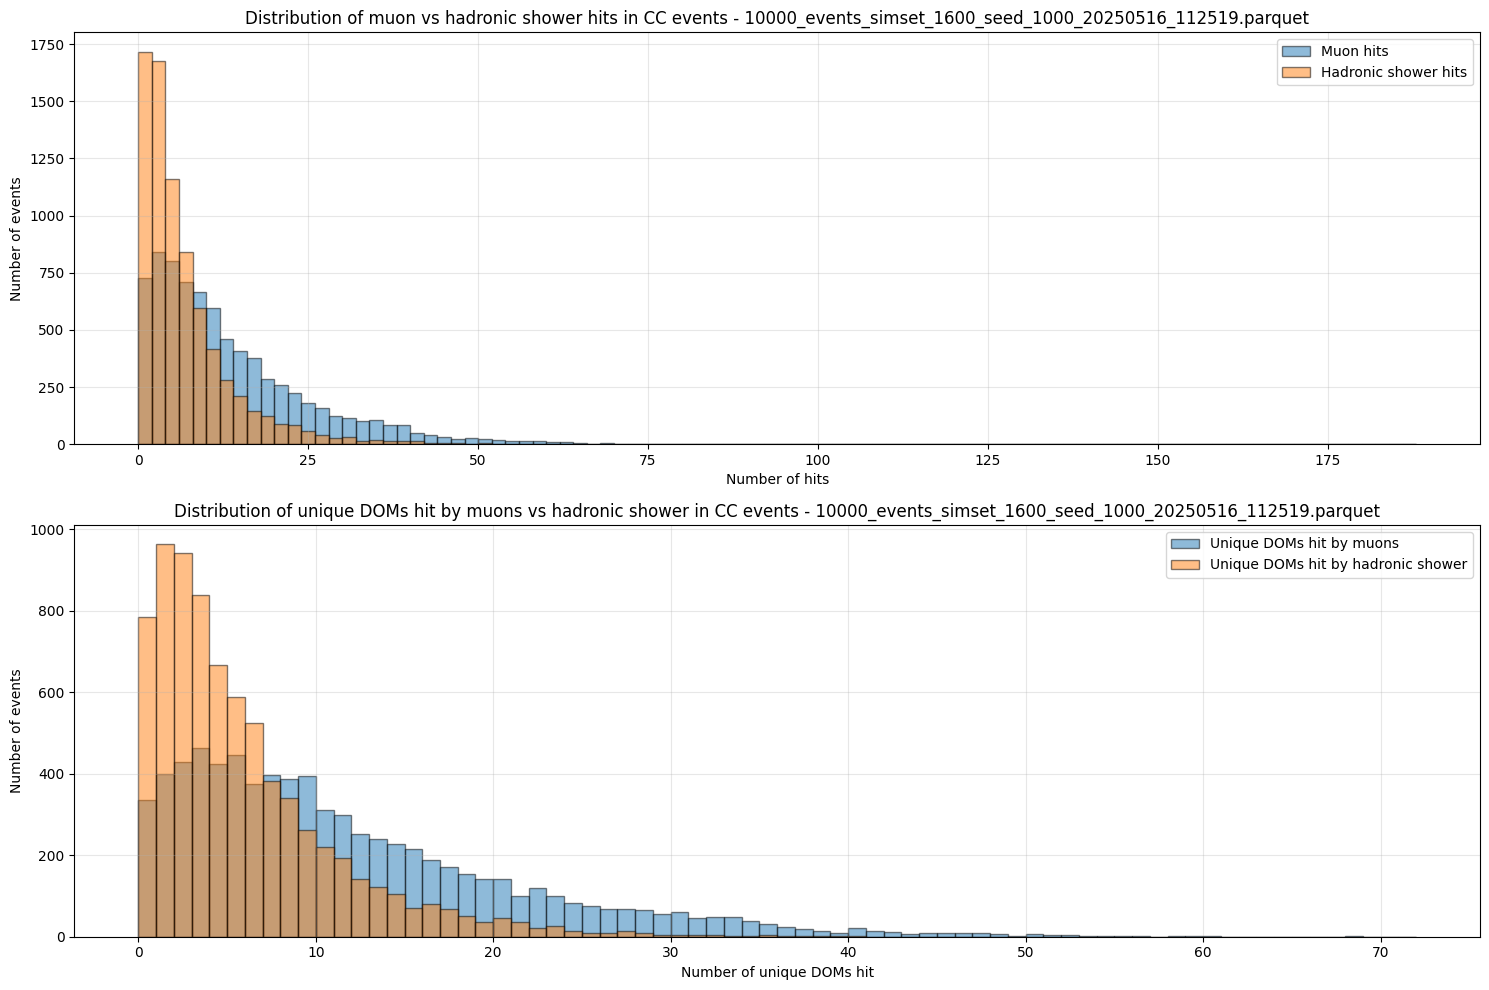

Processed file with 7601 CC events

Processing 10000_events_simset_1601_seed_1001_20250516_112659.parquet...
Loaded 10000 events
Found 7517 CC events and 2483 NC events


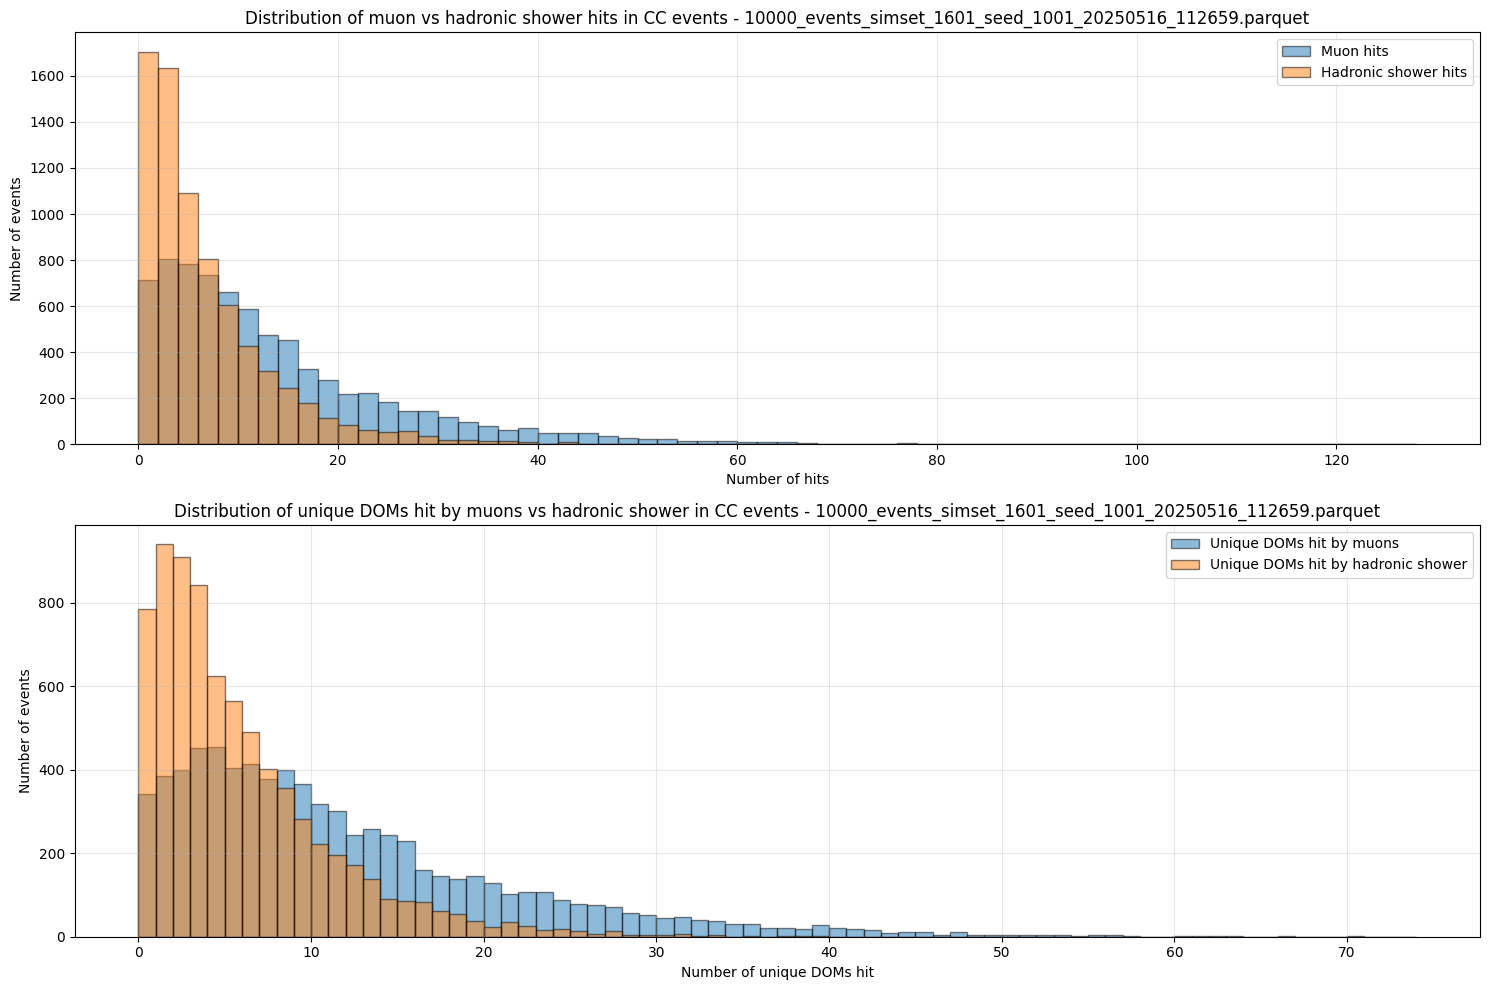

Processed file with 7517 CC events

Processing 10000_events_simset_1602_seed_1002_20250516_112840.parquet...
Loaded 10000 events
Found 7522 CC events and 2478 NC events


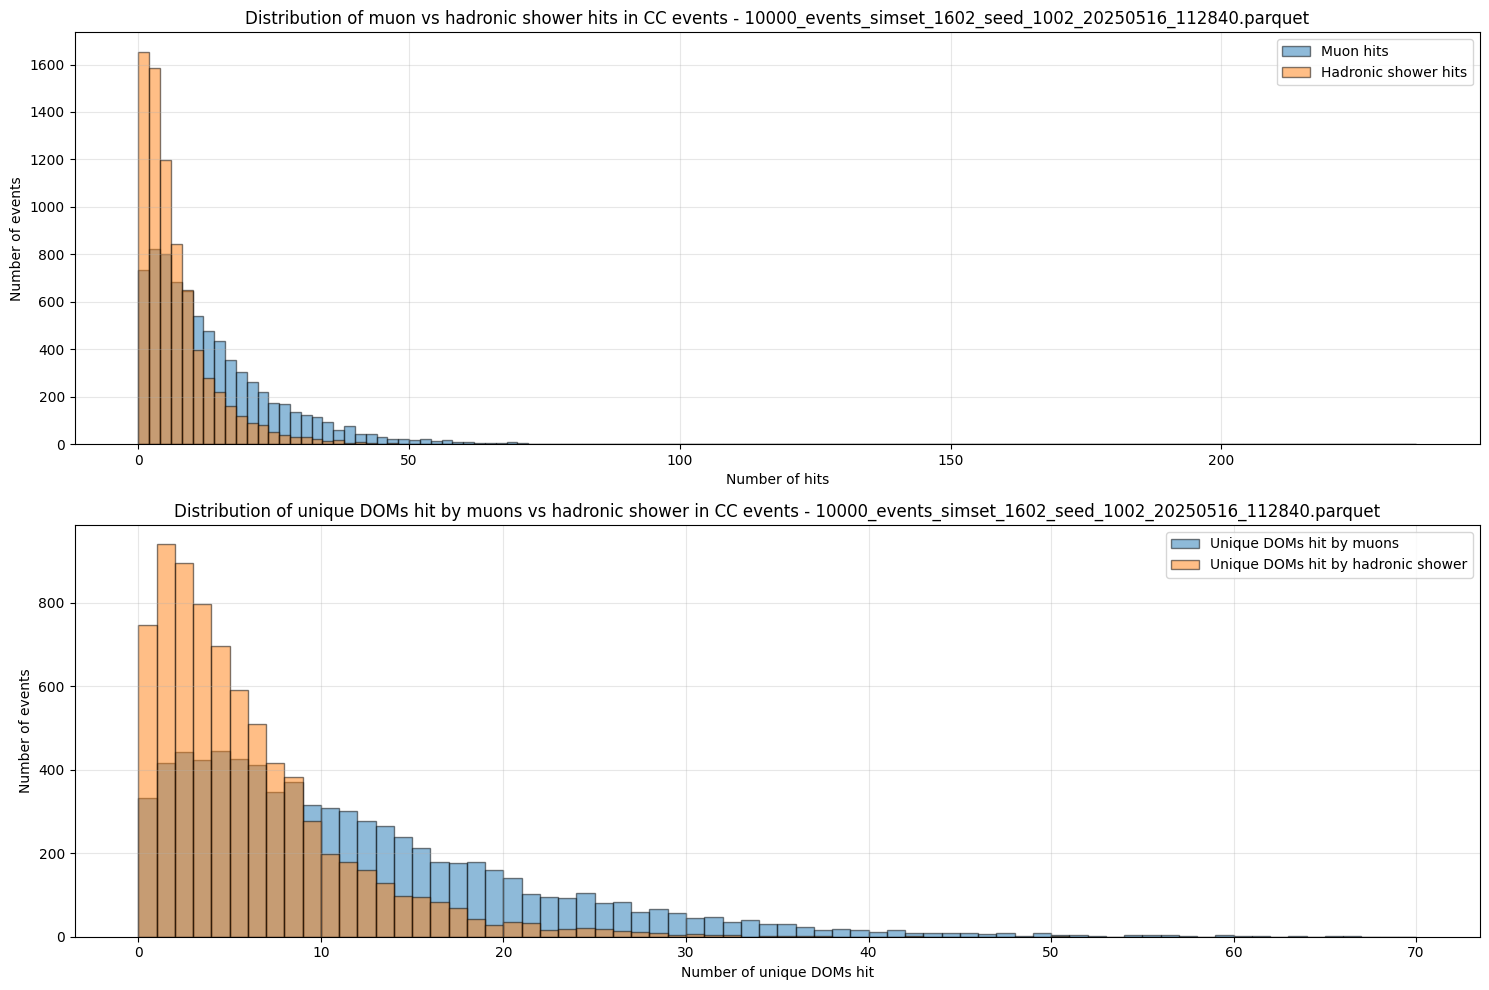

Processed file with 7522 CC events

Processing 10000_events_simset_1603_seed_1003_20250516_112857.parquet...
Loaded 10000 events
Found 7497 CC events and 2503 NC events


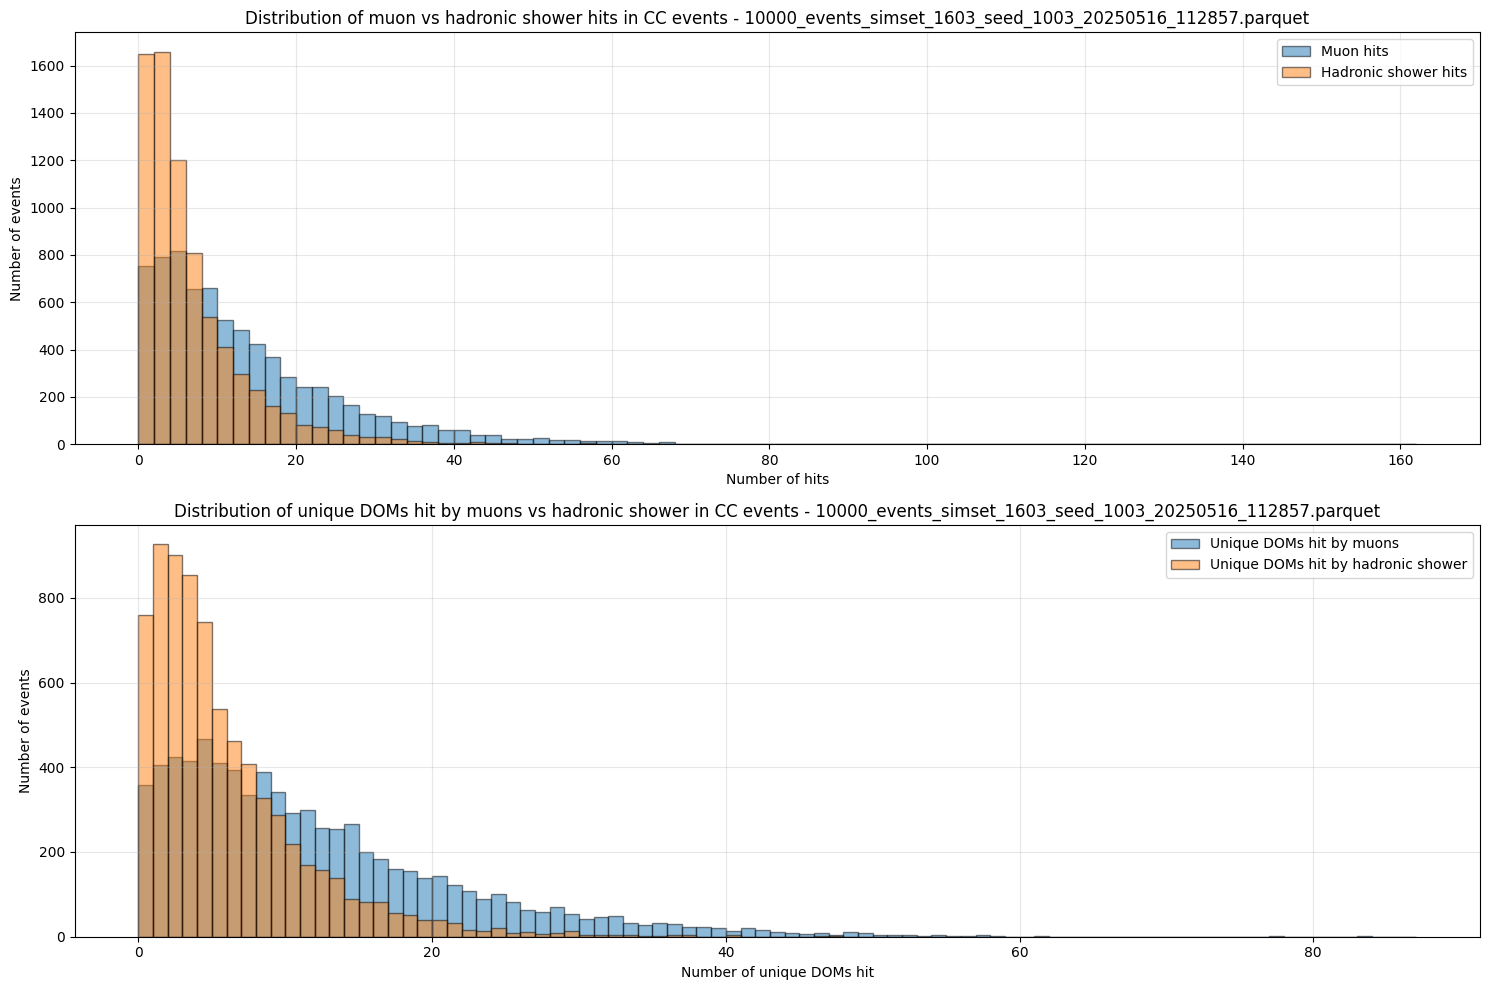

Processed file with 7497 CC events

Processing 10000_events_simset_1604_seed_1004_20250516_112923.parquet...
Loaded 10000 events
Found 7535 CC events and 2465 NC events


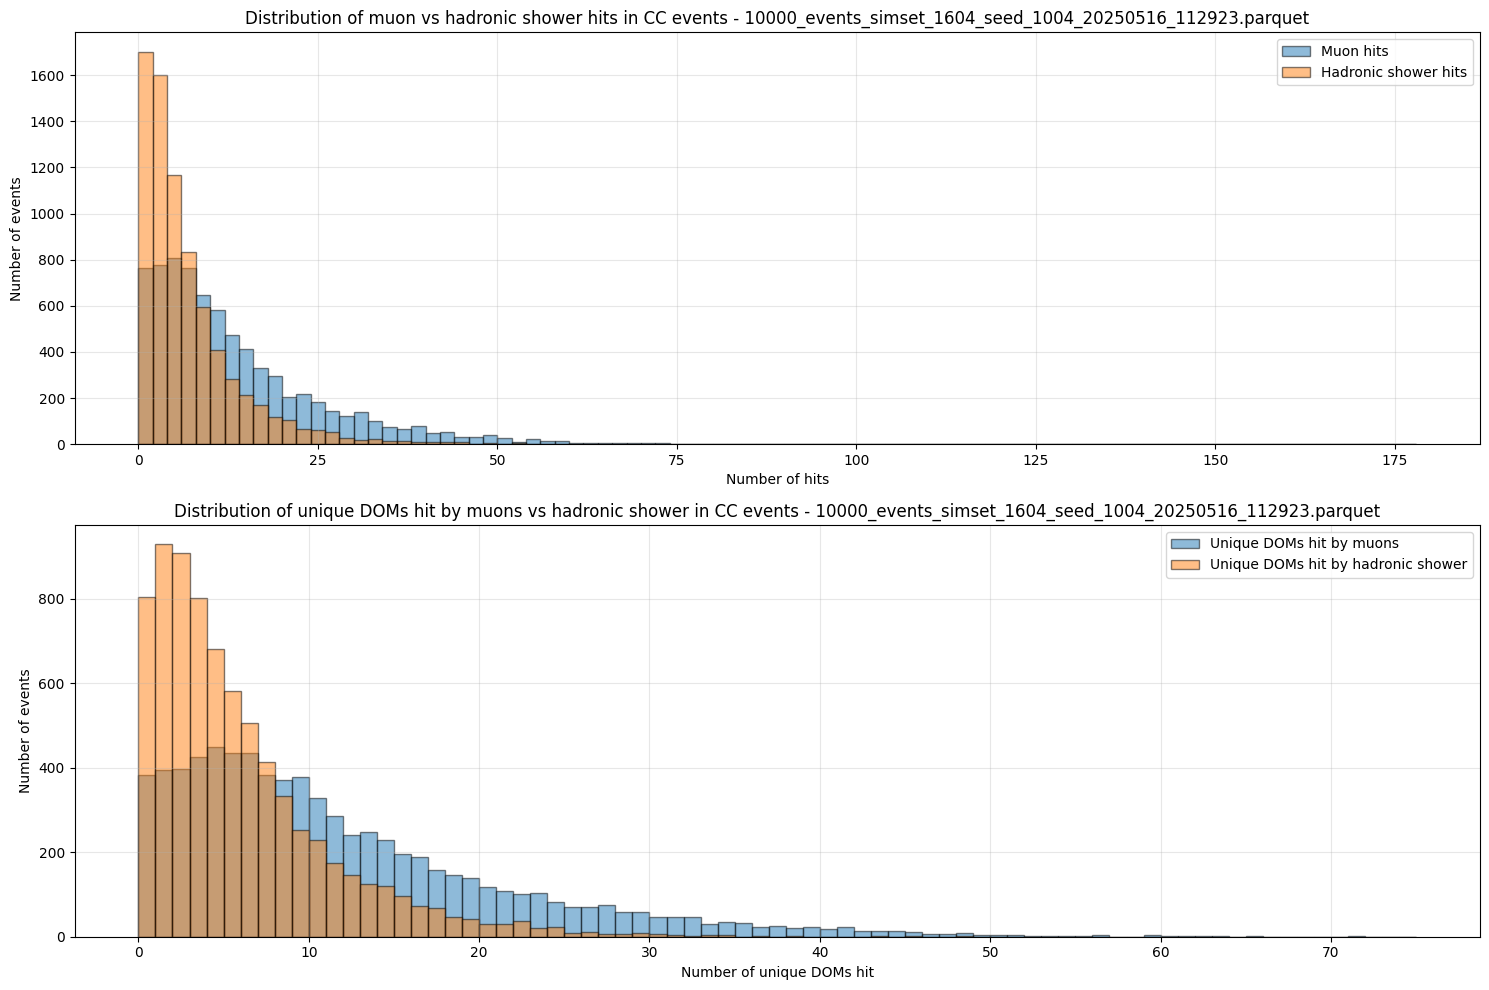

Processed file with 7535 CC events

Processing 10000_events_simset_1605_seed_1005_20250516_112950.parquet...
Loaded 10000 events
Found 7417 CC events and 2583 NC events


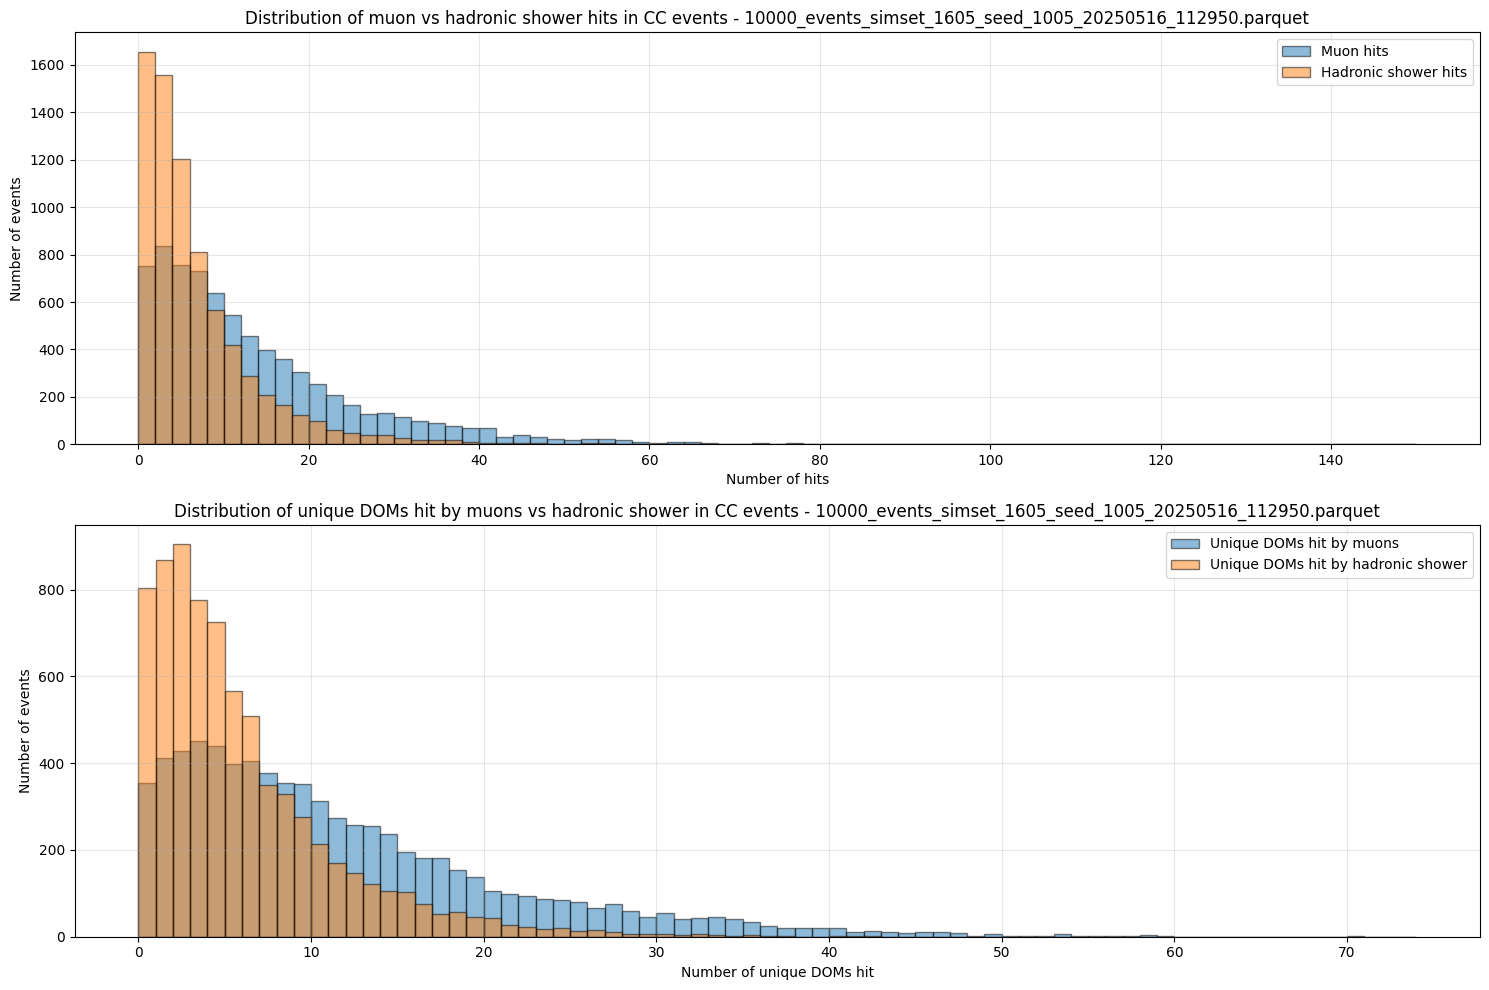

Processed file with 7417 CC events

Creating combined plot for all files...


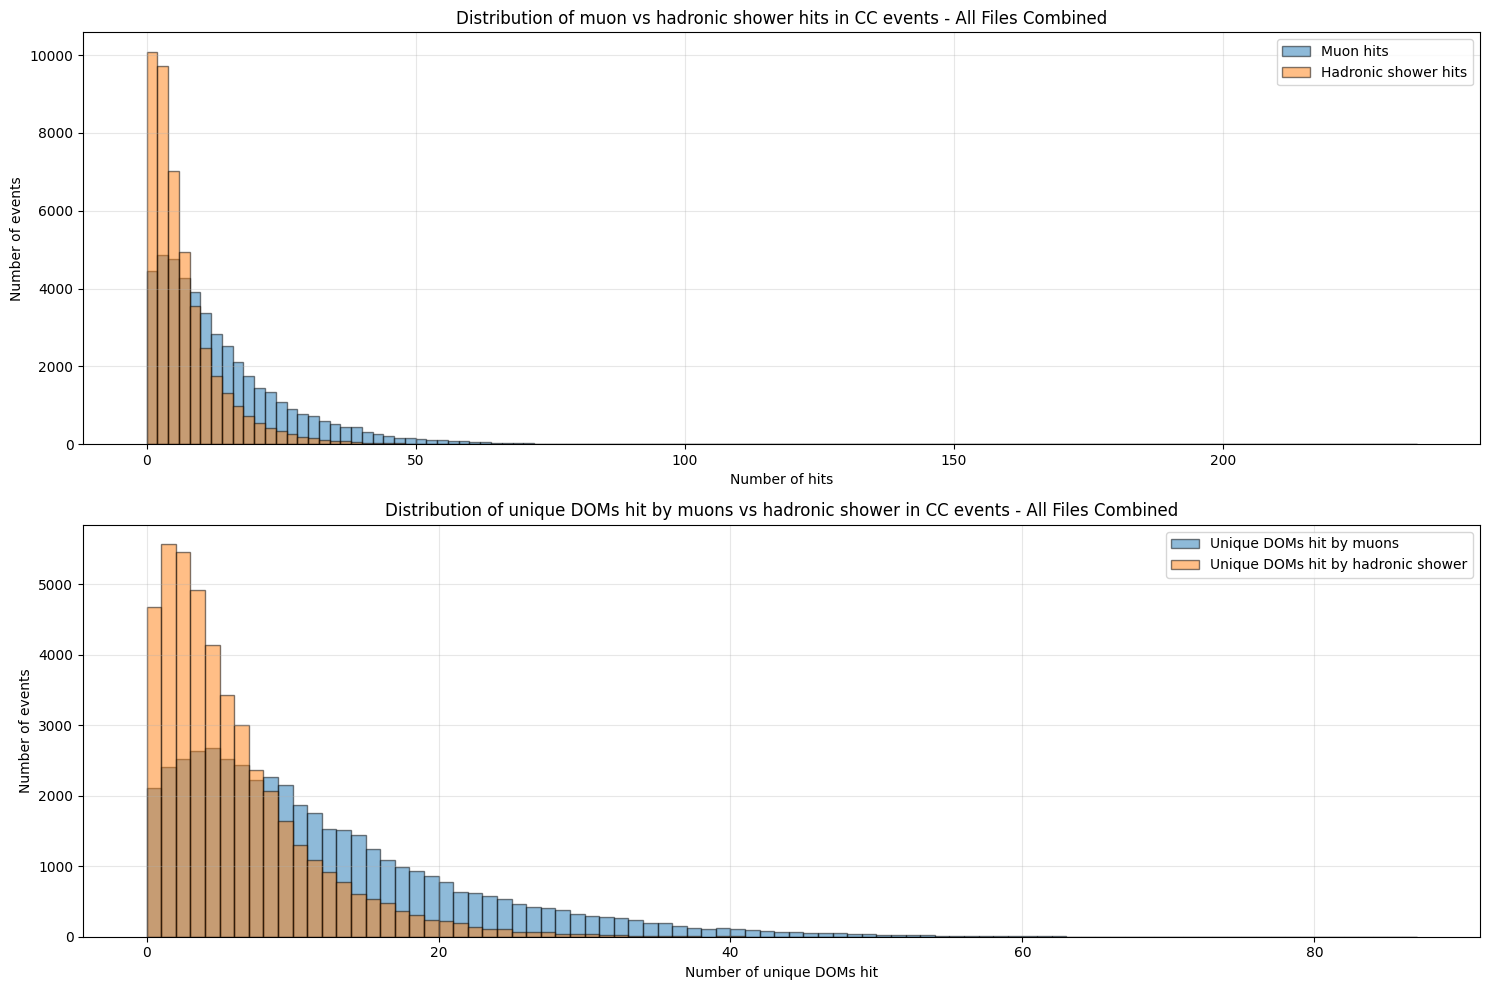


Combined Statistics:
Total CC events analyzed: 45089
Mean muon hits: 13.19
Mean hadron hits: 6.46
Mean unique muon DOMs: 11.40
Mean unique hadron DOMs: 5.48


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing your files
data_dir = "output/"

# List of simulation output files
sim_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Initialize arrays to collect data from all files
all_muon_hits = []
all_hadron_hits = []
all_unique_muon_doms = []
all_unique_hadron_doms = []

# Process each file
for sim_file in sim_files:
    file_path = os.path.join(data_dir, sim_file)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    print(f"\nProcessing {sim_file}...")
    
    # Load the file
    df = pd.read_parquet(file_path)
    print(f"Loaded {len(df)} events")
    
    # Get CC and NC events
    nc_idx = []
    cc_idx = []
    
    for i, (idx, row) in enumerate(df.iterrows()):
        if row['mc_truth']['interaction'] == 1:
            cc_idx.append(idx)
        else:
            nc_idx.append(idx)
    
    print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")
    
    # Function to add particle type
    def add_particle_type(event_data):
        try:
            # Get the id_idx array for photons
            id_idx_array = event_data['photons']['id_idx']
            
            # Get the final_state_type array from mc_truth
            final_state_types = event_data['mc_truth']['final_state_type']
            
            # Map id_idx to final_state_type to determine particle type for each hit
            particle_types = []
            for idx in id_idx_array:
                if idx > 0 and idx <= len(final_state_types):
                    particle_types.append(final_state_types[idx-1])
                else:
                    particle_types.append(-1)  # Default if mapping fails
            
            # Convert to numpy array
            return np.array(particle_types)
        except Exception as e:
            print(f"Error adding particle type: {e}")
            return np.array([-1] * len(event_data['photons']['t']))  # Default array if error
    
    # Arrays to store hit counts for CC events
    muon_hits_per_event = np.zeros(len(cc_idx))
    hadron_hits_per_event = np.zeros(len(cc_idx))
    
    # Arrays to store unique DOM hit counts
    unique_muon_doms_per_event = np.zeros(len(cc_idx))
    unique_hadron_doms_per_event = np.zeros(len(cc_idx))
    
    # Process each CC event
    for i, event_idx in enumerate(cc_idx):
        # Get the event data
        event_data = df.iloc[event_idx]
        
        # Add particle_type field
        particle_types = add_particle_type(event_data)
        
        # Skip if we couldn't determine particle types
        if len(particle_types) == 0:
            continue
        
        # Identify muon hits and hadronic shower hits
        muon_mask = (particle_types == 13)
        hadron_mask = (particle_types != 13)
        
        # Count total hits
        muon_hits_per_event[i] = np.sum(muon_mask)
        hadron_hits_per_event[i] = np.sum(hadron_mask)
        
        # For unique DOM counts, we need string_id and sensor_id
        string_ids = event_data['photons']['string_id']
        sensor_ids = event_data['photons']['sensor_id']
        
        # Get unique DOMs hit by muons
        if np.any(muon_mask):
            muon_strings = string_ids[muon_mask]
            muon_sensors = sensor_ids[muon_mask]
            unique_muon_doms_per_event[i] = len(set(zip(muon_strings, muon_sensors)))
        
        # Get unique DOMs hit by hadronic shower
        if np.any(hadron_mask):
            hadron_strings = string_ids[hadron_mask]
            hadron_sensors = sensor_ids[hadron_mask]
            unique_hadron_doms_per_event[i] = len(set(zip(hadron_strings, hadron_sensors)))
    
    # Create histograms for this file
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Total hits distribution
    plt.subplot(2, 1, 1)
    bins = np.arange(0, max(np.max(muon_hits_per_event), np.max(hadron_hits_per_event)) + 10, 2)
    plt.hist(muon_hits_per_event, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black')
    plt.hist(hadron_hits_per_event, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
    plt.xlabel('Number of hits')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of muon vs hadronic shower hits in CC events - {sim_file}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Unique DOMs hit distribution
    plt.subplot(2, 1, 2)
    bins = np.arange(0, max(np.max(unique_muon_doms_per_event), np.max(unique_hadron_doms_per_event)) + 5, 1)
    plt.hist(unique_muon_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
    plt.hist(unique_hadron_doms_per_event, bins=bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
    plt.xlabel('Number of unique DOMs hit')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of unique DOMs hit by muons vs hadronic shower in CC events - {sim_file}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Add data to combined arrays
    all_muon_hits.extend(muon_hits_per_event)
    all_hadron_hits.extend(hadron_hits_per_event)
    all_unique_muon_doms.extend(unique_muon_doms_per_event)
    all_unique_hadron_doms.extend(unique_hadron_doms_per_event)
    
    print(f"Processed file with {len(muon_hits_per_event)} CC events")

# Now create the combined plot
print("\nCreating combined plot for all files...")
plt.figure(figsize=(15, 10))

# Convert to numpy arrays
all_muon_hits = np.array(all_muon_hits)
all_hadron_hits = np.array(all_hadron_hits)
all_unique_muon_doms = np.array(all_unique_muon_doms)
all_unique_hadron_doms = np.array(all_unique_hadron_doms)

# Plot 1: Total hits distribution (combined)
plt.subplot(2, 1, 1)
bins = np.arange(0, max(np.max(all_muon_hits), np.max(all_hadron_hits)) + 10, 2)
plt.hist(all_muon_hits, bins=bins, alpha=0.5, label='Muon hits', edgecolor='black')
plt.hist(all_hadron_hits, bins=bins, alpha=0.5, label='Hadronic shower hits', edgecolor='black')
plt.xlabel('Number of hits')
plt.ylabel('Number of events')
plt.title('Distribution of muon vs hadronic shower hits in CC events - All Files Combined')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Unique DOMs hit distribution (combined)
plt.subplot(2, 1, 2)
bins = np.arange(0, max(np.max(all_unique_muon_doms), np.max(all_unique_hadron_doms)) + 5, 1)
plt.hist(all_unique_muon_doms, bins=bins, alpha=0.5, label='Unique DOMs hit by muons', edgecolor='black')
plt.hist(all_unique_hadron_doms, bins=bins, alpha=0.5, label='Unique DOMs hit by hadronic shower', edgecolor='black')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Number of events')
plt.title('Distribution of unique DOMs hit by muons vs hadronic shower in CC events - All Files Combined')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print stats about the combined data
print("\nCombined Statistics:")
print(f"Total CC events analyzed: {len(all_muon_hits)}")
print(f"Mean muon hits: {np.mean(all_muon_hits):.2f}")
print(f"Mean hadron hits: {np.mean(all_hadron_hits):.2f}")
print(f"Mean unique muon DOMs: {np.mean(all_unique_muon_doms):.2f}")
print(f"Mean unique hadron DOMs: {np.mean(all_unique_hadron_doms):.2f}")

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler


Processing 10000_events_simset_1600_seed_1000_20250516_112519.parquet...
Loaded 10000 events
Found 7601 CC events
Processing event 0/7601...
Processing event 100/7601...
Processing event 200/7601...
Processing event 300/7601...
Processing event 400/7601...
Processing event 500/7601...
Processing event 600/7601...
Processing event 700/7601...
Processing event 800/7601...
Processing event 900/7601...
Processing event 1000/7601...
Processing event 1100/7601...
Processing event 1200/7601...
Processing event 1300/7601...
Processing event 1400/7601...
Processing event 1500/7601...
Processing event 1600/7601...
Processing event 1700/7601...
Processing event 1800/7601...
Processing event 1900/7601...
Processing event 2000/7601...
Processing event 2100/7601...
Processing event 2200/7601...
Processing event 2300/7601...
Processing event 2400/7601...
Processing event 2500/7601...
Processing event 2600/7601...
Processing event 2700/7601...
Processing event 2800/7601...
Processing event 2900/7601.

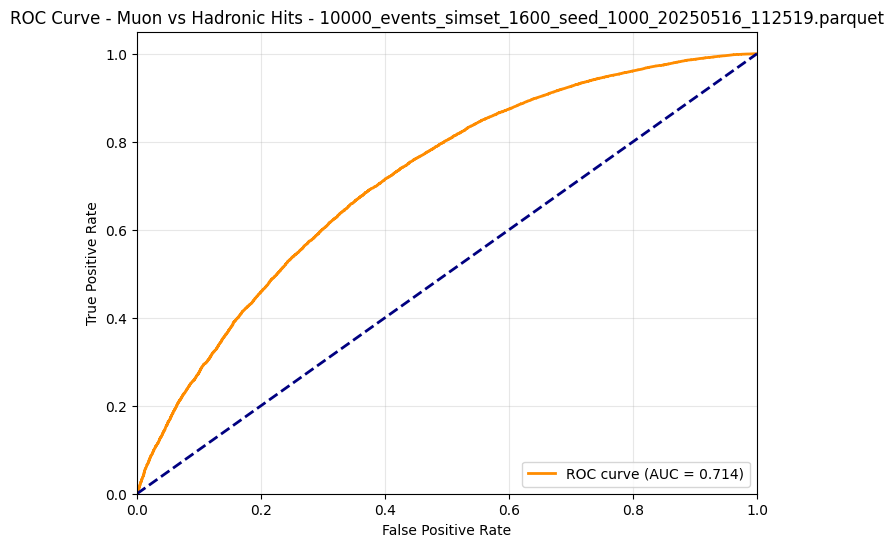

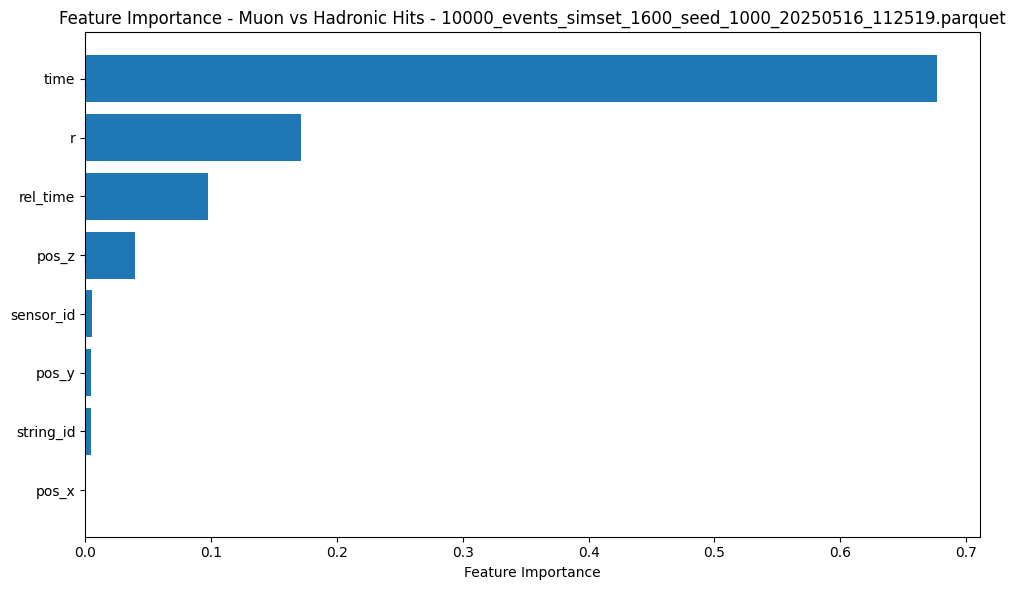


Processing 10000_events_simset_1601_seed_1001_20250516_112659.parquet...
Loaded 10000 events
Found 7517 CC events
Processing event 0/7517...
Processing event 100/7517...
Processing event 200/7517...
Processing event 300/7517...
Processing event 400/7517...
Processing event 500/7517...
Processing event 600/7517...
Processing event 700/7517...
Processing event 800/7517...
Processing event 900/7517...
Processing event 1000/7517...
Processing event 1100/7517...
Processing event 1200/7517...
Processing event 1300/7517...
Processing event 1400/7517...
Processing event 1500/7517...
Processing event 1600/7517...
Processing event 1700/7517...
Processing event 1800/7517...
Processing event 1900/7517...
Processing event 2000/7517...
Processing event 2100/7517...
Processing event 2200/7517...
Processing event 2300/7517...
Processing event 2400/7517...
Processing event 2500/7517...
Processing event 2600/7517...
Processing event 2700/7517...
Processing event 2800/7517...
Processing event 2900/7517.

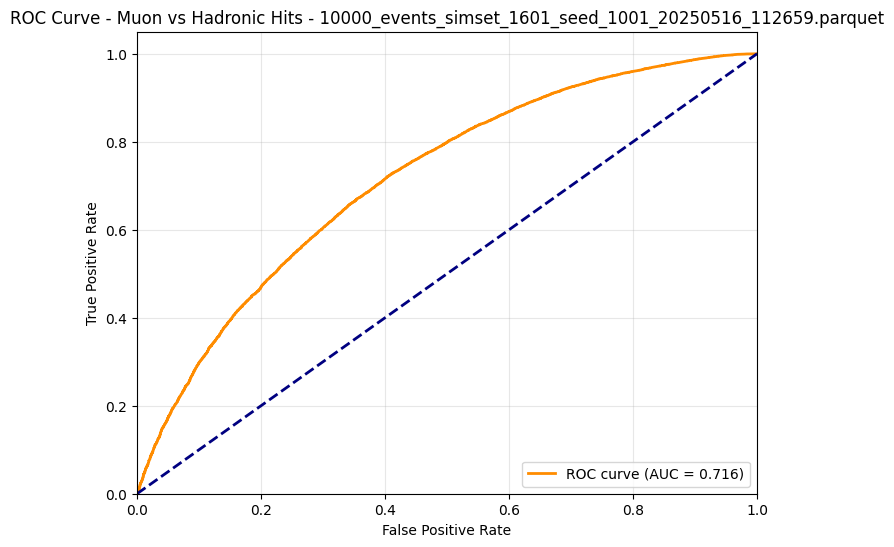

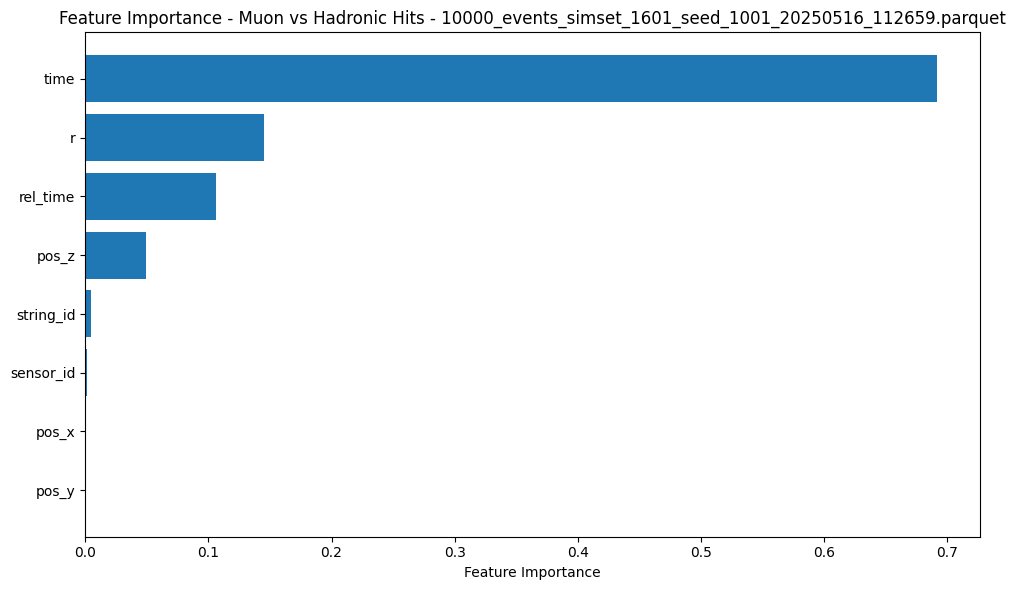


Processing 10000_events_simset_1602_seed_1002_20250516_112840.parquet...
Loaded 10000 events
Found 7522 CC events
Processing event 0/7522...
Processing event 100/7522...
Processing event 200/7522...
Processing event 300/7522...
Processing event 400/7522...
Processing event 500/7522...
Processing event 600/7522...
Processing event 700/7522...
Processing event 800/7522...
Processing event 900/7522...
Processing event 1000/7522...
Processing event 1100/7522...
Processing event 1200/7522...
Processing event 1300/7522...
Processing event 1400/7522...
Processing event 1500/7522...
Processing event 1600/7522...
Processing event 1700/7522...
Processing event 1800/7522...
Processing event 1900/7522...
Processing event 2000/7522...
Processing event 2100/7522...
Processing event 2200/7522...
Processing event 2300/7522...
Processing event 2400/7522...
Processing event 2500/7522...
Processing event 2600/7522...
Processing event 2700/7522...
Processing event 2800/7522...
Processing event 2900/7522.

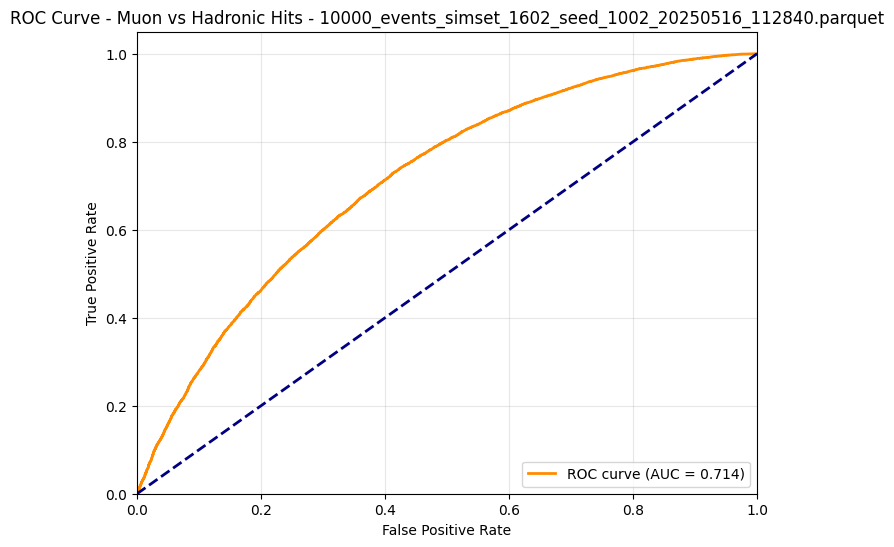

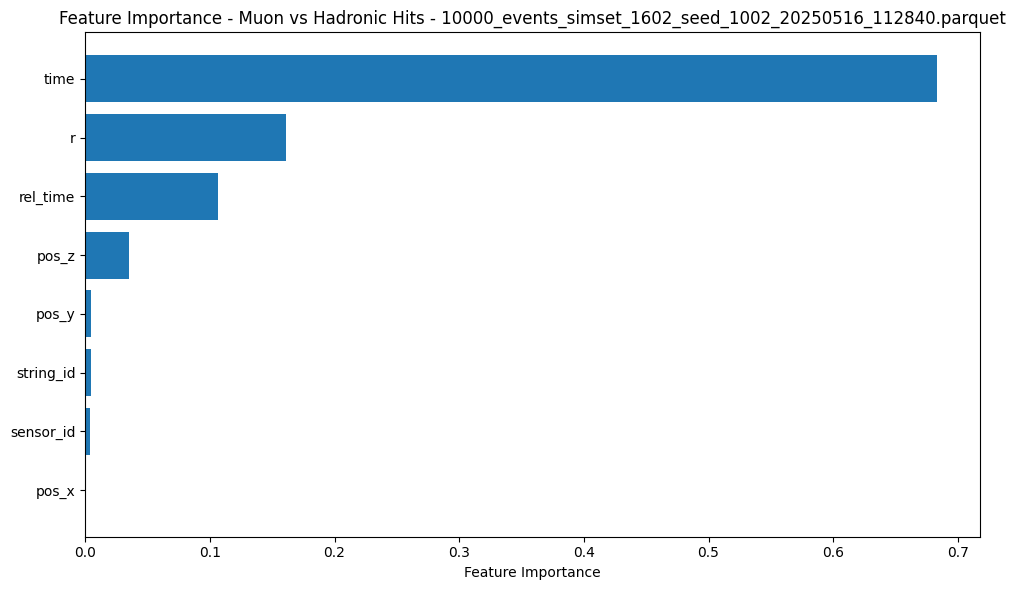


Processing 10000_events_simset_1603_seed_1003_20250516_112857.parquet...
Loaded 10000 events
Found 7497 CC events
Processing event 0/7497...
Processing event 100/7497...
Processing event 200/7497...
Processing event 300/7497...
Processing event 400/7497...
Processing event 500/7497...
Processing event 600/7497...
Processing event 700/7497...
Processing event 800/7497...
Processing event 900/7497...
Processing event 1000/7497...
Processing event 1100/7497...
Processing event 1200/7497...
Processing event 1300/7497...
Processing event 1400/7497...
Processing event 1500/7497...
Processing event 1600/7497...
Processing event 1700/7497...
Processing event 1800/7497...
Processing event 1900/7497...
Processing event 2000/7497...
Processing event 2100/7497...
Processing event 2200/7497...
Processing event 2300/7497...
Processing event 2400/7497...
Processing event 2500/7497...
Processing event 2600/7497...
Processing event 2700/7497...
Processing event 2800/7497...
Processing event 2900/7497.

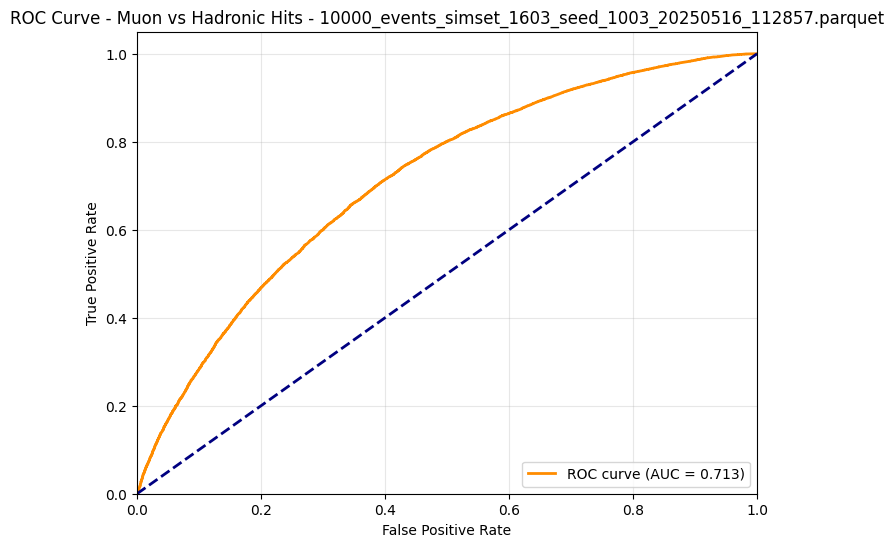

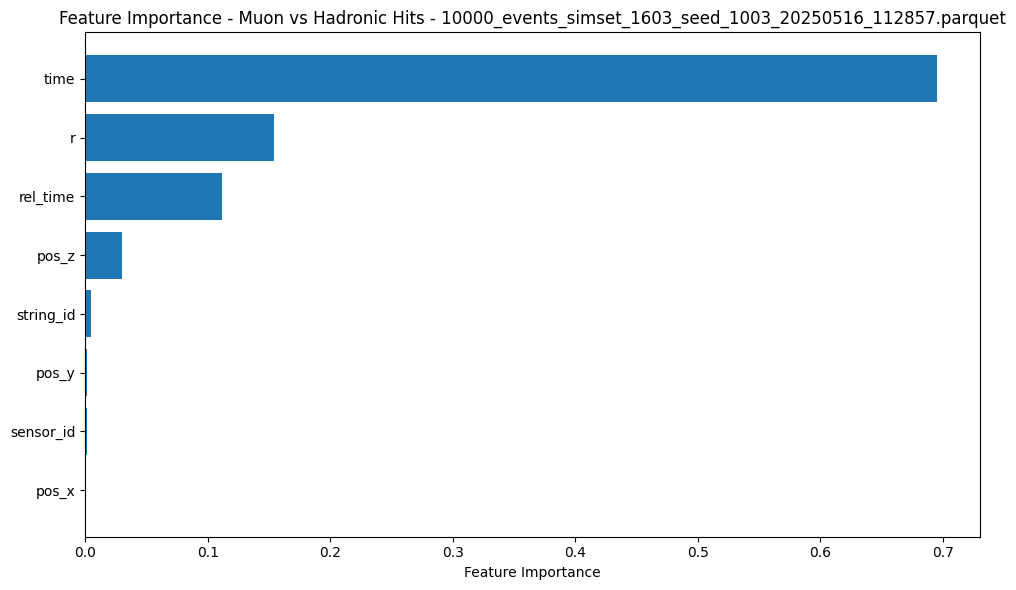


Processing 10000_events_simset_1604_seed_1004_20250516_112923.parquet...
Loaded 10000 events
Found 7535 CC events
Processing event 0/7535...
Processing event 100/7535...
Processing event 200/7535...
Processing event 300/7535...
Processing event 400/7535...
Processing event 500/7535...
Processing event 600/7535...
Processing event 700/7535...
Processing event 800/7535...
Processing event 900/7535...
Processing event 1000/7535...
Processing event 1100/7535...
Processing event 1200/7535...
Processing event 1300/7535...
Processing event 1400/7535...
Processing event 1500/7535...
Processing event 1600/7535...
Processing event 1700/7535...
Processing event 1800/7535...
Processing event 1900/7535...
Processing event 2000/7535...
Processing event 2100/7535...
Processing event 2200/7535...
Processing event 2300/7535...
Processing event 2400/7535...
Processing event 2500/7535...
Processing event 2600/7535...
Processing event 2700/7535...
Processing event 2800/7535...
Processing event 2900/7535.

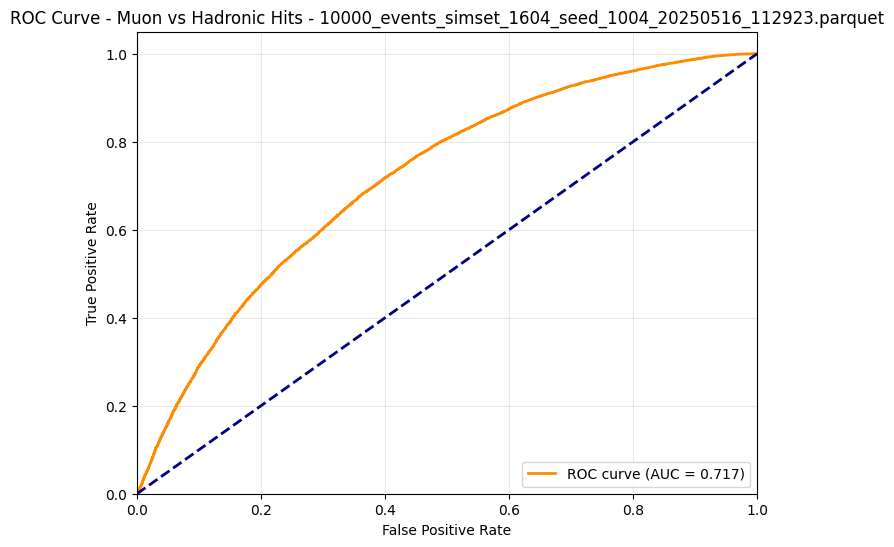

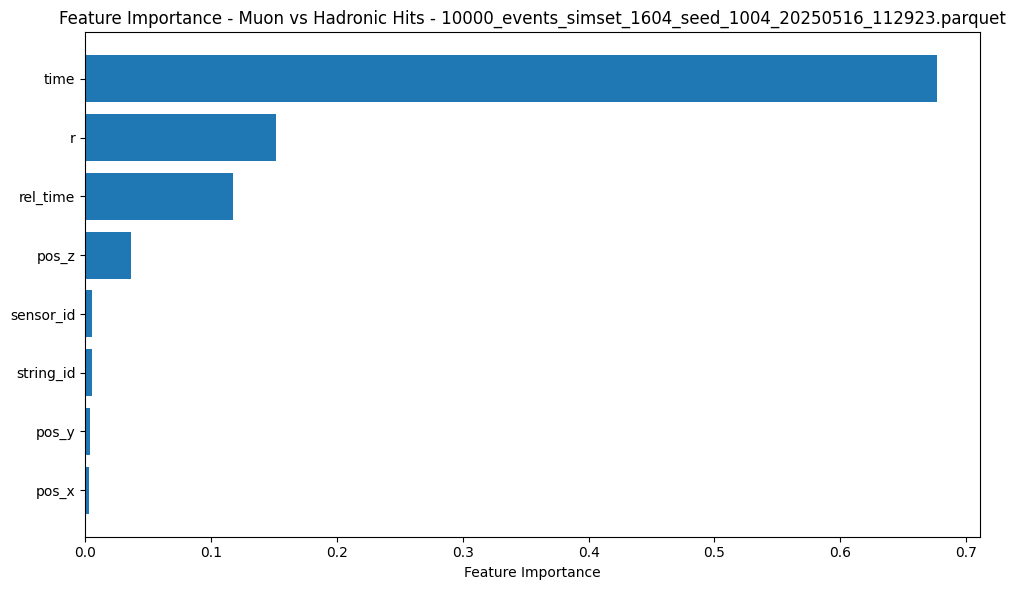


Processing 10000_events_simset_1605_seed_1005_20250516_112950.parquet...
Loaded 10000 events
Found 7417 CC events
Processing event 0/7417...
Processing event 100/7417...
Processing event 200/7417...
Processing event 300/7417...
Processing event 400/7417...
Processing event 500/7417...
Processing event 600/7417...
Processing event 700/7417...
Processing event 800/7417...
Processing event 900/7417...
Processing event 1000/7417...
Processing event 1100/7417...
Processing event 1200/7417...
Processing event 1300/7417...
Processing event 1400/7417...
Processing event 1500/7417...
Processing event 1600/7417...
Processing event 1700/7417...
Processing event 1800/7417...
Processing event 1900/7417...
Processing event 2000/7417...
Processing event 2100/7417...
Processing event 2200/7417...
Processing event 2300/7417...
Processing event 2400/7417...
Processing event 2500/7417...
Processing event 2600/7417...
Processing event 2700/7417...
Processing event 2800/7417...
Processing event 2900/7417.

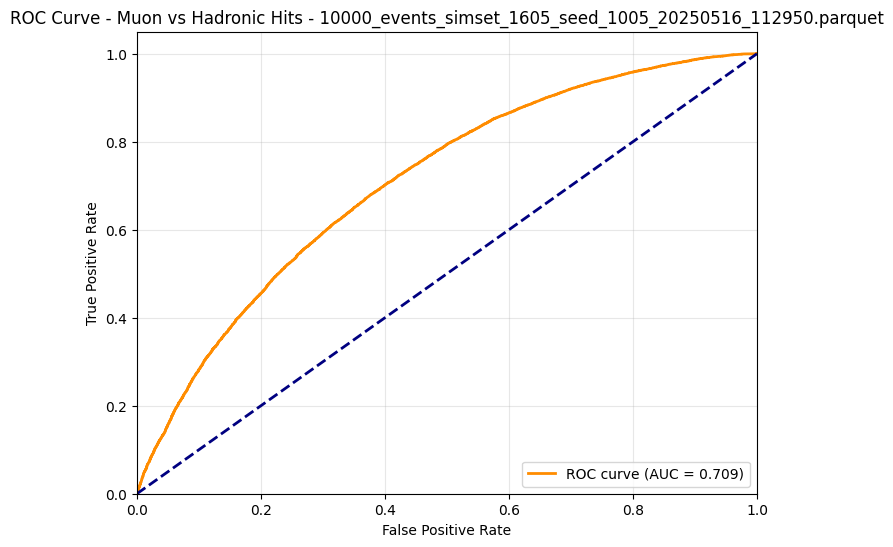

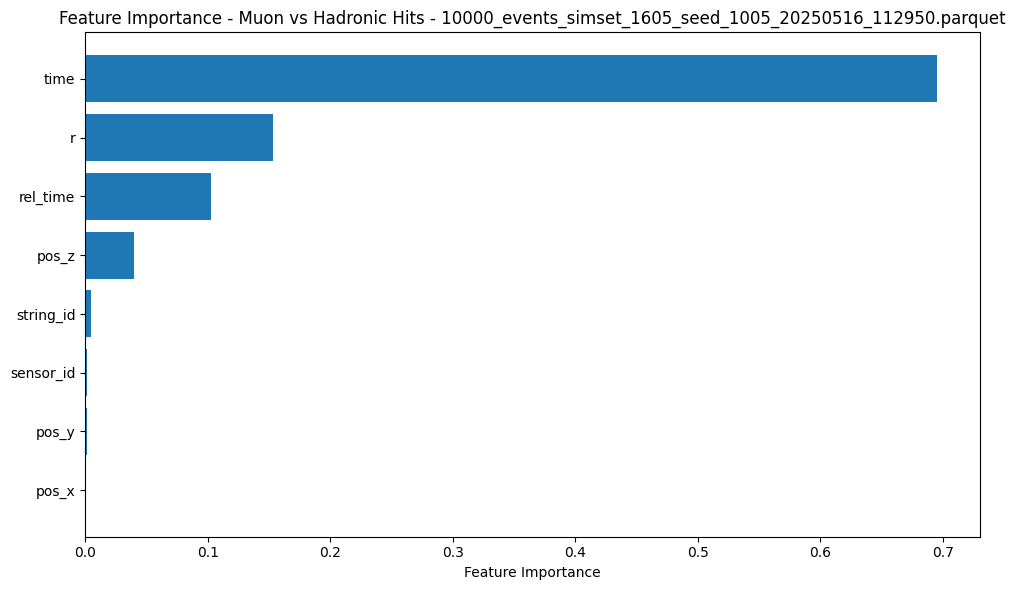


Training BDT on combined dataset...
Combined dataset has 886258 hits
Class distribution: label
1    594905
0    291353
Name: count, dtype: int64
Training BDT on combined dataset...
Combined BDT Performance:
  Accuracy: 0.7178
  Precision: 0.7285
  Recall: 0.9233
  F1 Score: 0.8144
  ROC AUC: 0.7145


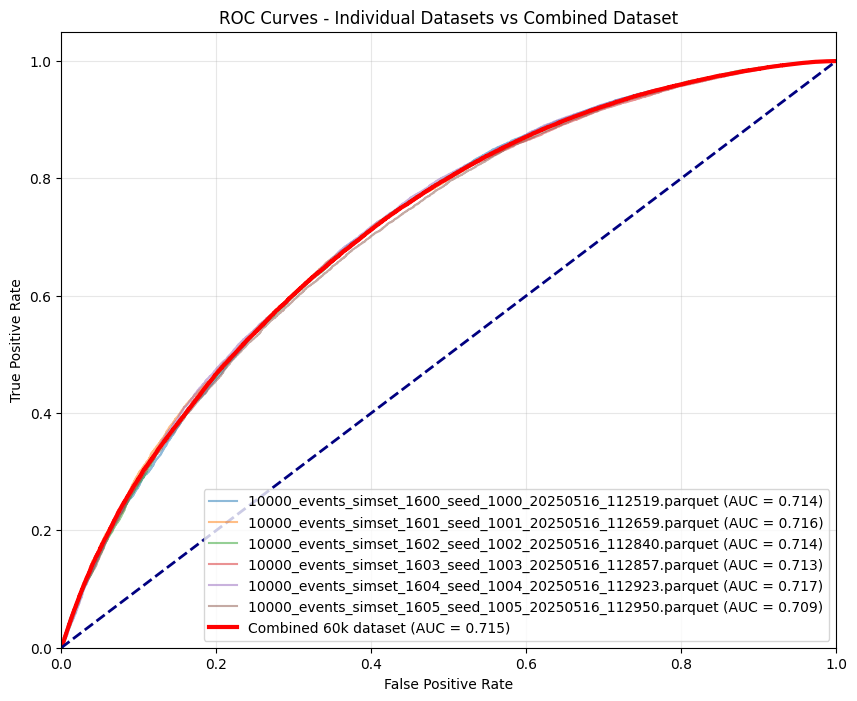

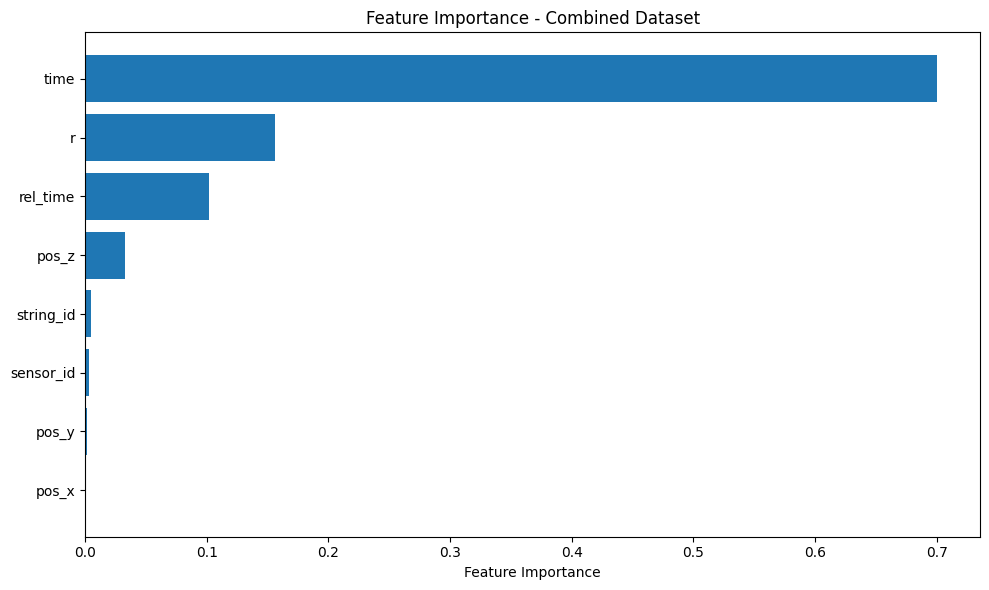

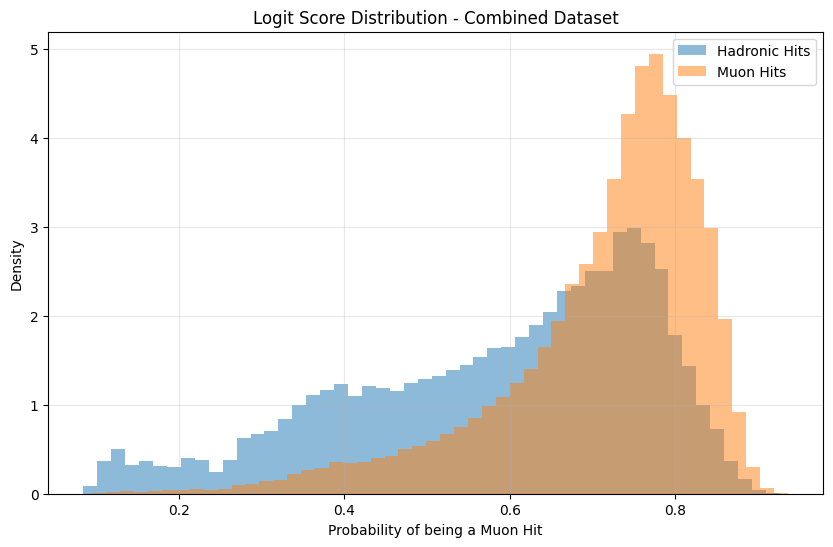


Summary of BDT Performance:
File                                     Accuracy   Precision  Recall     F1 Score   ROC AUC   
10000_events_simset_1600_seed_1000_20250516_112519.parquet 0.7209     0.7311     0.9258     0.8170     0.7141    
10000_events_simset_1601_seed_1001_20250516_112659.parquet 0.7204     0.7317     0.9237     0.8166     0.7160    
10000_events_simset_1602_seed_1002_20250516_112840.parquet 0.7168     0.7272     0.9236     0.8137     0.7135    
10000_events_simset_1603_seed_1003_20250516_112857.parquet 0.7166     0.7306     0.9180     0.8137     0.7125    
10000_events_simset_1604_seed_1004_20250516_112923.parquet 0.7208     0.7314     0.9229     0.8161     0.7170    
10000_events_simset_1605_seed_1005_20250516_112950.parquet 0.7131     0.7239     0.9198     0.8102     0.7086    
COMBINED DATASET                         0.7178     0.7285     0.9233     0.8144     0.7145    


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Directory containing your files
data_dir = "output/"

# List of simulation output files
sim_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Function to add particle type and extract features
def extract_hit_features(event_data):
    try:
        # Get photon data
        photons = event_data['photons']
        
        # Get hit information
        hit_times = photons['t']
        pos_x = photons['sensor_pos_x']
        pos_y = photons['sensor_pos_y']
        pos_z = photons['sensor_pos_z']
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        
        # Skip if no hits
        if len(hit_times) == 0:
            return []
        
        # Get the id_idx array for mapping to particle types
        id_idx_array = photons['id_idx']
        
        # Get the final_state_type array from mc_truth
        final_state_types = event_data['mc_truth']['final_state_type']
        
        # Map id_idx to final_state_type to determine particle type for each hit
        labels = []
        for idx in id_idx_array:
            if idx > 0 and idx <= len(final_state_types):
                pdg_code = final_state_types[idx-1]
                labels.append(1 if pdg_code == 13 else 0)  # 1 for muon, 0 for hadronic
            else:
                labels.append(0)  # Default to hadronic if mapping fails
        
        # Calculate additional features
        # Calculate event center
        center_x = np.mean(pos_x)
        center_y = np.mean(pos_y)
        center_z = np.mean(pos_z)
        
        # Calculate mean time
        mean_time = np.mean(hit_times)
        
        # Create features array
        features = []
        for i in range(len(hit_times)):
            # Distance from center
            r = np.sqrt((pos_x[i] - center_x)**2 + (pos_y[i] - center_y)**2 + (pos_z[i] - center_z)**2)
            
            # Time relative to mean
            rel_time = hit_times[i] - mean_time
            
            # Feature dict for this hit
            feature = {
                'time': hit_times[i],
                'rel_time': rel_time,
                'pos_x': pos_x[i],
                'pos_y': pos_y[i],
                'pos_z': pos_z[i],
                'r': r,
                'string_id': string_ids[i],
                'sensor_id': sensor_ids[i],
                'label': labels[i]  # 1 for muon, 0 for hadronic
            }
            features.append(feature)
        
        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return []

# Lists to store results
results = []
all_features = []  # For combined 60k classifier

# Process each file
for sim_file in sim_files:
    file_path = os.path.join(data_dir, sim_file)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    print(f"\nProcessing {sim_file}...")
    
    # Load the file
    df = pd.read_parquet(file_path)
    print(f"Loaded {len(df)} events")
    
    # Get CC events (we only care about these for muon vs hadron classification)
    cc_idx = []
    for i, (idx, row) in enumerate(df.iterrows()):
        if row['mc_truth']['interaction'] == 1:
            cc_idx.append(idx)
    
    print(f"Found {len(cc_idx)} CC events")
    
    # Extract features from CC events
    file_features = []
    for i, event_idx in enumerate(cc_idx):
        if i % 100 == 0:  # Progress update
            print(f"Processing event {i}/{len(cc_idx)}...")
        
        # Get the event data
        event_data = df.iloc[event_idx]
        
        # Extract hit features
        hit_features = extract_hit_features(event_data)
        file_features.extend(hit_features)
    
    print(f"Extracted features for {len(file_features)} hits")
    
    # Add to combined dataset
    all_features.extend(file_features)
    
    # Skip BDT if not enough data
    if len(file_features) < 1000:
        print(f"Not enough hits for BDT training, skipping file")
        continue
    
    # Convert to DataFrame
    hit_df = pd.DataFrame(file_features)
    
    # Prepare features and target
    X = hit_df[['time', 'rel_time', 'pos_x', 'pos_y', 'pos_z', 'r', 'string_id', 'sensor_id']]
    y = hit_df['label']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train BDT
    print("Training BDT...")
    bdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    bdt.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = bdt.predict(X_test_scaled)
    y_scores = bdt.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    print(f"BDT Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Store results
    results.append({
        'file': sim_file,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    })
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Muon vs Hadronic Hits - {sim_file}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importance = bdt.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - Muon vs Hadronic Hits - {sim_file}')
    plt.tight_layout()
    plt.show()

# Train a BDT on the combined 60k dataset
print("\nTraining BDT on combined dataset...")
if len(all_features) > 0:
    # Convert to DataFrame
    all_hit_df = pd.DataFrame(all_features)
    
    print(f"Combined dataset has {len(all_hit_df)} hits")
    
    # Check class balance
    class_counts = all_hit_df['label'].value_counts()
    print(f"Class distribution: {class_counts}")
    
    # Prepare features and target
    X = all_hit_df[['time', 'rel_time', 'pos_x', 'pos_y', 'pos_z', 'r', 'string_id', 'sensor_id']]
    y = all_hit_df['label']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train BDT
    print("Training BDT on combined dataset...")
    bdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    bdt.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = bdt.predict(X_test_scaled)
    y_scores = bdt.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    print(f"Combined BDT Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Plot ROC curve for combined data
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curves for individual files
    for result in results:
        plt.plot(result['fpr'], result['tpr'], alpha=0.5, 
                 label=f"{os.path.basename(result['file'])} (AUC = {result['roc_auc']:.3f})")
    
    # Plot ROC curve for combined data
    plt.plot(fpr, tpr, color='red', lw=3, 
             label=f'Combined 60k dataset (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Individual Datasets vs Combined Dataset')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plot feature importance for combined model
    plt.figure(figsize=(10, 6))
    feature_importance = bdt.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance - Combined Dataset')
    plt.tight_layout()
    plt.show()
    
    # Plot logit score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(y_scores[y_test == 0], bins=50, alpha=0.5, label='Hadronic Hits', density=True)
    plt.hist(y_scores[y_test == 1], bins=50, alpha=0.5, label='Muon Hits', density=True)
    plt.xlabel('Probability of being a Muon Hit')
    plt.ylabel('Density')
    plt.title('Logit Score Distribution - Combined Dataset')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No data collected for combined dataset")

# Print summary of results
print("\nSummary of BDT Performance:")
print(f"{'File':<40} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10}")
for result in results:
    file_name = os.path.basename(result['file'])
    print(f"{file_name:<40} {result['accuracy']:<10.4f} {result['precision']:<10.4f} {result['recall']:<10.4f} {result['f1']:<10.4f} {result['roc_auc']:<10.4f}")

if len(all_features) > 0:
    print(f"{'COMBINED DATASET':<40} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {roc_auc:<10.4f}")


Processing 10000_events_simset_1600_seed_1000_20250516_112519.parquet...
Loaded 10000 events
Found 7601 CC events and 2399 NC events

Statistics for 10000_events_simset_1600_seed_1000_20250516_112519.parquet:
CC Events (7601 events):
  Mean hits: 19.65
  Median hits: 16.00
  Mean unique DOMs: 16.18
  Median unique DOMs: 14.00

NC Events (2399 events):
  Mean hits: 6.36
  Median hits: 4.00
  Mean unique DOMs: 5.38
  Median unique DOMs: 4.00


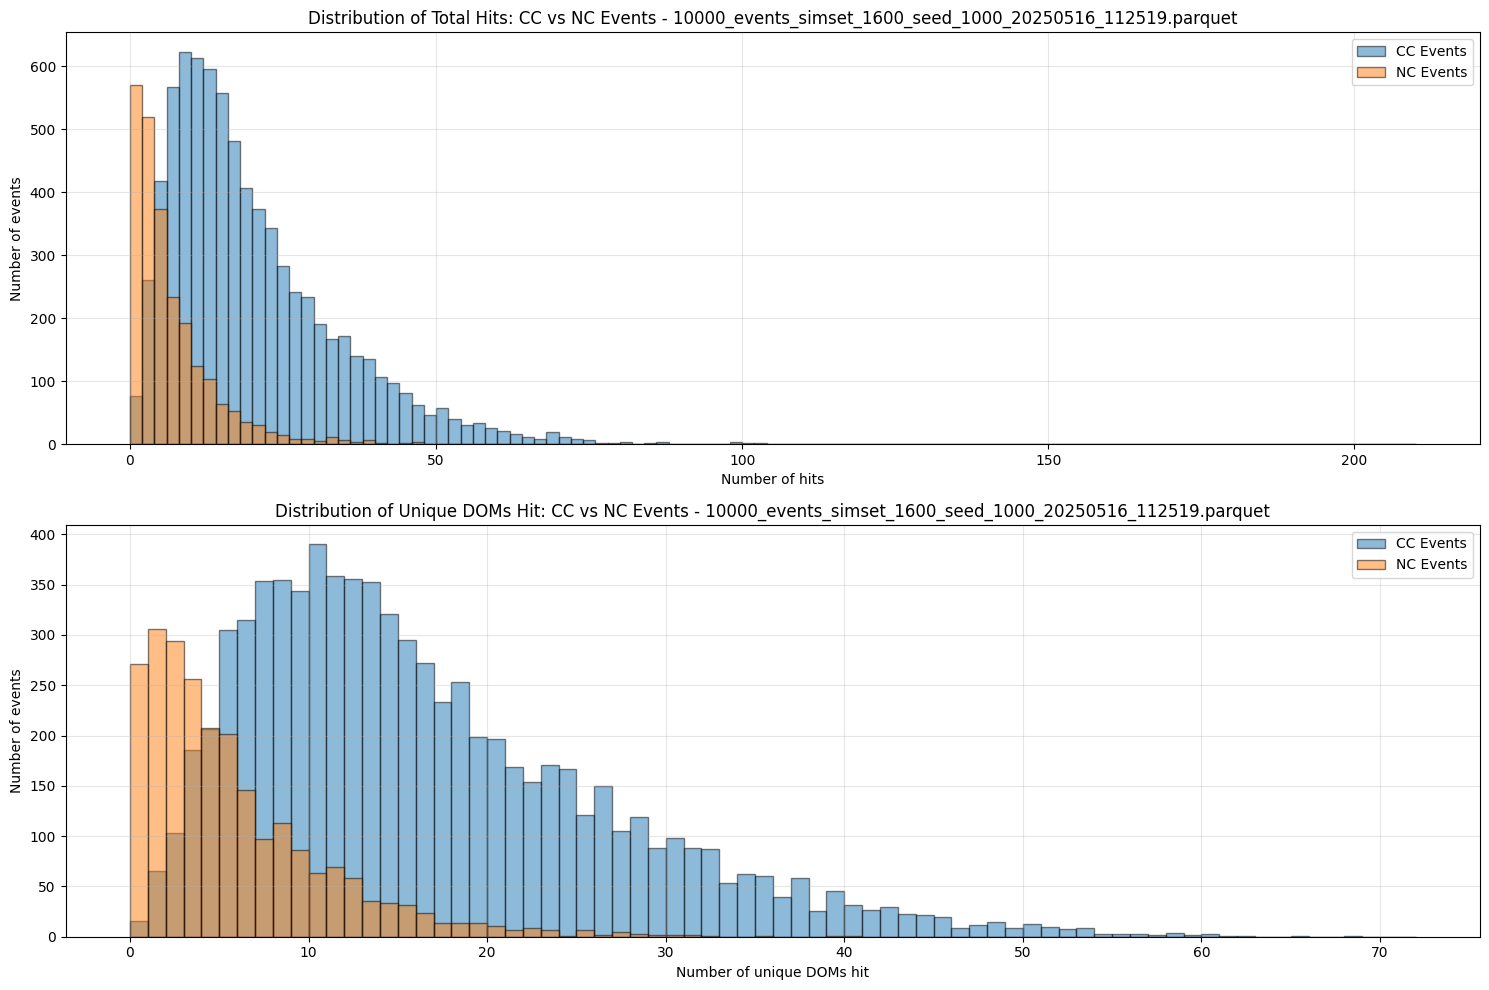

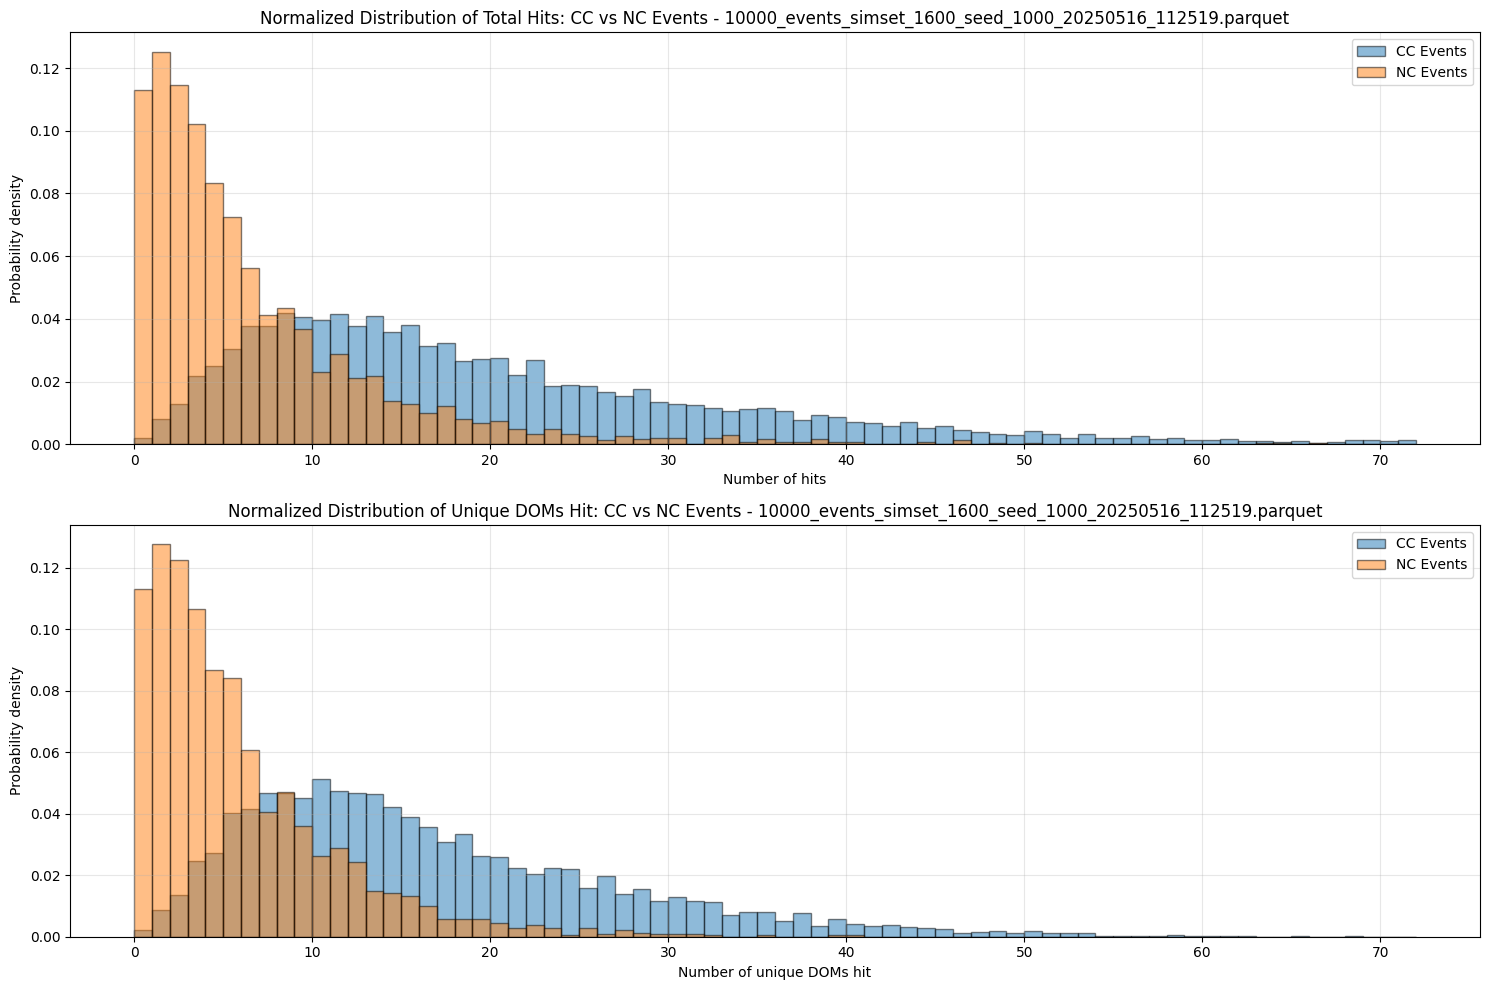


Processing 10000_events_simset_1601_seed_1001_20250516_112659.parquet...
Loaded 10000 events
Found 7517 CC events and 2483 NC events

Statistics for 10000_events_simset_1601_seed_1001_20250516_112659.parquet:
CC Events (7517 events):
  Mean hits: 19.74
  Median hits: 16.00
  Mean unique DOMs: 16.26
  Median unique DOMs: 14.00

NC Events (2483 events):
  Mean hits: 5.96
  Median hits: 4.00
  Mean unique DOMs: 5.00
  Median unique DOMs: 4.00


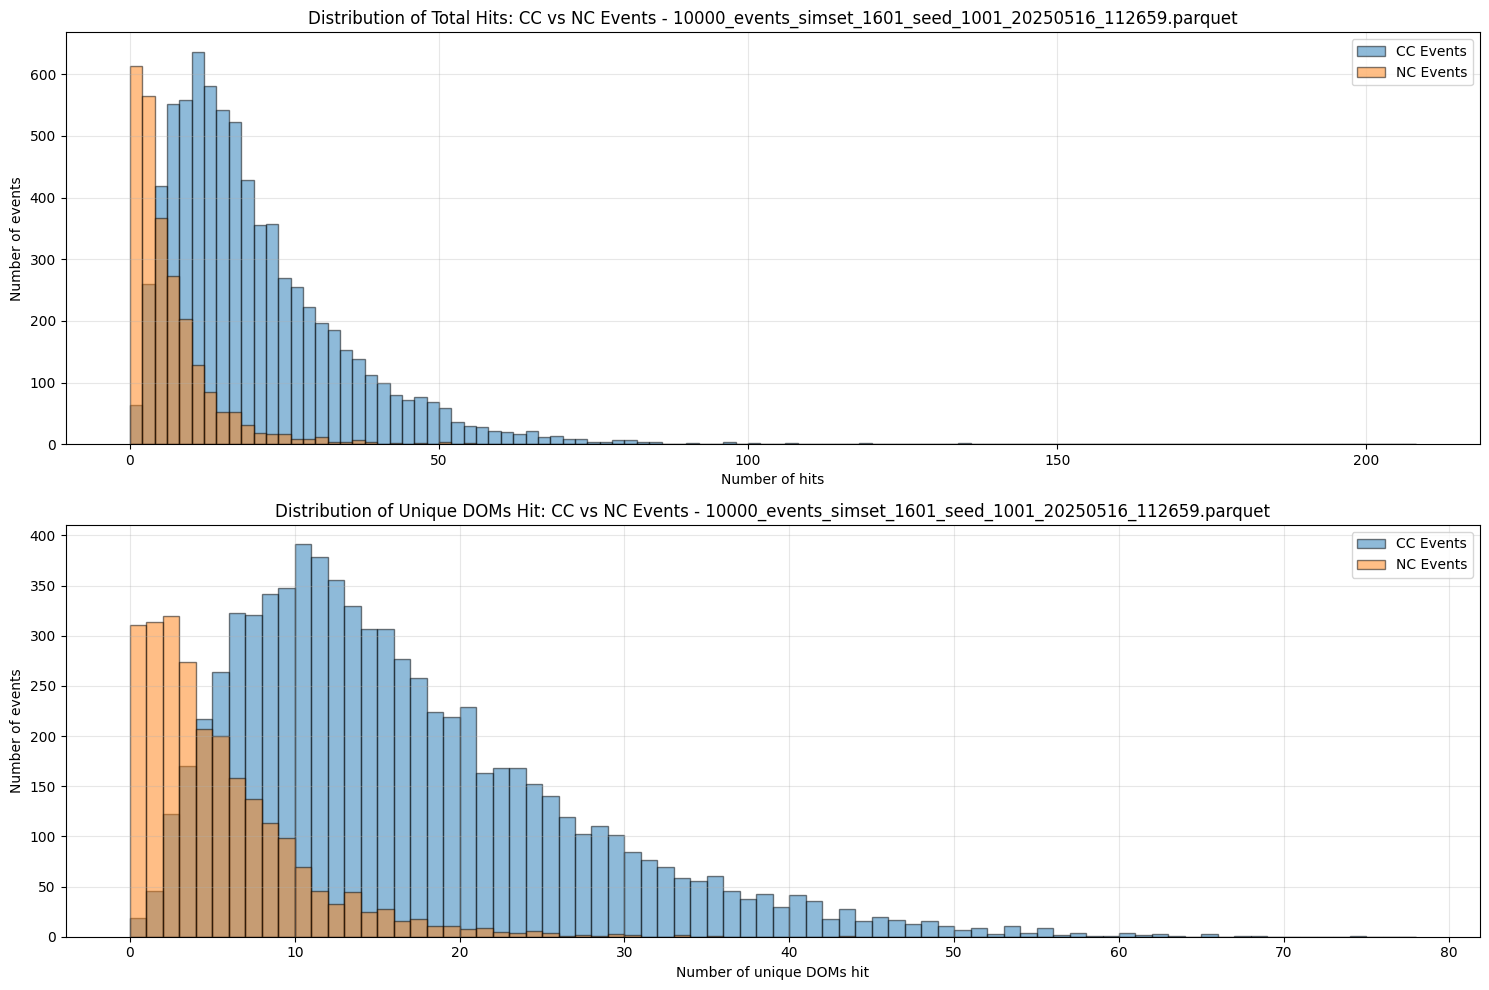

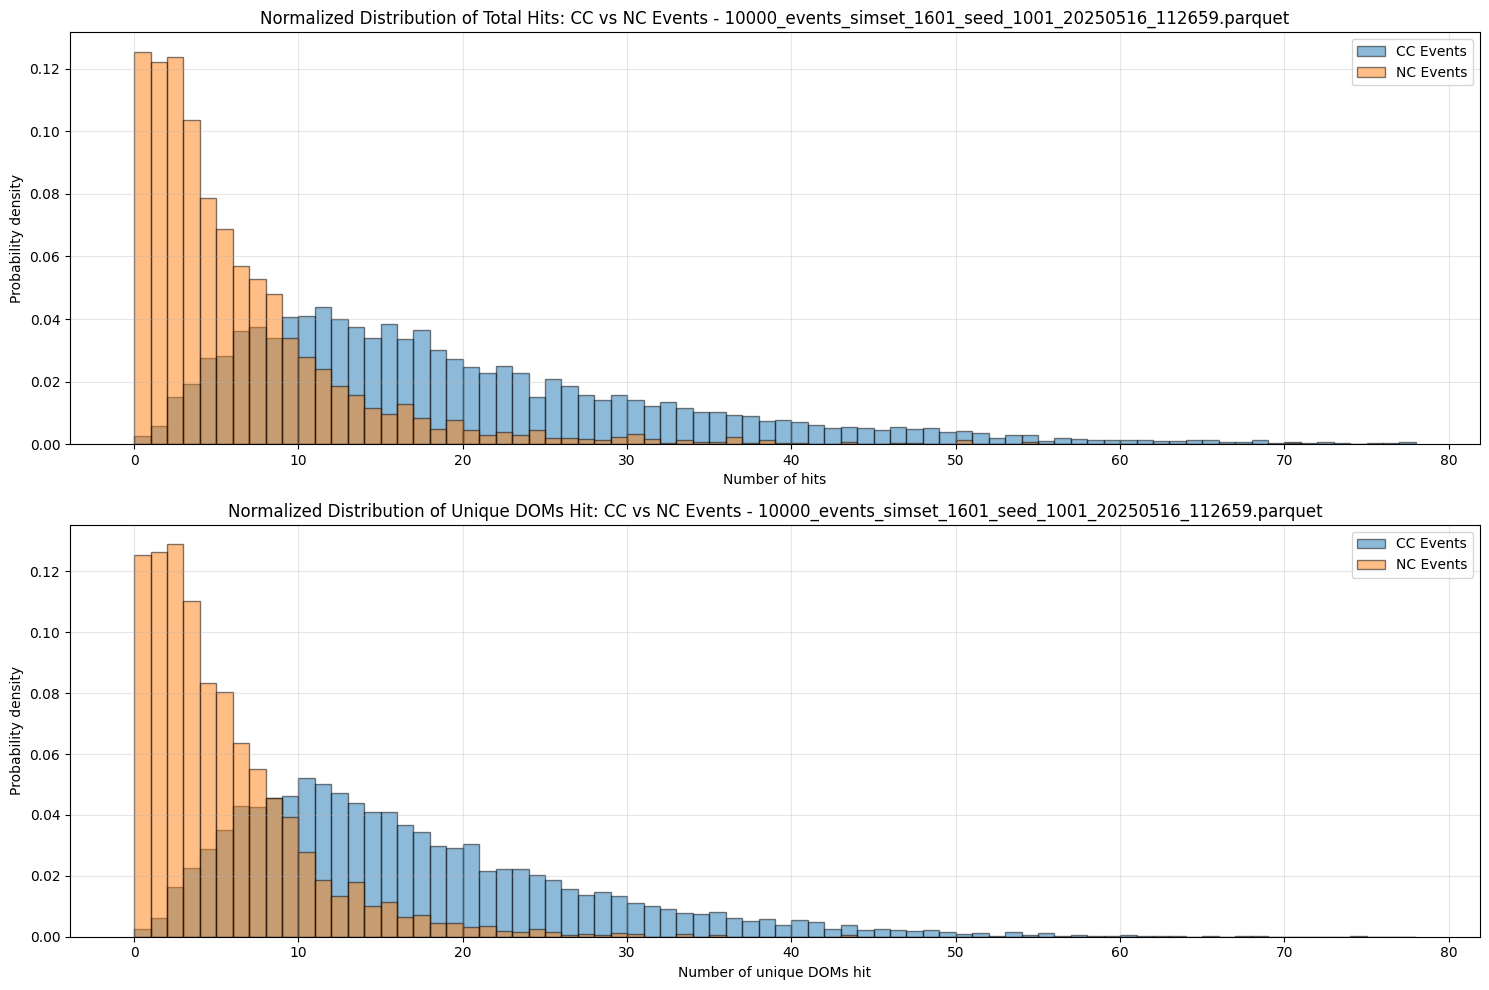


Processing 10000_events_simset_1602_seed_1002_20250516_112840.parquet...
Loaded 10000 events
Found 7522 CC events and 2478 NC events

Statistics for 10000_events_simset_1602_seed_1002_20250516_112840.parquet:
CC Events (7522 events):
  Mean hits: 19.65
  Median hits: 16.00
  Mean unique DOMs: 16.24
  Median unique DOMs: 14.00

NC Events (2478 events):
  Mean hits: 6.27
  Median hits: 4.00
  Mean unique DOMs: 5.26
  Median unique DOMs: 4.00


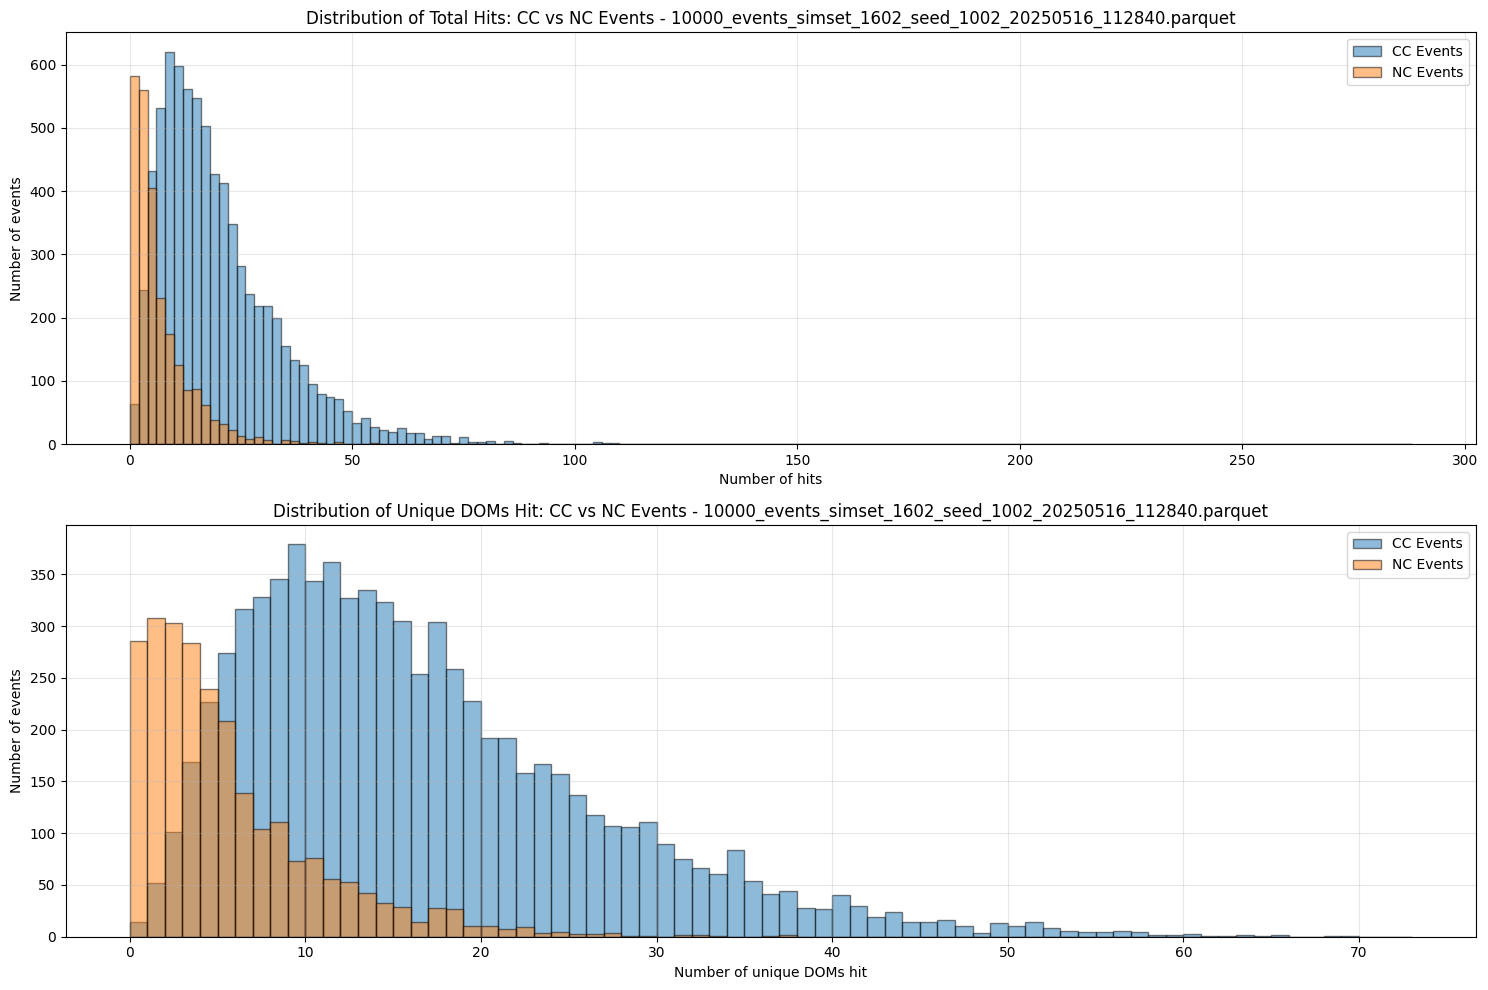

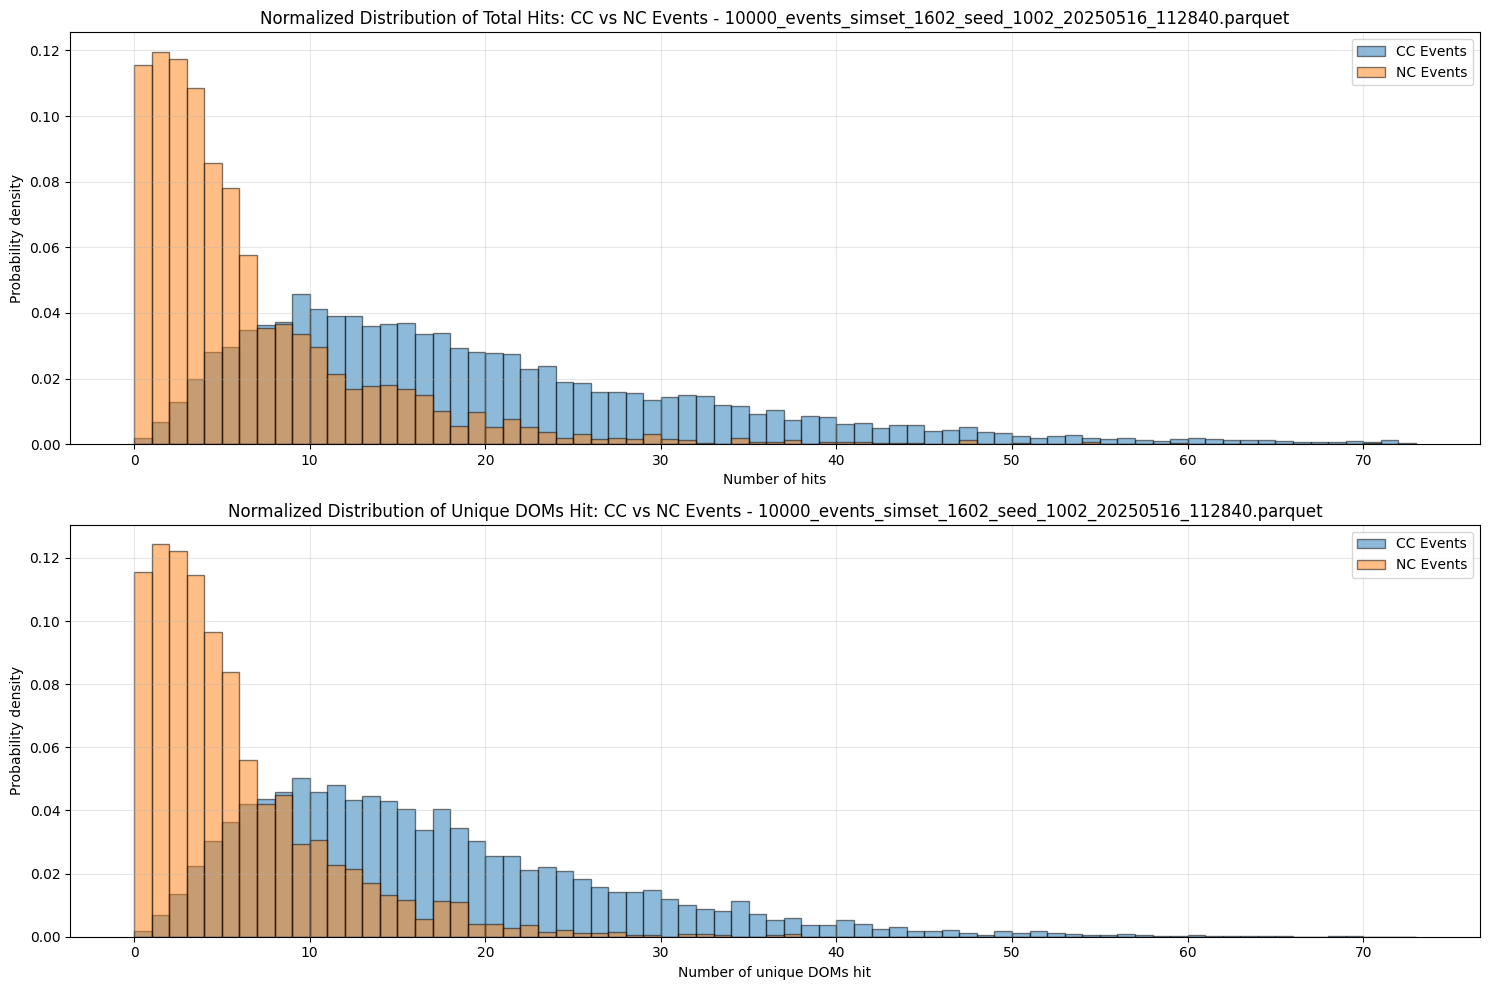


Processing 10000_events_simset_1603_seed_1003_20250516_112857.parquet...
Loaded 10000 events
Found 7497 CC events and 2503 NC events

Statistics for 10000_events_simset_1603_seed_1003_20250516_112857.parquet:
CC Events (7497 events):
  Mean hits: 19.65
  Median hits: 16.00
  Mean unique DOMs: 16.33
  Median unique DOMs: 14.00

NC Events (2503 events):
  Mean hits: 5.98
  Median hits: 4.00
  Mean unique DOMs: 5.08
  Median unique DOMs: 4.00


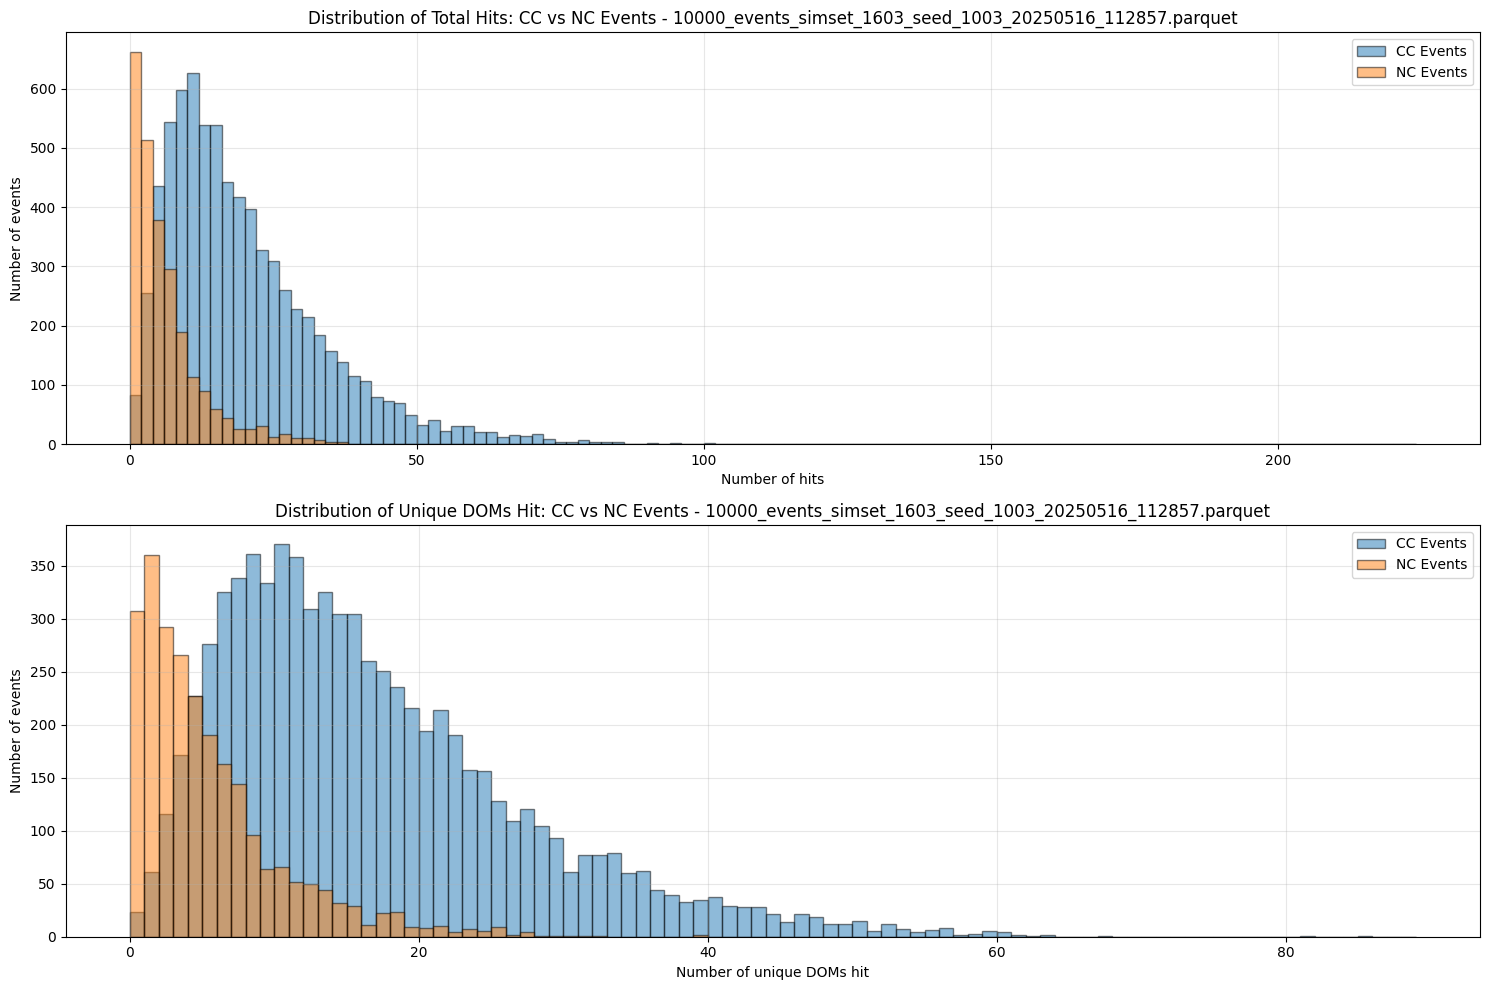

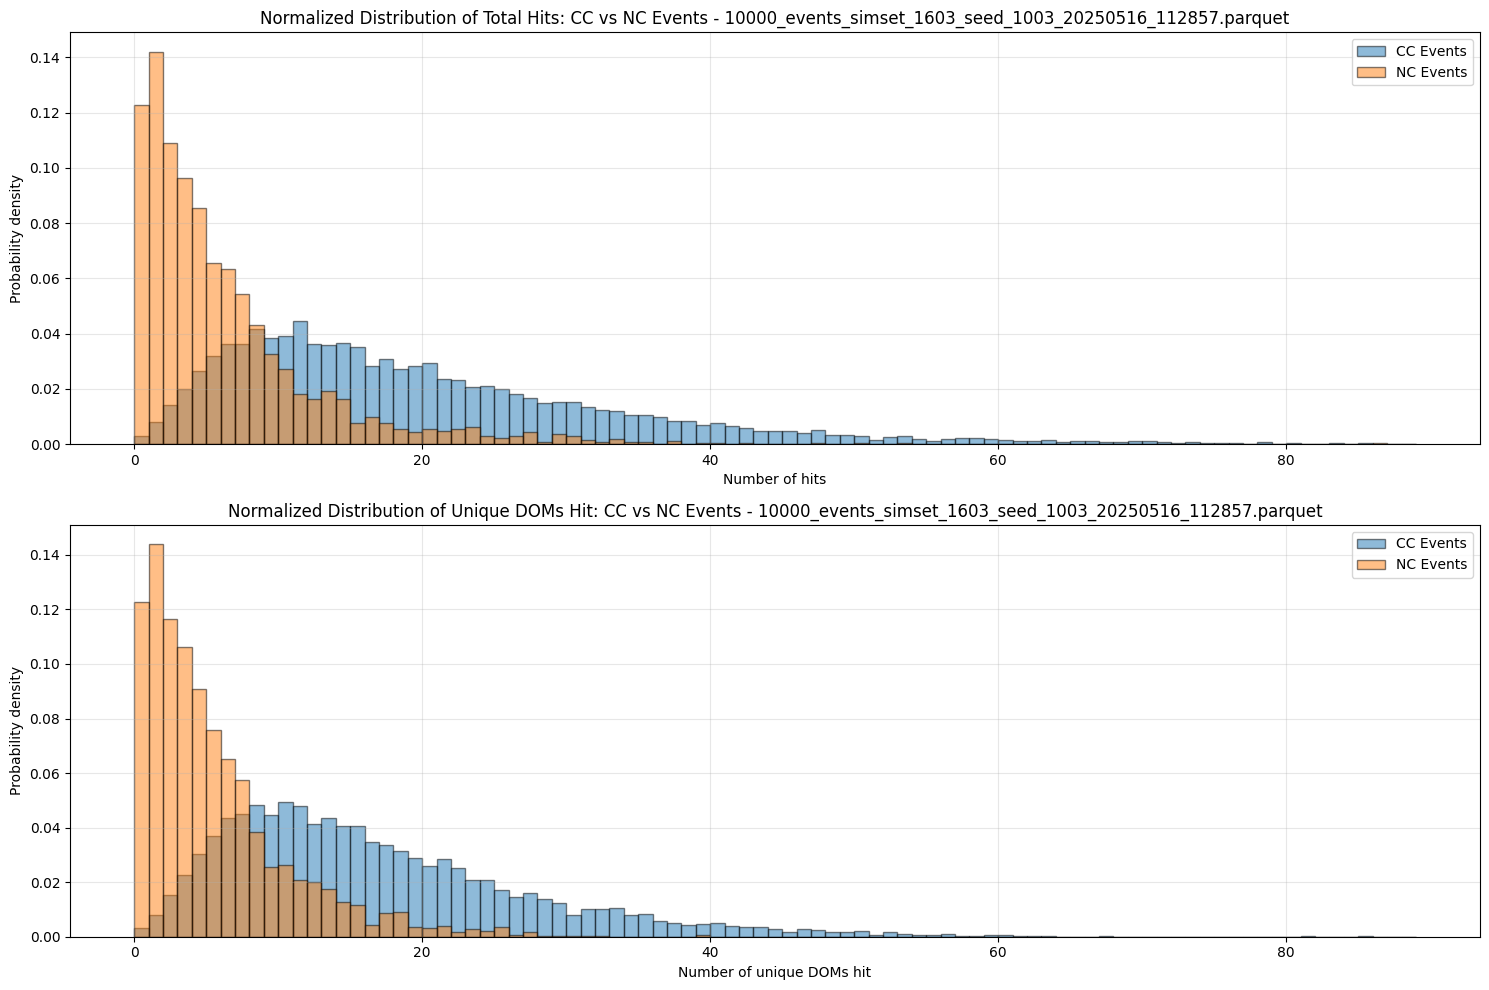


Processing 10000_events_simset_1604_seed_1004_20250516_112923.parquet...
Loaded 10000 events
Found 7535 CC events and 2465 NC events

Statistics for 10000_events_simset_1604_seed_1004_20250516_112923.parquet:
CC Events (7535 events):
  Mean hits: 19.71
  Median hits: 16.00
  Mean unique DOMs: 16.22
  Median unique DOMs: 14.00

NC Events (2465 events):
  Mean hits: 6.27
  Median hits: 4.00
  Mean unique DOMs: 5.27
  Median unique DOMs: 4.00


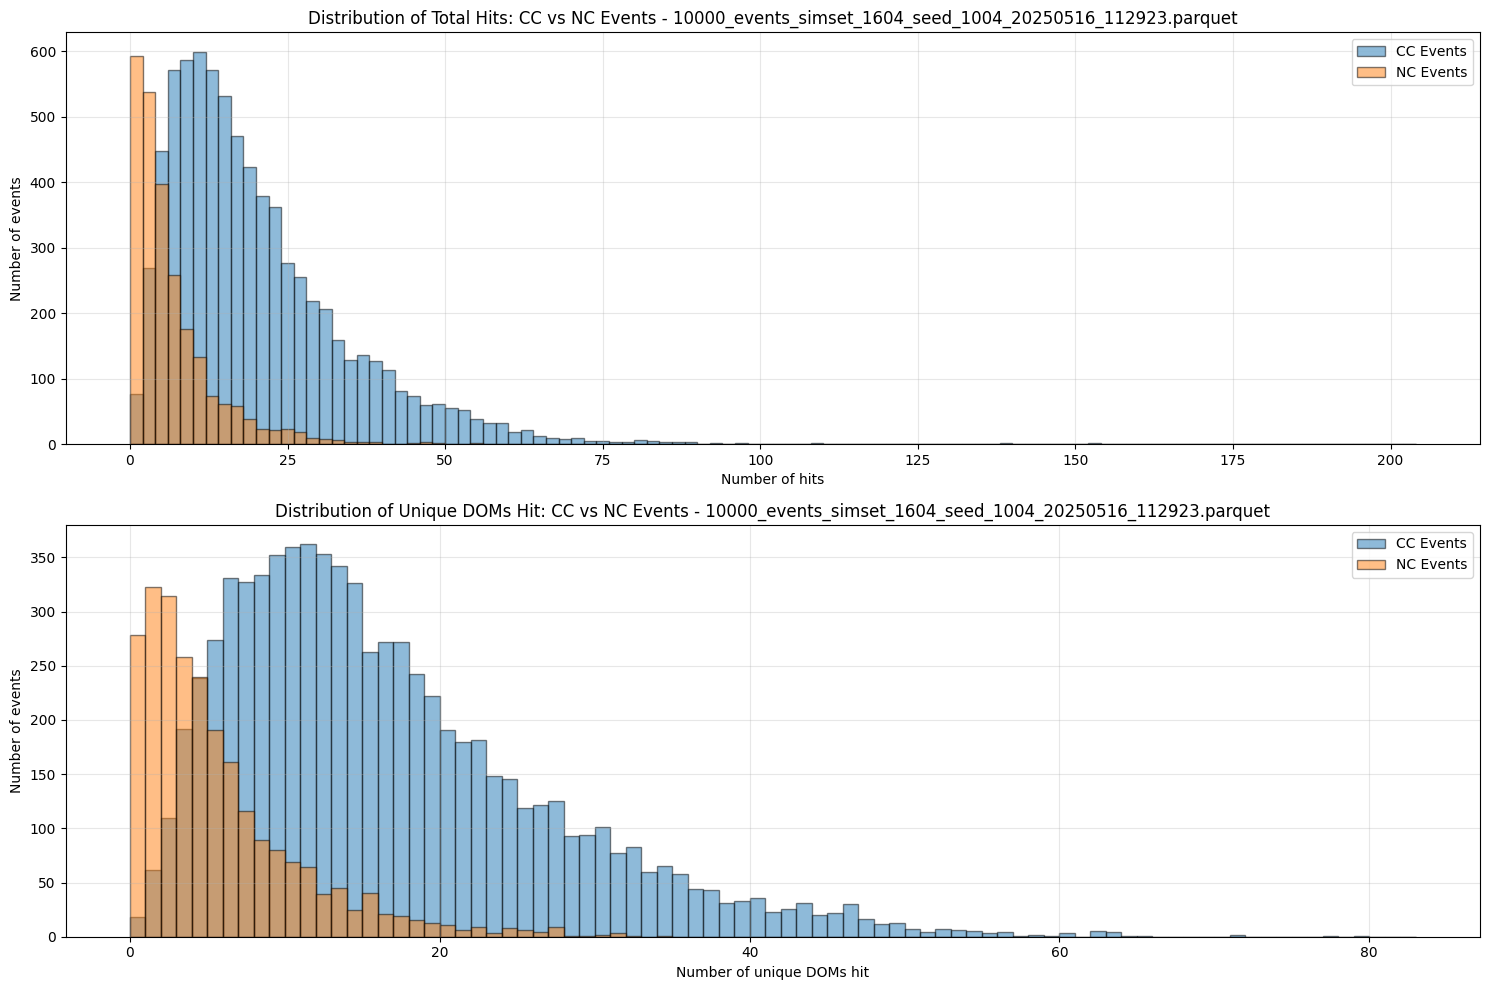

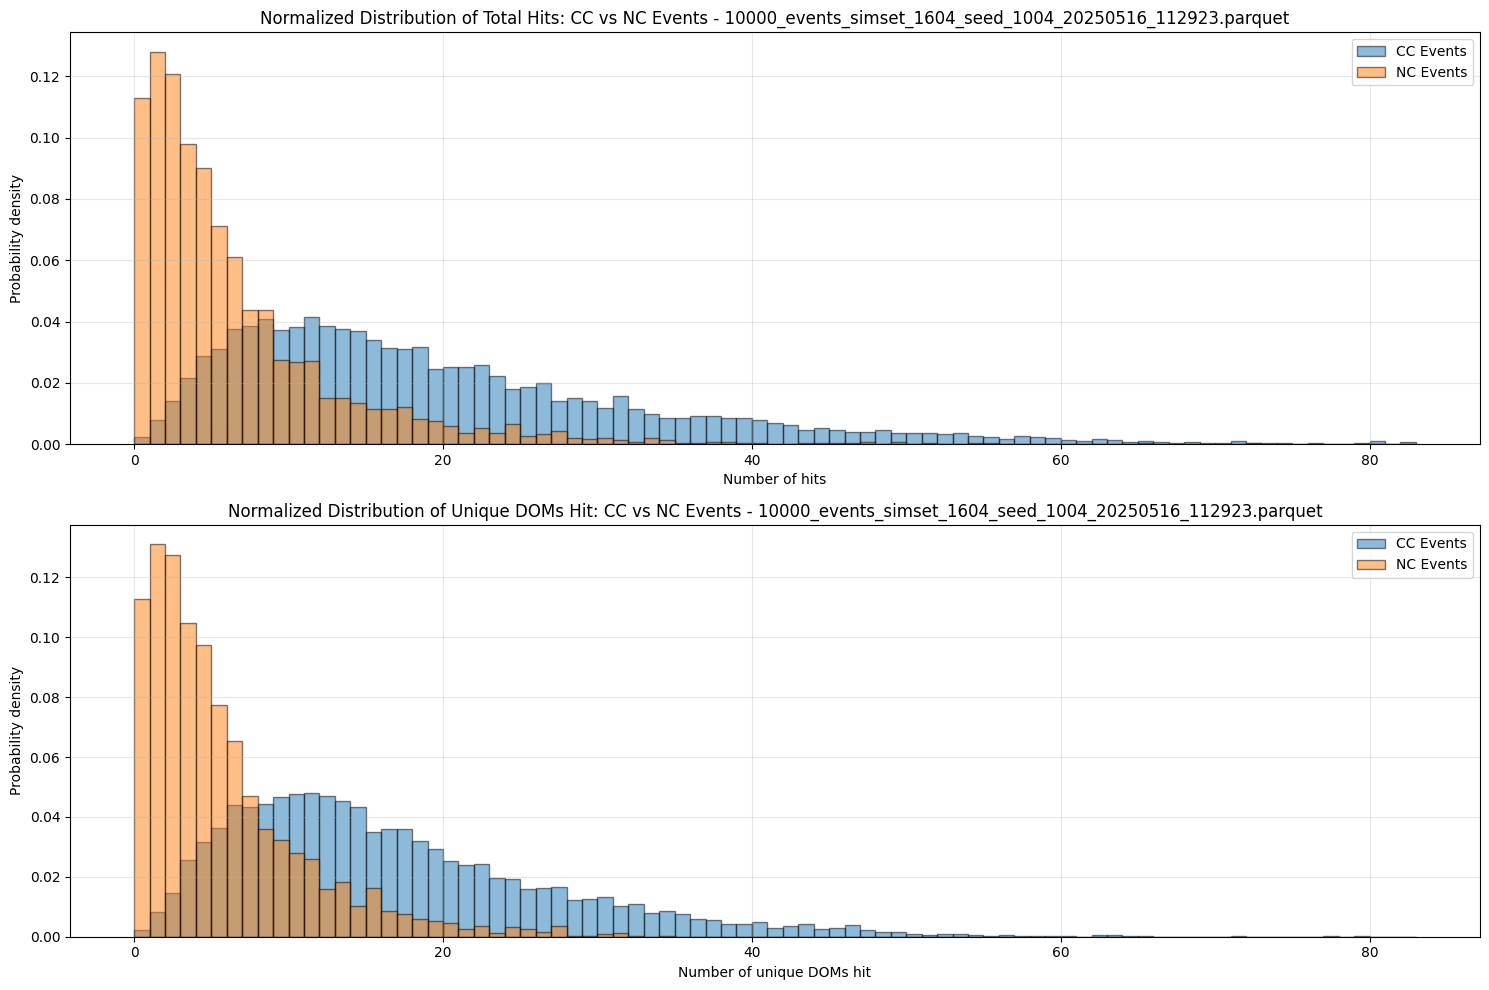


Processing 10000_events_simset_1605_seed_1005_20250516_112950.parquet...
Loaded 10000 events
Found 7417 CC events and 2583 NC events

Statistics for 10000_events_simset_1605_seed_1005_20250516_112950.parquet:
CC Events (7417 events):
  Mean hits: 19.53
  Median hits: 16.00
  Mean unique DOMs: 16.19
  Median unique DOMs: 14.00

NC Events (2583 events):
  Mean hits: 6.15
  Median hits: 4.00
  Mean unique DOMs: 5.08
  Median unique DOMs: 4.00


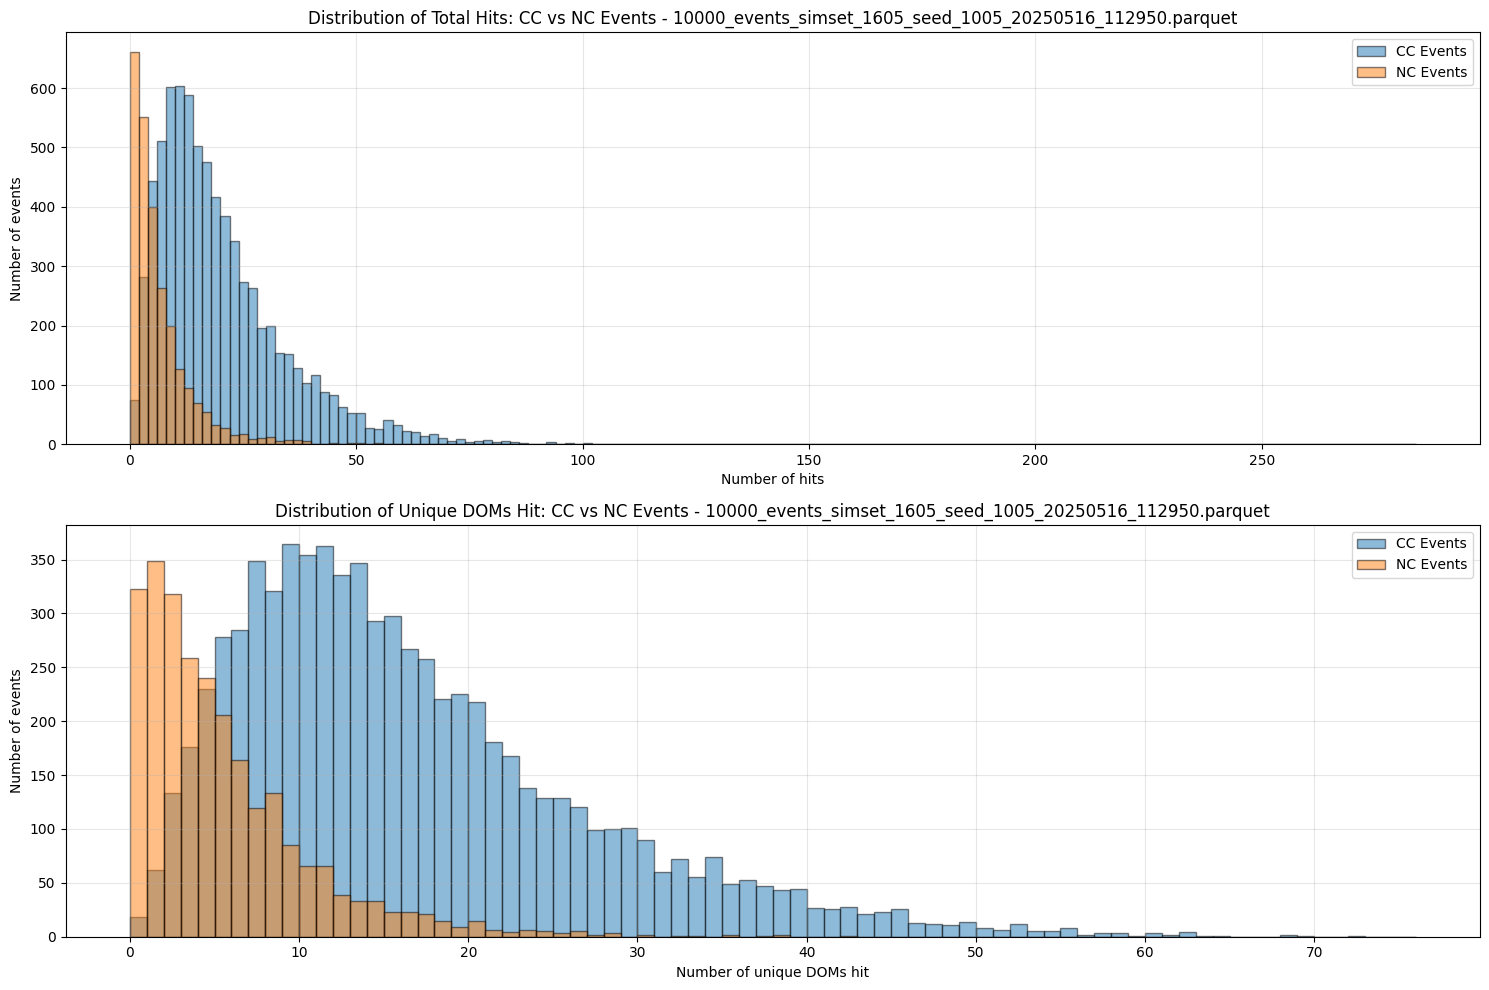

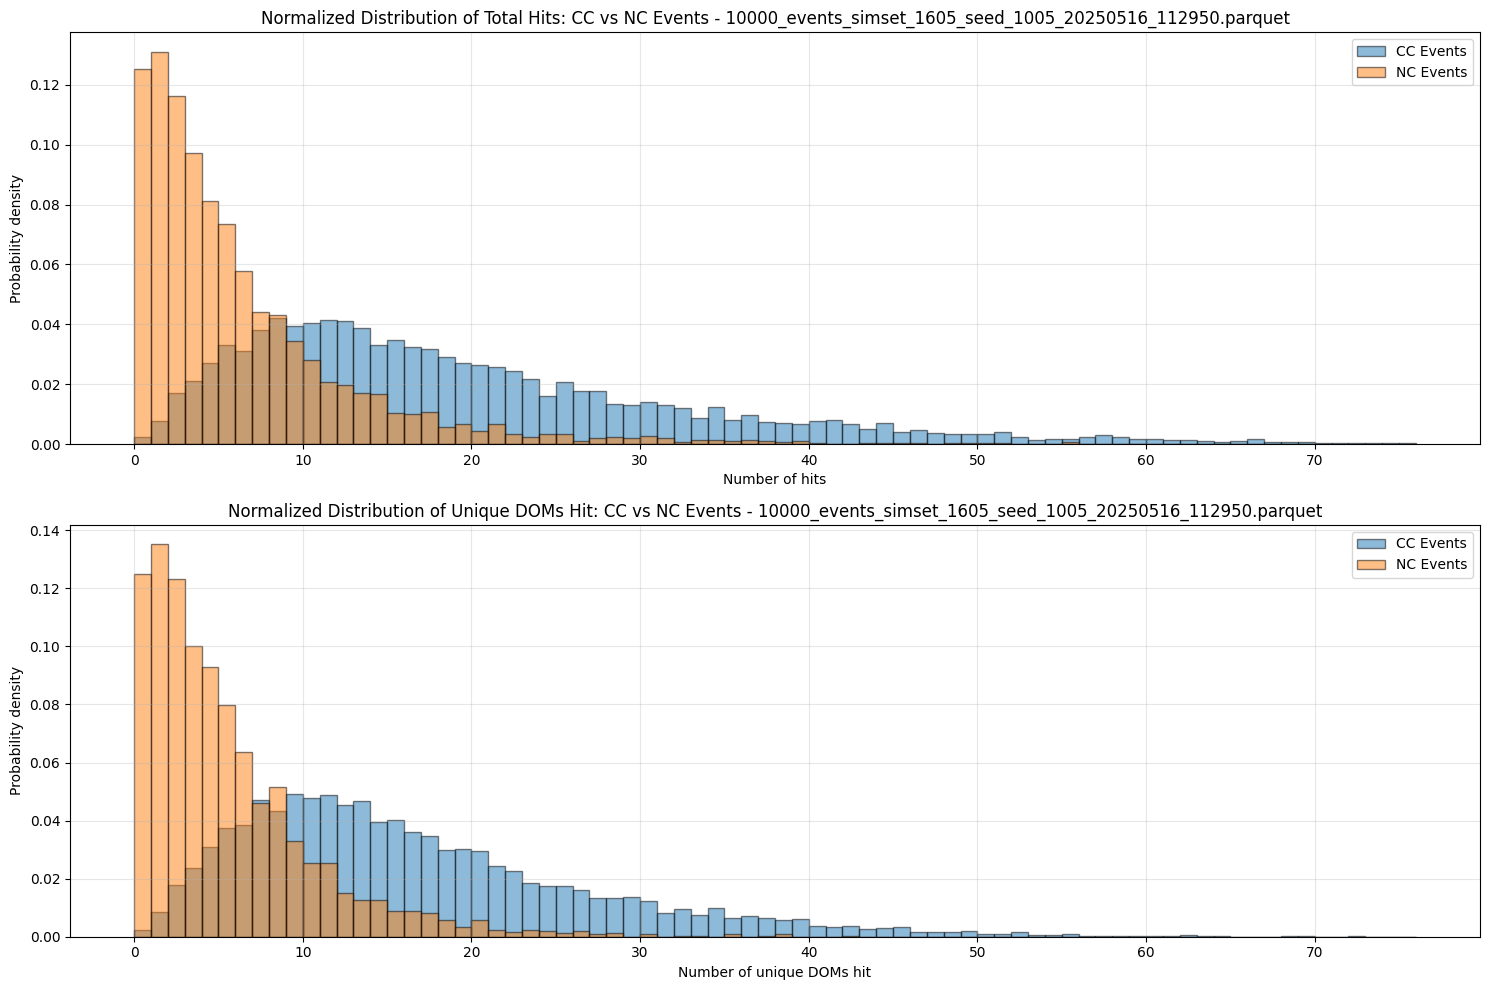

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing your files
data_dir = "output/"

# List of simulation output files
sim_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Process each file
for sim_file in sim_files:
    file_path = os.path.join(data_dir, sim_file)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    print(f"\nProcessing {sim_file}...")
    
    # Load the file
    df = pd.read_parquet(file_path)
    print(f"Loaded {len(df)} events")
    
    # Get CC and NC events
    nc_idx = []
    cc_idx = []
    
    for i, (idx, row) in enumerate(df.iterrows()):
        if row['mc_truth']['interaction'] == 1:
            cc_idx.append(idx)
        else:
            nc_idx.append(idx)
    
    print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")
    
    # Arrays to store total hit counts for CC and NC events
    cc_hits_per_event = np.zeros(len(cc_idx))
    nc_hits_per_event = np.zeros(len(nc_idx))
    
    # Arrays to store unique DOM hit counts
    cc_unique_doms_per_event = np.zeros(len(cc_idx))
    nc_unique_doms_per_event = np.zeros(len(nc_idx))
    
    # Process CC events
    for i, event_idx in enumerate(cc_idx):
        # Get photons data
        photons = df.iloc[event_idx]['photons']
        
        # Count total hits
        cc_hits_per_event[i] = len(photons['t'])
        
        # Count unique DOMs hit
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        cc_unique_doms_per_event[i] = len(set(zip(string_ids, sensor_ids)))
    
    # Process NC events
    for i, event_idx in enumerate(nc_idx):
        # Get photons data
        photons = df.iloc[event_idx]['photons']
        
        # Count total hits
        nc_hits_per_event[i] = len(photons['t'])
        
        # Count unique DOMs hit
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        nc_unique_doms_per_event[i] = len(set(zip(string_ids, sensor_ids)))
    
    # Create histograms
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Total hits distribution
    plt.subplot(2, 1, 1)
    max_hits = max(np.max(cc_hits_per_event), np.max(nc_hits_per_event))
    bins = np.arange(0, max_hits + 10, 2)  # Adjust bin size as needed
    
    plt.hist(cc_hits_per_event, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
    plt.hist(nc_hits_per_event, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
    plt.xlabel('Number of hits')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of Total Hits: CC vs NC Events - {sim_file}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Unique DOMs hit distribution
    plt.subplot(2, 1, 2)
    max_doms = max(np.max(cc_unique_doms_per_event), np.max(nc_unique_doms_per_event))
    bins = np.arange(0, max_doms + 5, 1)  # Adjust bin size as needed
    
    plt.hist(cc_unique_doms_per_event, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
    plt.hist(nc_unique_doms_per_event, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
    plt.xlabel('Number of unique DOMs hit')
    plt.ylabel('Number of events')
    plt.title(f'Distribution of Unique DOMs Hit: CC vs NC Events - {sim_file}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Print statistics
    print(f"\nStatistics for {sim_file}:")
    print(f"CC Events ({len(cc_idx)} events):")
    print(f"  Mean hits: {np.mean(cc_hits_per_event):.2f}")
    print(f"  Median hits: {np.median(cc_hits_per_event):.2f}")
    print(f"  Mean unique DOMs: {np.mean(cc_unique_doms_per_event):.2f}")
    print(f"  Median unique DOMs: {np.median(cc_unique_doms_per_event):.2f}")
    
    print(f"\nNC Events ({len(nc_idx)} events):")
    print(f"  Mean hits: {np.mean(nc_hits_per_event):.2f}")
    print(f"  Median hits: {np.median(nc_hits_per_event):.2f}")
    print(f"  Mean unique DOMs: {np.mean(nc_unique_doms_per_event):.2f}")
    print(f"  Median unique DOMs: {np.median(nc_unique_doms_per_event):.2f}")
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Normalized histograms
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Normalized total hits distribution
    plt.subplot(2, 1, 1)
    plt.hist(cc_hits_per_event, bins=bins, alpha=0.5, label='CC Events', 
             edgecolor='black', density=True)
    plt.hist(nc_hits_per_event, bins=bins, alpha=0.5, label='NC Events', 
             edgecolor='black', density=True)
    plt.xlabel('Number of hits')
    plt.ylabel('Probability density')
    plt.title(f'Normalized Distribution of Total Hits: CC vs NC Events - {sim_file}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Normalized unique DOMs hit distribution
    plt.subplot(2, 1, 2)
    plt.hist(cc_unique_doms_per_event, bins=bins, alpha=0.5, label='CC Events', 
             edgecolor='black', density=True)
    plt.hist(nc_unique_doms_per_event, bins=bins, alpha=0.5, label='NC Events', 
             edgecolor='black', density=True)
    plt.xlabel('Number of unique DOMs hit')
    plt.ylabel('Probability density')
    plt.title(f'Normalized Distribution of Unique DOMs Hit: CC vs NC Events - {sim_file}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Processing 10000_events_simset_1600_seed_1000_20250516_112519.parquet...
Loaded 10000 events
Found 7601 CC events and 2399 NC events

Processing 10000_events_simset_1601_seed_1001_20250516_112659.parquet...
Loaded 10000 events
Found 7517 CC events and 2483 NC events

Processing 10000_events_simset_1602_seed_1002_20250516_112840.parquet...
Loaded 10000 events
Found 7522 CC events and 2478 NC events

Processing 10000_events_simset_1603_seed_1003_20250516_112857.parquet...
Loaded 10000 events
Found 7497 CC events and 2503 NC events

Processing 10000_events_simset_1604_seed_1004_20250516_112923.parquet...
Loaded 10000 events
Found 7535 CC events and 2465 NC events

Processing 10000_events_simset_1605_seed_1005_20250516_112950.parquet...
Loaded 10000 events
Found 7417 CC events and 2583 NC events

Creating combined histograms...
Total CC events: 45089
Total NC events: 14911

Combined Statistics:
CC Events (45089 events):
  Mean hits: 19.66
  Median hits: 16.00
  Mean unique DOMs: 16.24
  M

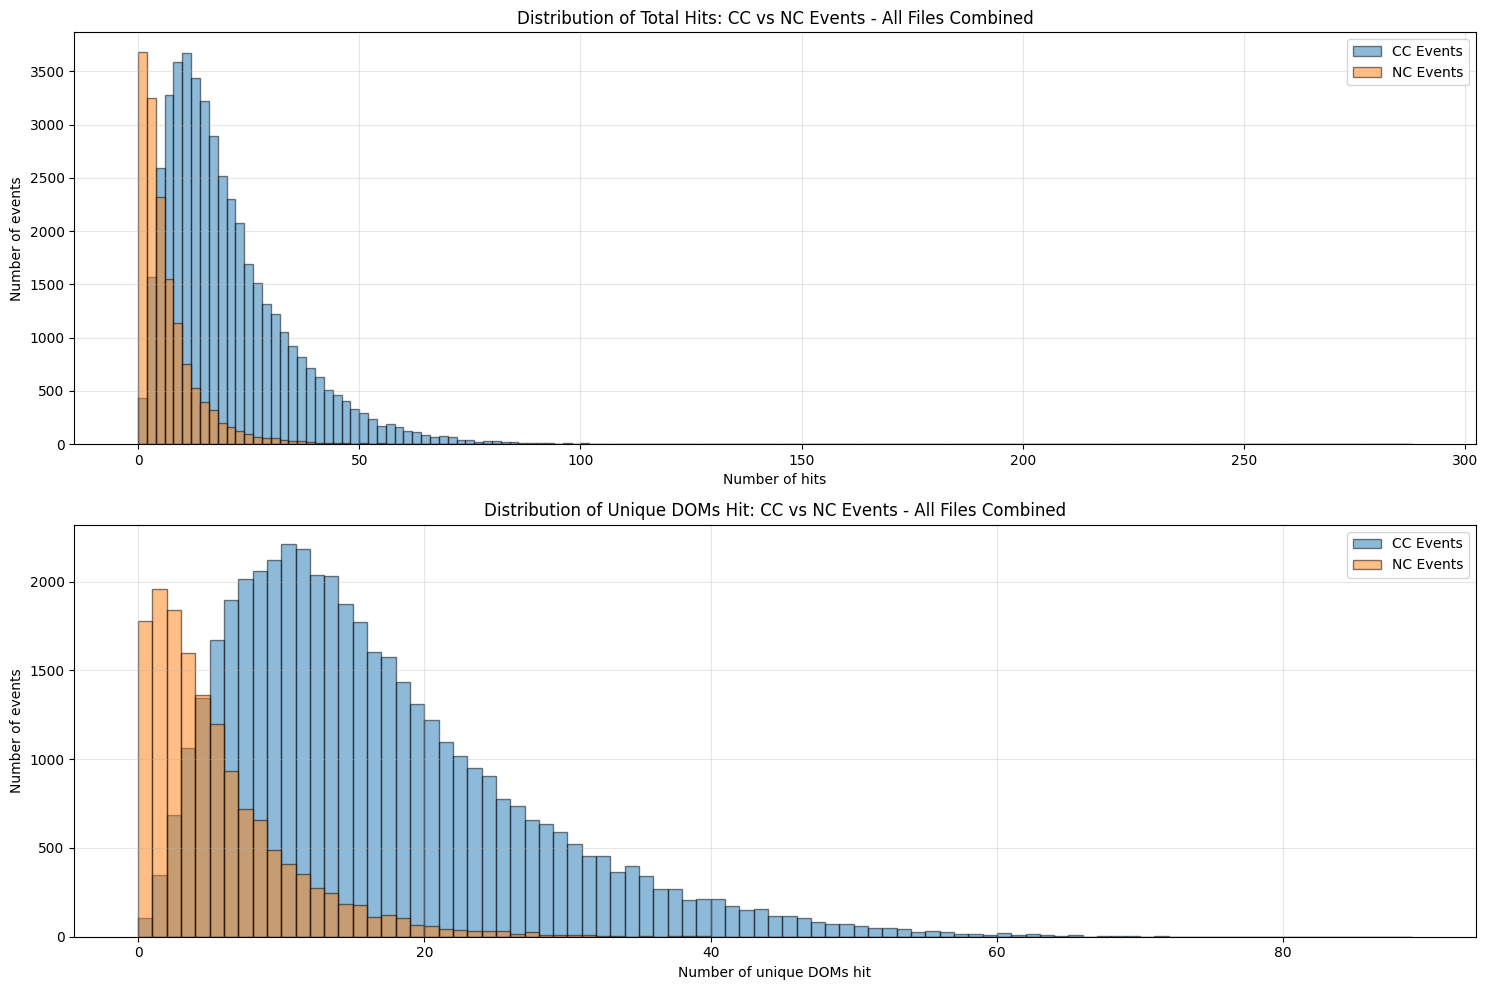

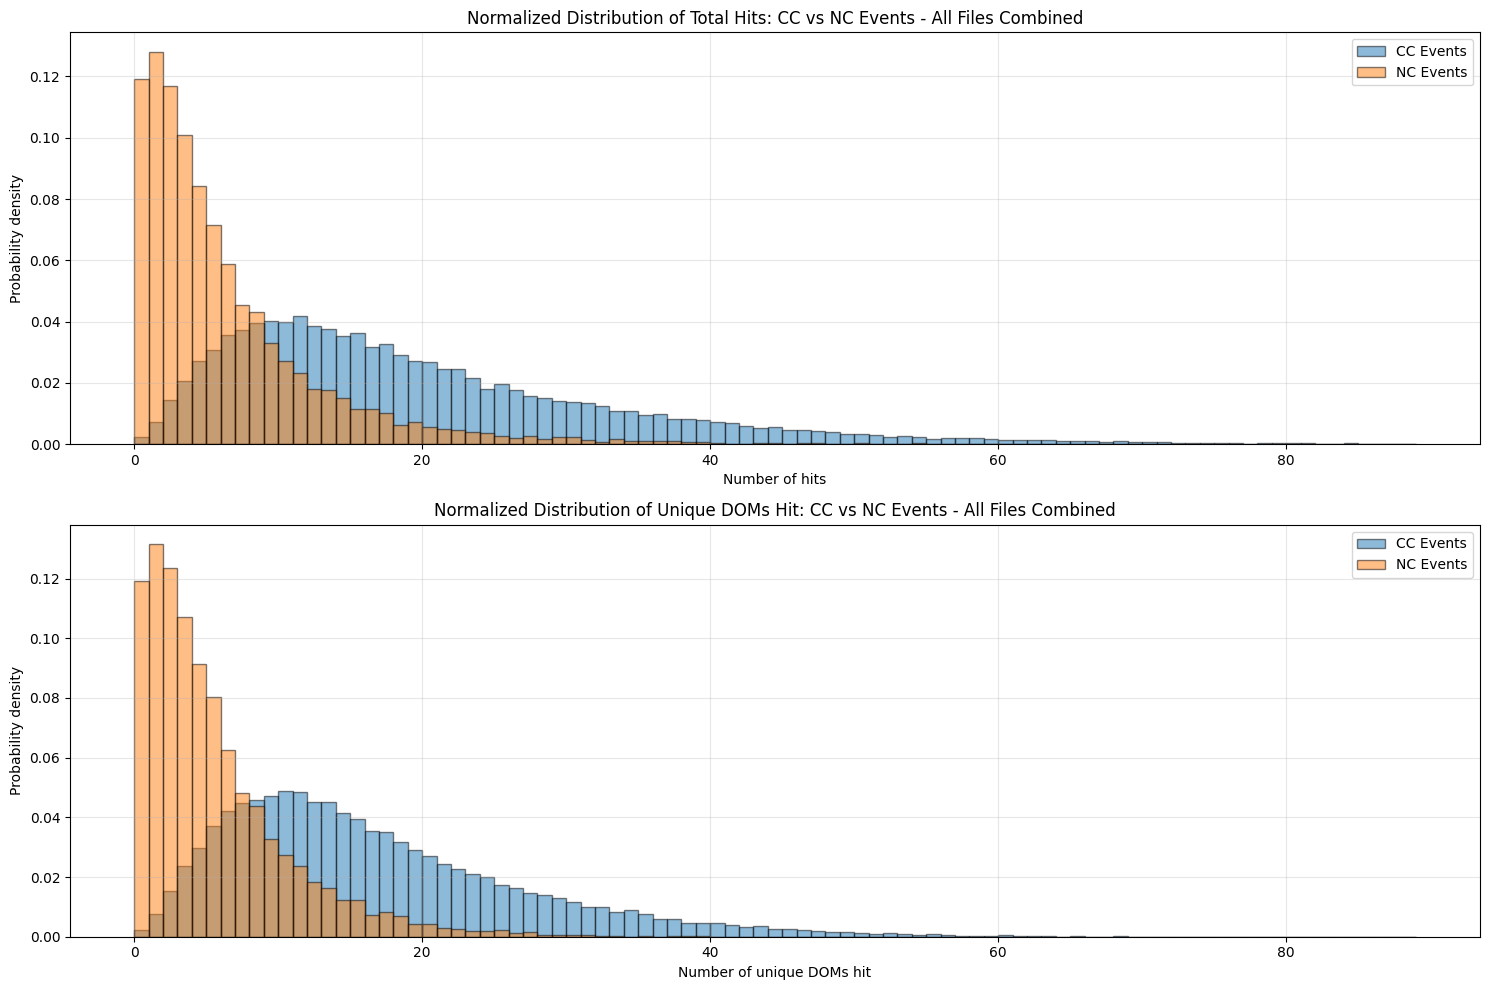

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing your files
data_dir = "output/"

# List of simulation output files
sim_files = [
    "10000_events_simset_1600_seed_1000_20250516_112519.parquet",
    "10000_events_simset_1601_seed_1001_20250516_112659.parquet",
    "10000_events_simset_1602_seed_1002_20250516_112840.parquet",
    "10000_events_simset_1603_seed_1003_20250516_112857.parquet",
    "10000_events_simset_1604_seed_1004_20250516_112923.parquet",
    "10000_events_simset_1605_seed_1005_20250516_112950.parquet"
]

# Lists to collect data from all files
all_cc_hits = []
all_nc_hits = []
all_cc_unique_doms = []
all_nc_unique_doms = []

# Process each file
for sim_file in sim_files:
    file_path = os.path.join(data_dir, sim_file)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    print(f"\nProcessing {sim_file}...")
    
    # Load the file
    df = pd.read_parquet(file_path)
    print(f"Loaded {len(df)} events")
    
    # Get CC and NC events
    nc_idx = []
    cc_idx = []
    
    for i, (idx, row) in enumerate(df.iterrows()):
        if row['mc_truth']['interaction'] == 1:
            cc_idx.append(idx)
        else:
            nc_idx.append(idx)
    
    print(f"Found {len(cc_idx)} CC events and {len(nc_idx)} NC events")
    
    # Arrays to store total hit counts for CC and NC events
    cc_hits_per_event = np.zeros(len(cc_idx))
    nc_hits_per_event = np.zeros(len(nc_idx))
    
    # Arrays to store unique DOM hit counts
    cc_unique_doms_per_event = np.zeros(len(cc_idx))
    nc_unique_doms_per_event = np.zeros(len(nc_idx))
    
    # Process CC events
    for i, event_idx in enumerate(cc_idx):
        # Get photons data
        photons = df.iloc[event_idx]['photons']
        
        # Count total hits
        cc_hits_per_event[i] = len(photons['t'])
        
        # Count unique DOMs hit
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        cc_unique_doms_per_event[i] = len(set(zip(string_ids, sensor_ids)))
    
    # Process NC events
    for i, event_idx in enumerate(nc_idx):
        # Get photons data
        photons = df.iloc[event_idx]['photons']
        
        # Count total hits
        nc_hits_per_event[i] = len(photons['t'])
        
        # Count unique DOMs hit
        string_ids = photons['string_id']
        sensor_ids = photons['sensor_id']
        nc_unique_doms_per_event[i] = len(set(zip(string_ids, sensor_ids)))
    
    # Add to combined lists
    all_cc_hits.extend(cc_hits_per_event)
    all_nc_hits.extend(nc_hits_per_event)
    all_cc_unique_doms.extend(cc_unique_doms_per_event)
    all_nc_unique_doms.extend(nc_unique_doms_per_event)

# Convert to numpy arrays
all_cc_hits = np.array(all_cc_hits)
all_nc_hits = np.array(all_nc_hits)
all_cc_unique_doms = np.array(all_cc_unique_doms)
all_nc_unique_doms = np.array(all_nc_unique_doms)

print("\nCreating combined histograms...")
print(f"Total CC events: {len(all_cc_hits)}")
print(f"Total NC events: {len(all_nc_hits)}")

# Create histograms for combined data
plt.figure(figsize=(15, 10))

# Plot 1: Total hits distribution
plt.subplot(2, 1, 1)
max_hits = max(np.max(all_cc_hits), np.max(all_nc_hits))
bins = np.arange(0, max_hits + 10, 2)  # Adjust bin size as needed

plt.hist(all_cc_hits, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(all_nc_hits, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Number of hits')
plt.ylabel('Number of events')
plt.title('Distribution of Total Hits: CC vs NC Events - All Files Combined')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Unique DOMs hit distribution
plt.subplot(2, 1, 2)
max_doms = max(np.max(all_cc_unique_doms), np.max(all_nc_unique_doms))
bins = np.arange(0, max_doms + 5, 1)  # Adjust bin size as needed

plt.hist(all_cc_unique_doms, bins=bins, alpha=0.5, label='CC Events', edgecolor='black')
plt.hist(all_nc_unique_doms, bins=bins, alpha=0.5, label='NC Events', edgecolor='black')
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Number of events')
plt.title('Distribution of Unique DOMs Hit: CC vs NC Events - All Files Combined')
plt.legend()
plt.grid(alpha=0.3)

# Print combined statistics
print(f"\nCombined Statistics:")
print(f"CC Events ({len(all_cc_hits)} events):")
print(f"  Mean hits: {np.mean(all_cc_hits):.2f}")
print(f"  Median hits: {np.median(all_cc_hits):.2f}")
print(f"  Mean unique DOMs: {np.mean(all_cc_unique_doms):.2f}")
print(f"  Median unique DOMs: {np.median(all_cc_unique_doms):.2f}")

print(f"\nNC Events ({len(all_nc_hits)} events):")
print(f"  Mean hits: {np.mean(all_nc_hits):.2f}")
print(f"  Median hits: {np.median(all_nc_hits):.2f}")
print(f"  Mean unique DOMs: {np.mean(all_nc_unique_doms):.2f}")
print(f"  Median unique DOMs: {np.median(all_nc_unique_doms):.2f}")

plt.tight_layout()
plt.show()

# Normalized histograms for combined data
plt.figure(figsize=(15, 10))

# Plot 1: Normalized total hits distribution
plt.subplot(2, 1, 1)
plt.hist(all_cc_hits, bins=bins, alpha=0.5, label='CC Events', 
         edgecolor='black', density=True)
plt.hist(all_nc_hits, bins=bins, alpha=0.5, label='NC Events', 
         edgecolor='black', density=True)
plt.xlabel('Number of hits')
plt.ylabel('Probability density')
plt.title('Normalized Distribution of Total Hits: CC vs NC Events - All Files Combined')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Normalized unique DOMs hit distribution
plt.subplot(2, 1, 2)
plt.hist(all_cc_unique_doms, bins=bins, alpha=0.5, label='CC Events', 
         edgecolor='black', density=True)
plt.hist(all_nc_unique_doms, bins=bins, alpha=0.5, label='NC Events', 
         edgecolor='black', density=True)
plt.xlabel('Number of unique DOMs hit')
plt.ylabel('Probability density')
plt.title('Normalized Distribution of Unique DOMs Hit: CC vs NC Events - All Files Combined')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()